# Music Categorization and Playlist Creation using Machine Learning

## 1. Setup and Imports

In [1]:
import os
import numpy as np
from tqdm import tqdm  # Import the tqdm library for progress bars
import librosa
import essentia.standard as es
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
from urllib.parse import unquote
import json  # For caching
import hashlib  # To create unique identifiers for songs
from collections import Counter
from sklearn.utils import resample
import hashlib
import random
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Function to save the cache after processing each song
def save_cache(features_cache):
    with open(cache_file_path, 'w') as cache_file:
        json.dump(features_cache, cache_file)


def generate_hash(file_name):
    """Generate a unique hash for a file based on its name."""
    hasher = hashlib.md5()
    hasher.update(file_name.encode('utf-8'))
    return hasher.hexdigest()

# Audio Feature Extraction Overview

The `extract_features` function is designed to extract various audio features from a song by analyzing multiple segments of the audio file. This process helps capture the overall characteristics of the song, which is particularly useful for genres like electronic music where different sections may have distinct properties.

## Extracted Features

### 1. **MFCCs (Mel-Frequency Cepstral Coefficients)**
   - **Description**: MFCCs are coefficients that represent the short-term power spectrum of sound, commonly used in speech and audio processing. They are derived from a type of cepstral representation of the audio clip.
   - **Usage**: Often used in music genre classification, speech recognition, and sound identification.

### 2. **Chroma Features**
   - **Description**: Chroma features relate to the twelve different pitch classes (such as C, C#, D, etc.) in music. They are a powerful representation of the harmonic content of a song.
   - **Usage**: Useful for tasks involving harmony, chord recognition, and key detection.

### 3. **Spectral Contrast**
   - **Description**: Spectral contrast measures the difference in amplitude between peaks and valleys in a sound spectrum. It captures the harmonic structure and timbral texture of a sound.
   - **Usage**: Helps in distinguishing between different music genres and identifying musical instruments.

### 4. **Zero-Crossing Rate (ZCR)**
   - **Description**: ZCR is the rate at which the signal changes sign (i.e., from positive to negative or vice versa). It is a measure of the noisiness of the signal.
   - **Usage**: Commonly used in audio classification, particularly for detecting percussive sounds and distinguishing between voiced and unvoiced speech.

### 5. **Spectral Centroid**
   - **Description**: The spectral centroid is the "center of mass" of the spectrum, which indicates where the center of energy is located in the frequency domain.
   - **Usage**: Often associated with the brightness of a sound; higher values correspond to brighter, more treble-rich sounds.

### 6. **RMS (Root Mean Square Energy)**
   - **Description**: RMS measures the average power or loudness of the audio signal. It is a straightforward measure of the energy present in the signal.
   - **Usage**: Used in audio analysis for volume normalization and dynamic range compression.

### 7. **Harmonic/Percussive Components**
   - **Description**: This feature separates the harmonic (tonal) and percussive (transient) elements of the audio signal.
   - **Usage**: Useful for rhythm analysis, music separation, and remixing tasks.

### 8. **Spectral Roll-off**
   - **Description**: Spectral roll-off is the frequency below which a certain percentage (e.g., 85%) of the total spectral energy is contained. It indicates the amount of high-frequency content in the signal.
   - **Usage**: Helps in identifying whether a sound is dominated by high or low frequencies, which can be useful in genre classification.

### 9. **Tonnetz (Tonal Centroid Features)**
   - **Description**: Tonnetz features represent the harmonic relationships in music, such as intervals and chords. These are calculated using a tonnetz diagram which maps harmonic relationships.
   - **Usage**: Primarily used in music information retrieval, key detection, and chord recognition.

## Summary
These features, when combined, provide a comprehensive representation of the audio signal, capturing various aspects such as timbre, harmony, rhythm, and loudness. By sampling multiple segments of the song, the `extract_features` function ensures that the extracted features are representative of the entire track, making it a robust tool for music analysis tasks.

In [3]:
def extract_features(file_name, check_cache=True, num_segments=4, segment_duration=20):
    """
    Extract various audio features from a given audio file by sampling multiple segments.
    
    Args:
        file_name (str): The path to the audio file.
        num_segments (int): Number of segments to sample from the song.
        segment_duration (int): Duration of each segment in seconds.
    
    Returns:
        dict: A dictionary of extracted audio features if successful, None otherwise.
    """
    # Generate a unique key for the file
    file_hash = generate_hash(file_name)

    # Define the required features
    required_features = [
        "mfccs_mean", "chroma_mean", "spectral_contrast_mean", "zcr_mean", 
        "spectral_centroid_mean", "rms_mean", "harmonic_mean", "percussive_mean",
        "spectral_rolloff_mean", "tonnetz_mean", "spectral_bandwidth_mean",
        "spectral_flatness_mean", "tempo_mean", "onset_strength_mean"
    ]

    # Check if features are already cached
    if file_hash in features_cache and check_cache:
        cached_features = features_cache[file_hash]
        if all(feature in cached_features for feature in required_features):
            return cached_features

    # If any features are missing, proceed with the extraction
    cached_features = {}

    try:
        # Load audio to get the total duration
        y, sr = librosa.load(file_name, sr=None)
        total_duration = len(y) / sr

        # Ensure the song is long enough to extract the desired segments
        if total_duration < segment_duration * num_segments:
            print(f"Audio too short: {file_name}")
            return None

        # Calculate the starting points for each segment
        segment_starts = [
            0,  # Start of the song
            max(0, (total_duration / 3) - (segment_duration / 2)),  # Start of the middle segment
            max(0, (2 * total_duration / 3) - (segment_duration / 2)),  # Start of the second middle segment
            max(0, total_duration - segment_duration)  # End of the song
        ]

        # Initialize feature accumulators only if they are not in the cache
        mfccs_accum = [] if "mfccs_mean" not in cached_features else None
        chroma_accum = [] if "chroma_mean" not in cached_features else None
        spectral_contrast_accum = [] if "spectral_contrast_mean" not in cached_features else None
        zcr_accum = [] if "zcr_mean" not in cached_features else None
        spectral_centroid_accum = [] if "spectral_centroid_mean" not in cached_features else None
        rms_accum = [] if "rms_mean" not in cached_features else None
        harmonic_accum = [] if "harmonic_mean" not in cached_features else None
        percussive_accum = [] if "percussive_mean" not in cached_features else None
        spectral_rolloff_accum = [] if "spectral_rolloff_mean" not in cached_features else None
        tonnetz_accum = [] if "tonnetz_mean" not in cached_features else None
        spectral_bandwidth_accum = [] if "spectral_bandwidth_mean" not in cached_features else None
        spectral_flatness_accum = [] if "spectral_flatness_mean" not in cached_features else None
        tempo_accum = [] if "tempo_mean" not in cached_features else None
        onset_strength_accum = [] if "onset_strength_mean" not in cached_features else None

        for start in segment_starts:
            y_segment = y[int(sr * start):int(sr * (start + segment_duration))]

            # MFCCs
            if mfccs_accum is not None:
                mfccs = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
                mfccs_accum.append(np.mean(mfccs.T, axis=0))

            # Chroma features
            if chroma_accum is not None:
                chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
                chroma_accum.append(np.mean(chroma.T, axis=0))

            # Spectral contrast
            if spectral_contrast_accum is not None:
                spectral_contrast = librosa.feature.spectral_contrast(y=y_segment, sr=sr)
                spectral_contrast_accum.append(np.mean(spectral_contrast.T, axis=0))

            # Zero-Crossing Rate
            if zcr_accum is not None:
                zcr = librosa.feature.zero_crossing_rate(y_segment)
                zcr_accum.append(np.mean(zcr))

            # Spectral Centroid
            if spectral_centroid_accum is not None:
                spectral_centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)
                spectral_centroid_accum.append(np.mean(spectral_centroid))

            # RMS (Root Mean Square Energy)
            if rms_accum is not None:
                rms = librosa.feature.rms(y=y_segment)
                rms_accum.append(np.mean(rms))

            # Harmonic/Percussive Separation
            if harmonic_accum is not None:
                harmonic, percussive = librosa.effects.hpss(y_segment)
                harmonic_accum.append(np.mean(harmonic))
                percussive_accum.append(np.mean(percussive))

            # Spectral Roll-off
            if spectral_rolloff_accum is not None:
                spectral_rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)
                spectral_rolloff_accum.append(np.mean(spectral_rolloff))

            # Tonnetz
            if tonnetz_accum is not None:
                tonnetz = librosa.feature.tonnetz(y=y_segment, sr=sr)
                tonnetz_accum.append(np.mean(tonnetz.T, axis=0))

            # Spectral Bandwidth
            if spectral_bandwidth_accum is not None:
                spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_segment, sr=sr)
                spectral_bandwidth_accum.append(np.mean(spectral_bandwidth))

            # Spectral Flatness
            if spectral_flatness_accum is not None:
                spectral_flatness = librosa.feature.spectral_flatness(y=y_segment)
                spectral_flatness_accum.append(np.mean(spectral_flatness))

            # Tempo and Onset Strength
            if tempo_accum is not None or onset_strength_accum is not None:
                onset_env = librosa.onset.onset_strength(y=y_segment, sr=sr)
                if tempo_accum is not None:
                    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
                    tempo_accum.append(tempo)
                if onset_strength_accum is not None:
                    onset_strength_accum.append(np.mean(onset_env))

        # Aggregate all features into the cache if they were calculated
        if mfccs_accum is not None:
            cached_features["mfccs_mean"] = np.mean(mfccs_accum, axis=0).tolist()
        if chroma_accum is not None:
            cached_features["chroma_mean"] = np.mean(chroma_accum, axis=0).tolist()
        if spectral_contrast_accum is not None:
            cached_features["spectral_contrast_mean"] = np.mean(spectral_contrast_accum, axis=0).tolist()
        if zcr_accum is not None:
            cached_features["zcr_mean"] = float(np.mean(zcr_accum))
        if spectral_centroid_accum is not None:
            cached_features["spectral_centroid_mean"] = float(np.mean(spectral_centroid_accum))
        if rms_accum is not None:
            cached_features["rms_mean"] = float(np.mean(rms_accum))
        if harmonic_accum is not None:
            cached_features["harmonic_mean"] = float(np.mean(harmonic_accum))
        if percussive_accum is not None:
            cached_features["percussive_mean"] = float(np.mean(percussive_accum))
        if spectral_rolloff_accum is not None:
            cached_features["spectral_rolloff_mean"] = float(np.mean(spectral_rolloff_accum))
        if tonnetz_accum is not None:
            cached_features["tonnetz_mean"] = np.mean(tonnetz_accum, axis=0).tolist()
        if spectral_bandwidth_accum is not None:
            cached_features["spectral_bandwidth_mean"] = float(np.mean(spectral_bandwidth_accum))
        if spectral_flatness_accum is not None:
            cached_features["spectral_flatness_mean"] = float(np.mean(spectral_flatness_accum))
        if tempo_accum is not None:
            cached_features["tempo_mean"] = float(np.mean(tempo_accum))
        if onset_strength_accum is not None:
            cached_features["onset_strength_mean"] = float(np.mean(onset_strength_accum))

        # Cache the features
        features_cache[file_hash] = cached_features

        # Save the cache after each song is processed
        save_cache(features_cache)

        return cached_features

    except Exception as e:
        print(f"Error encountered while parsing file: {file_name} - error: {e}")
        return None


## Loading and Processing Data

In [4]:
# Function to parse XML file and extract song paths
def parse_xml(file_path, start_index=0):
    tree = ET.parse(file_path)
    root = tree.getroot()
    song_paths = []

    # Navigate to the Tracks dictionary in the XML structure
    tracks_dict = root.find('dict').find('dict')

    for track in tracks_dict:
        if track.tag == 'key':  # Skip 'key' tags
            continue
        track_dict = track

        location = None
        capture_next = False

        for elem in track_dict:
            if capture_next:
                location = elem.text
                capture_next = False
            if elem.tag == 'key' and elem.text == 'Location':
                capture_next = True  # The next element will be the location

        if location:
            # Decode the URL-encoded path and remove 'file://'
            song_path = unquote(location.replace('file://', ''))
            song_paths.append(song_path)

    return song_paths[start_index:]

In [5]:
# Path to cache file
cache_file_path = "./data/features_cache_1.json"
# Load the cache if it exists

if os.path.exists(cache_file_path):
    with open(cache_file_path, 'r') as cache_file:
        features_cache = json.load(cache_file)
else:
    features_cache = {}

# Function to load data and labels from XML and TXT files
def load_data_from_files(category_files):
    X = []
    y = []
    for label, file_path in category_files.items():
        if file_path.endswith('.xml'):
            song_paths = parse_xml(file_path)
        else:
            with open(file_path, 'r', encoding='latin-1') as f:
                song_paths = [line.strip() for line in f]
        
        print(f"Processing {len(song_paths)} songs from {file_path} under label '{label}'")
        
        for song_path in tqdm(song_paths, desc=f"Processing {label} songs", unit="song"):
            if os.path.exists(song_path):
                file_hash = generate_hash(song_path)
                features = extract_features(song_path)
                if features is not None:
                    X.append({file_hash: features})  # Store dictionary with file_hash as key
                    y.append({file_hash: label})  # Store dictionary with file_hash as key
            else:
                print(f"File not found: {song_path}")
                
    return X, y  # Returning lists of dictionaries


In [7]:


def downsample_data(X, y):
    # First, let's segregate the samples based on their labels
    label_to_samples = {}
    
    for i, label_dict in enumerate(y):
        sample_key = list(label_dict.keys())[0]
        label = label_dict[sample_key]
        if label not in label_to_samples:
            label_to_samples[label] = []
        label_to_samples[label].append((X[i], y[i]))
    
    # Identify the minimum number of samples across classes
    min_samples = min(len(samples) for samples in label_to_samples.values())
    
    # Downsample each class to the number of samples in the smallest class
    downsampled_X = []
    downsampled_y = []
    
    for label, samples in label_to_samples.items():
        downsampled_samples = random.sample(samples, min_samples)
        for sample_X, sample_y in downsampled_samples:
            downsampled_X.append(sample_X)
            downsampled_y.append(sample_y)
    
    return downsampled_X, downsampled_y

def upsample_data(X, y):
    # First, let's segregate the samples based on their labels
    label_to_samples = {}
    
    for i, label_dict in enumerate(y):
        sample_key = list(label_dict.keys())[0]
        label = label_dict[sample_key]
        if label not in label_to_samples:
            label_to_samples[label] = []
        label_to_samples[label].append((X[i], y[i]))
    
    # Identify the maximum number of samples across classes
    max_samples = max(len(samples) for samples in label_to_samples.values())
    
    # Upsample each class to the number of samples in the largest class
    upsampled_X = []
    upsampled_y = []
    
    for label, samples in label_to_samples.items():
        upsampled_samples = random.choices(samples, k=max_samples)
        for sample_X, sample_y in upsampled_samples:
            upsampled_X.append(sample_X)
            upsampled_y.append(sample_y)
    
    return upsampled_X, upsampled_y

In [9]:

def flatten_data(X, y):
    """Flatten the lists of dictionaries into a single DataFrame and a Series."""
    features_list = []
    labels_list = []
    
    for feature_dict, label_dict in zip(X, y):
        file_hash = list(feature_dict.keys())[0]  # Extract file hash
        features = feature_dict[file_hash]  # Extract the features tuple
        label = label_dict[file_hash]  # Extract the label
        
        # Create a single row with file_hash as an identifier
        row = {'file_hash': file_hash, **features}
        features_list.append(row)
        labels_list.append(label)
    
    features_df = pd.DataFrame(features_list)
    labels_series = pd.Series(labels_list, name='label')
    
    return features_df, labels_series

def remove_outliers(df, method='zscore', threshold=3, iqr_multiplier=1.5, retain_percentile=90, time_series_columns=[]):
    """
    Remove or retain outliers from a DataFrame using the specified method.
    
    Args:
        df (DataFrame): The DataFrame from which to remove outliers.
        method (str): The method to use for outlier detection ('zscore', 'iqr', or 'none').
        threshold (float): The threshold for identifying outliers (used for 'zscore' method).
        iqr_multiplier (float): The multiplier for the IQR range (used for 'iqr' method).
        retain_percentile (float): The percentage of data points closest to the mean to retain (0-100).
        time_series_columns (list): List of columns that contain time series data.
    
    Returns:
        DataFrame: The DataFrame with outliers removed or adjusted.
    """
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    for column in numeric_columns:
        if column in time_series_columns:
            # Assuming time series data is stored in lists or arrays within the DataFrame cells
            # You could compute various summary statistics:
            print('column:', column)
            df[column + '_mean'] = df[column].apply(np.mean)
            df[column + '_std'] = df[column].apply(np.std)
            df[column + '_min'] = df[column].apply(np.min)
            df[column + '_max'] = df[column].apply(np.max)
            summary_stats = [column + '_mean', column + '_std', column + '_min', column + '_max']
            
            # Apply outlier detection on these summary statistics
            for stat in summary_stats:
                if method == 'zscore':
                    z_scores = np.abs(stats.zscore(df[stat]))
                    df = df[z_scores < threshold]
                elif method == 'iqr':
                    Q1 = df[stat].quantile(0.25)
                    Q3 = df[stat].quantile(0.75)
                    IQR = Q3 - Q1
                    df = df[~((df[stat] < (Q1 - iqr_multiplier * IQR)) | (df[stat] > (Q3 + iqr_multiplier * IQR)))]
                
        else:
            # Non-time series data can be processed as before
            if method == 'zscore':
                z_scores = np.abs(stats.zscore(df[column]))
                df = df[z_scores < threshold]
            elif method == 'iqr':
                Q1 = df[column].quantile(0.25)
                Q3 = df[column].quantile(0.75)
                IQR = Q3 - Q1
                df = df[~((df[column] < (Q1 - iqr_multiplier * IQR)) | (df[column] > (Q3 + iqr_multiplier * IQR)))]

    if retain_percentile < 100:
        # Compute the distance from the mean for each numeric column separately
        distance_from_mean = df.select_dtypes(include=[np.number]).apply(lambda x: np.abs(x - x.mean()))
        
        # Apply percentile cutoff based on feature-level distance
        for column in numeric_columns:
            overall_distance = distance_from_mean[column]
            cutoff = np.percentile(overall_distance, retain_percentile)
            df = df[overall_distance <= cutoff]

    return df



def reconstruct_data(features_df, labels_series):
    """Reconstruct the original dictionary structure after outlier removal."""
    X_cleaned = []
    y_cleaned = []
    
    for index, row in features_df.iterrows():
        file_hash = row['file_hash']
        features = row.drop('file_hash').to_dict()
        label = labels_series.iloc[index]
        
        X_cleaned.append({file_hash: features})
        y_cleaned.append({file_hash: label})
    
    return X_cleaned, y_cleaned

In [10]:
# Paths to your files
category_files = {
    "liked": "./data/liked.xml",
    "disliked": "./data/disliked.xml",
}

# Load the data for liked and disliked categories
category_files_for_training = {
    "liked": category_files["liked"],
    "disliked": category_files["disliked"]
}

X, y = load_data_from_files(category_files_for_training)

from collections import Counter

def count_correct_and_incorrect_format(X):
    correct_count = 0
    incorrect_count = 0

    for item in X:
        if isinstance(item, tuple) and len(item) == 2:
            obj, hash_value = item
            if isinstance(hash_value, str):  # Assuming hash should be a string
                correct_count += 1
            else:
                incorrect_count += 1
        else:
            incorrect_count += 1
    
    return correct_count, incorrect_count

# Flatten data
print(X[:1])
print(y[:1])



Processing 623 songs from ./data/liked.xml under label 'liked'


Processing liked songs:   0%|                      | 0/623 [00:00<?, ?song/s]/Users/beenerdy/code/AI&ML/venv/lib/python3.12/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing liked songs: 100%|████████████| 623/623 [00:07<00:00, 80.64song/s]


Error encountered while parsing file: /Users/beenerdy/Music/Lexicon/Uploaded/Disco Connection (Original Mix)-Qubiko.mp3 - error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.
Processing 1173 songs from ./data/disliked.xml under label 'disliked'


Processing disliked songs:   0%|                  | 0/1173 [00:00<?, ?song/s]

File not found: /Users/octavianrotari/Music/Lexicon/Uploaded/Wunderbar (Original Mix)-Dan Caster.mp3


Processing disliked songs:   3%|▏        | 32/1173 [00:06<03:45,  5.05song/s]

Error encountered while parsing file: /Users/beenerdy/Music/Lexicon/Uploaded/Your Love-Frankie Knuckles.mp3 - error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.
Audio too short: /Users/beenerdy/Music/Lexicon/Uploaded/Mit Dir-Jurgen Paape.mp3
File not found: /Users/octavianrotari/.Trash/Fruit&Sun-ford..m4a
File not found: /Users/octavianrotari/.Trash/Purple Noise (Boris Brejcha Re-Noise Edit 2021)-Boris Brejcha.aiff
File not found: /Users/octavianrotari/.Trash/Dopamine Machine (Club Mix)-CamelPhat, Ali Love.aiff
File not found: /Users/octavianrotari/.Trash/Want You All _ Love On The Line (Accapella) - Mixed-Jade Cox.mp3
File not found: /Users/octavianrotari/.Trash/Can You Feel It (Steve Bug Re-Dub)-Chez Damier.mp3


Note: Illegal Audio-MPEG-Header 0xb5ed85ec at offset 155632.
Note: Trying to resync...
Note: Skipped 176 bytes in input.
Note: Illegal Audio-MPEG-Header 0xe0e5e60c at offset 321947.
Note: Trying to resync...
Note: Skipped 130 bytes in input.
Processing disliked songs: 100%|███████| 1173/1173 [00:13<00:00, 89.07song/s]

Error encountered while parsing file: /Users/beenerdy/Music/Lexicon/Uploaded/Almost Home-Moby.mp3 - error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.
File not found: /Users/octavianrotari/.Trash/Juni-Snook.mp3
File not found: /Users/octavianrotari/.Trash/A Moment Of Silence (Original Mix)-Celestial Strangers.mp3
File not found: /Users/octavianrotari/.Trash/Bagan (Nebula AR Remix)-Urmet K.mp3
File not found: /Users/octavianrotari/.Trash/Who Loves The Sun (Original Mix)-Nu, Joke.mp3
File not found: /Users/octavianrotari/.Trash/Annie Hall-Oskar Linnros.mp3
File not found: /Users/octavianrotari/.Trash/Africa (Original Mix)-Digitaline.mp3
File not found: /Users/octavianrotari/.Trash/Citrus Grove-Sans Souci.m4a
File not found: /Users/octavianrotari/.Trash/Dear Life Feat. Jaw (Original Mix)-Jaw, Claptone.mp3
[{'357755bd02a991783a27be215a04910b': {'mfccs_mean': [-253.613067626953

In [11]:
print(X[:1])

[{'357755bd02a991783a27be215a04910b': {'mfccs_mean': [-253.61306762695312, 89.5411605834961, 20.96102523803711, 49.05832290649414, 12.170427322387695, 26.233572006225586, 4.318063735961914, 12.131490707397461, 0.41494977474212646, 9.25466251373291, 2.2280521392822266, -0.46983736753463745, 0.6199897527694702], 'chroma_mean': [0.5870038270950317, 0.5757690668106079, 0.5578389167785645, 0.5910692811012268, 0.672053873538971, 0.7512646913528442, 0.6428897976875305, 0.6164823174476624, 0.5874449610710144, 0.5055182576179504, 0.4531225562095642, 0.46720609068870544], 'spectral_contrast_mean': [19.44744812149164, 10.706942664370112, 14.998176132455697, 15.669616004229699, 15.20948342025612, 15.757415448146329, 28.2020159564458], 'zcr_mean': 0.03571743336930499, 'spectral_centroid_mean': 2627.51223840043, 'rms_mean': 0.17730215191841125, 'harmonic_mean': 2.5153756723739207e-05, 'percussive_mean': 0.00029507972067222, 'spectral_rolloff_mean': 5807.831692598756, 'tonnetz_mean': [-0.027747843564

In [12]:
# Initialize empty lists for liked and disliked features
liked_features = []
disliked_features = []

# Flatten the data
features_df, labels_series = flatten_data(X, y)
print(len(X))

# Step 1: Separate the data into liked and disliked categories
liked_features_df = features_df[labels_series == 'liked'].copy()
disliked_features_df = features_df[labels_series == 'disliked'].copy()
print(len(liked_features_df))


# Step 2: Remove outliers only from the liked category
cleaned_liked_features_df = remove_outliers(liked_features_df, method='zscore', threshold=2)
cleaned_disliked_features_df = remove_outliers(disliked_features_df, method='zscore', threshold=3)
print(len(cleaned_liked_features_df))
print(len(cleaned_disliked_features_df))

# Step 3: Combine the liked and disliked data back together
cleaned_features_df = pd.concat([cleaned_liked_features_df, cleaned_disliked_features_df])

# Ensure the order of labels matches the cleaned features
cleaned_labels_series = labels_series[cleaned_features_df.index]

# Reset the index to align indices of features and labels
cleaned_features_df.reset_index(drop=True, inplace=True)
cleaned_labels_series = labels_series[cleaned_features_df.index].reset_index(drop=True)

# Step 4: Reconstruct the data
X_cleaned, y_cleaned = reconstruct_data(cleaned_features_df, cleaned_labels_series)
print(len(X_cleaned))

1778
622
204
506
710


/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/3051419143.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/3051419143.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/3051419143.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/3051419143.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/3051419143.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs

In [13]:
print(X_cleaned[:1])

[{'357755bd02a991783a27be215a04910b': {'mfccs_mean': [-253.61306762695312, 89.5411605834961, 20.96102523803711, 49.05832290649414, 12.170427322387695, 26.233572006225586, 4.318063735961914, 12.131490707397461, 0.41494977474212646, 9.25466251373291, 2.2280521392822266, -0.46983736753463745, 0.6199897527694702], 'chroma_mean': [0.5870038270950317, 0.5757690668106079, 0.5578389167785645, 0.5910692811012268, 0.672053873538971, 0.7512646913528442, 0.6428897976875305, 0.6164823174476624, 0.5874449610710144, 0.5055182576179504, 0.4531225562095642, 0.46720609068870544], 'spectral_contrast_mean': [19.44744812149164, 10.706942664370112, 14.998176132455697, 15.669616004229699, 15.20948342025612, 15.757415448146329, 28.2020159564458], 'zcr_mean': 0.03571743336930499, 'spectral_centroid_mean': 2627.51223840043, 'rms_mean': 0.17730215191841125, 'harmonic_mean': 2.5153756723739207e-05, 'percussive_mean': 0.00029507972067222, 'spectral_rolloff_mean': 5807.831692598756, 'tonnetz_mean': [-0.027747843564

In [14]:
X_balanced, y_balanced = upsample_data(X_cleaned, y_cleaned)


# Extract just the labels from y_balanced for counting
labels_only = [list(item.values())[0] for item in y_balanced]

print(f"X balanced num of items: {len(X_balanced)}")
# Count the occurrences of each label
balanced_class_counts = Counter(labels_only)
print(f"Class distribution after balancing: {balanced_class_counts}")

X balanced num of items: 1244
Class distribution after balancing: Counter({'liked': 622, 'disliked': 622})


## Step 1: Extract and Process Time-Series and Static Features Separately

In [15]:
#1. Feature Normalization/Standardization Functions

In [16]:
print(X_balanced[:1])

[{'77987d4d51c187f64ebfd61818dc7d85': {'mfccs_mean': [-177.2037353515625, 121.65619659423828, -27.70580291748047, 47.30412292480469, -1.2183011770248413, 17.45047378540039, -11.139482498168945, 8.58388614654541, -5.363067150115967, -3.3852100372314453, -4.5780181884765625, -2.8449654579162598, -1.682321310043335], 'chroma_mean': [0.4997071325778961, 0.4737038016319275, 0.4809979200363159, 0.4613935351371765, 0.4505871534347534, 0.4587819576263428, 0.5472944974899292, 0.8144602179527283, 0.6534591913223267, 0.46650829911231995, 0.45064008235931396, 0.47333288192749023], 'spectral_contrast_mean': [20.757722679634256, 10.088754958892832, 16.595765170044572, 17.288996803150468, 15.517178328754587, 17.683084505748404, 34.478041426578585], 'zcr_mean': 0.06962988394606065, 'spectral_centroid_mean': 2922.1947099081062, 'rms_mean': 0.22486573457717896, 'harmonic_mean': -3.7362449347710935e-06, 'percussive_mean': -5.010830136598088e-05, 'spectral_rolloff_mean': 5763.493665096308, 'tonnetz_mean':

In [17]:
# Extract features and categorize them without modifying the original dictionary
def separate_features(entry):
    # Access the key and the corresponding feature dictionary
    hash_key = list(entry.keys())[0]
    features = entry[hash_key]  # Access the first element of the tuple which is the features dictionary
    
    # Time-series features (concatenated into one array)
    time_series_features = np.concatenate([
        features['mfccs_mean'],
        features['chroma_mean'],
        features['spectral_contrast_mean'],
        features['tonnetz_mean']
    ])
    
    # Static features
    static_features = [
        features['zcr_mean'],
        features['spectral_centroid_mean'],
        features['rms_mean'],
        features['harmonic_mean'],
        features['percussive_mean'],
        features['spectral_rolloff_mean'],
        features['spectral_bandwidth_mean'],
        features['spectral_flatness_mean'],
        features['tempo_mean'],
        features['onset_strength_mean']
    ]
    
    return time_series_features, static_features



# Apply the extraction to the entire list
X_time_series = []
X_static = []

for item in X_balanced:
    ts_features, static_features = separate_features(item)
    X_time_series.append(ts_features)
    X_static.append(static_features)

# Convert y_balanced into categorical values (1 for 'liked', 0 for 'disliked')
y_balanced_numeric = [1 if list(item.values())[0] == 'liked' else 0 for item in y_balanced]

# Create DataFrames
X_time_series_df = pd.DataFrame(X_time_series)
X_static_df = pd.DataFrame(X_static, columns=[
    'zcr_mean', 'spectral_centroid_mean', 'rms_mean', 
    'harmonic_mean', 'percussive_mean', 'spectral_rolloff_mean',
    'spectral_bandwidth_mean', 'spectral_flatness_mean',
    'tempo_mean', 'onset_strength_mean'
])

# Combine static features with labels
X_static_df['liked'] = y_balanced_numeric

# Optional: Standardize or normalize the time-series data
scaler = StandardScaler()
X_time_series_df_scaled = pd.DataFrame(scaler.fit_transform(X_time_series_df))

# Check the structure of the data
print("Static DataFrame:\n", X_static_df.head())
print("Time-Series DataFrame (scaled):\n", X_time_series_df_scaled.head())

# Assigning column names based on the presumed structure
mfcc_cols = [f'mfccs_mean_{i}' for i in range(13)]
chroma_cols = [f'chroma_mean_{i}' for i in range(12)]
spectral_contrast_cols = [f'spectral_contrast_mean_{i}' for i in range(7)]
tonnetz_cols = [f'tonnetz_mean_{i}' for i in range(6)]

# Combine all columns into a single list
column_names = mfcc_cols + chroma_cols + spectral_contrast_cols + tonnetz_cols

# Assign these column names to the DataFrame
X_time_series_df_scaled.columns = column_names


Static DataFrame:
    zcr_mean  spectral_centroid_mean  rms_mean  harmonic_mean  percussive_mean  \
0  0.069630             2922.194710  0.224866      -0.000004        -0.000050   
1  0.095657             3456.670669  0.171159      -0.000046        -0.000177   
2  0.061338             2993.524766  0.171432      -0.000071        -0.000333   
3  0.057369             3798.324454  0.169472      -0.000010         0.000012   
4  0.063163             2922.321529  0.203682      -0.000036        -0.000043   

   spectral_rolloff_mean  spectral_bandwidth_mean  spectral_flatness_mean  \
0            5763.493665              3089.023569                0.014823   
1            6693.070671              3332.492032                0.021837   
2            6001.296212              3425.595675                0.003753   
3            7974.593073              4078.945816                0.013980   
4            5737.864404              3392.296551                0.013731   

   tempo_mean  onset_strength_m

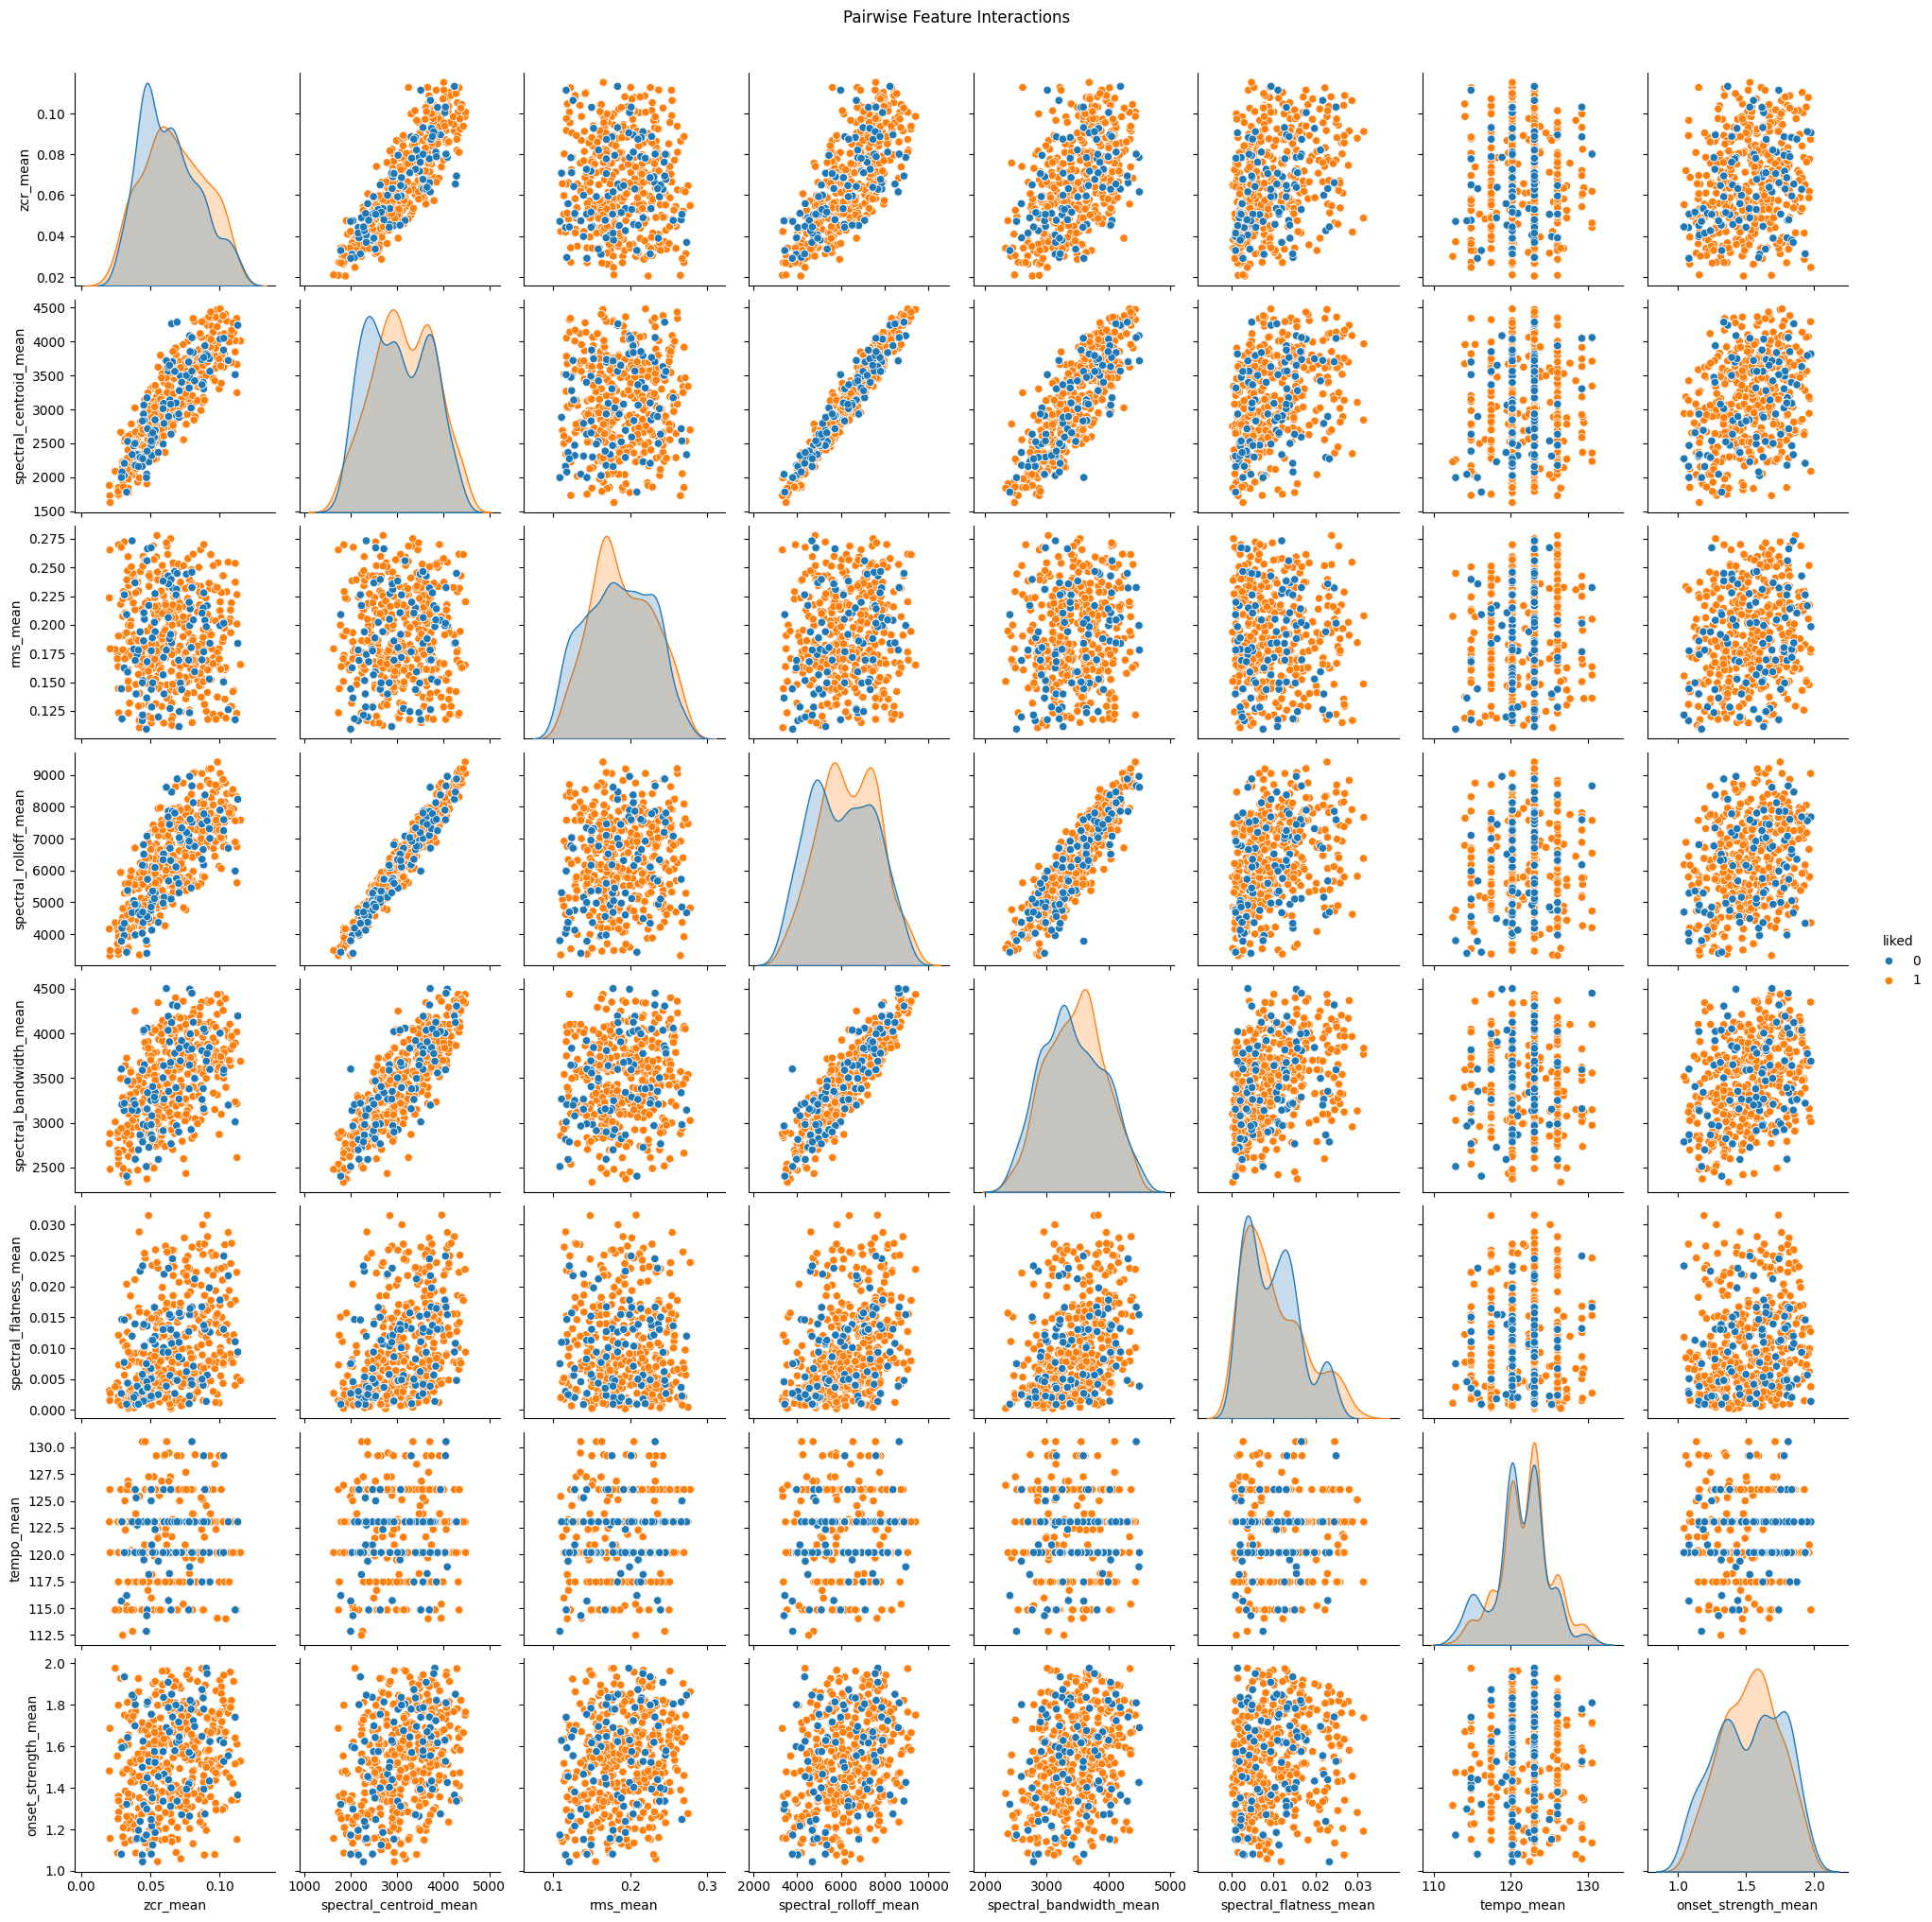

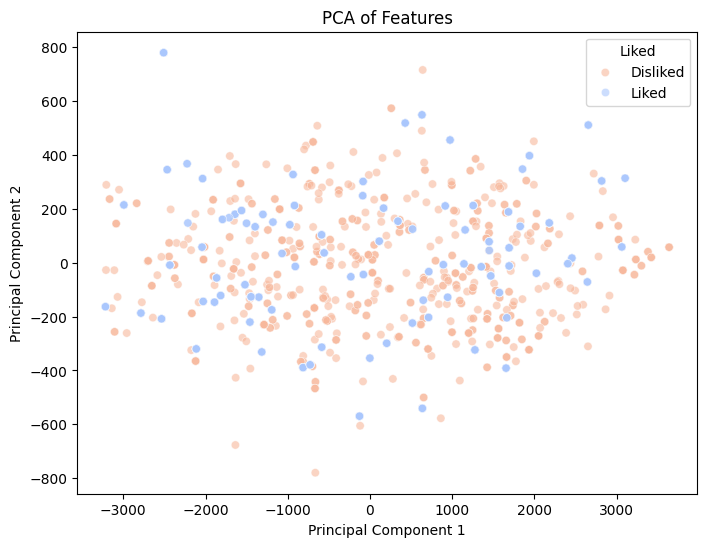

/Users/beenerdy/code/AI&ML/venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


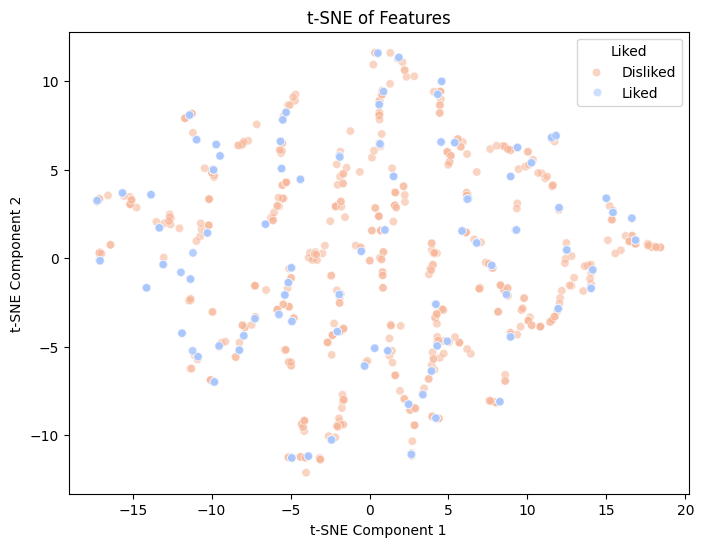

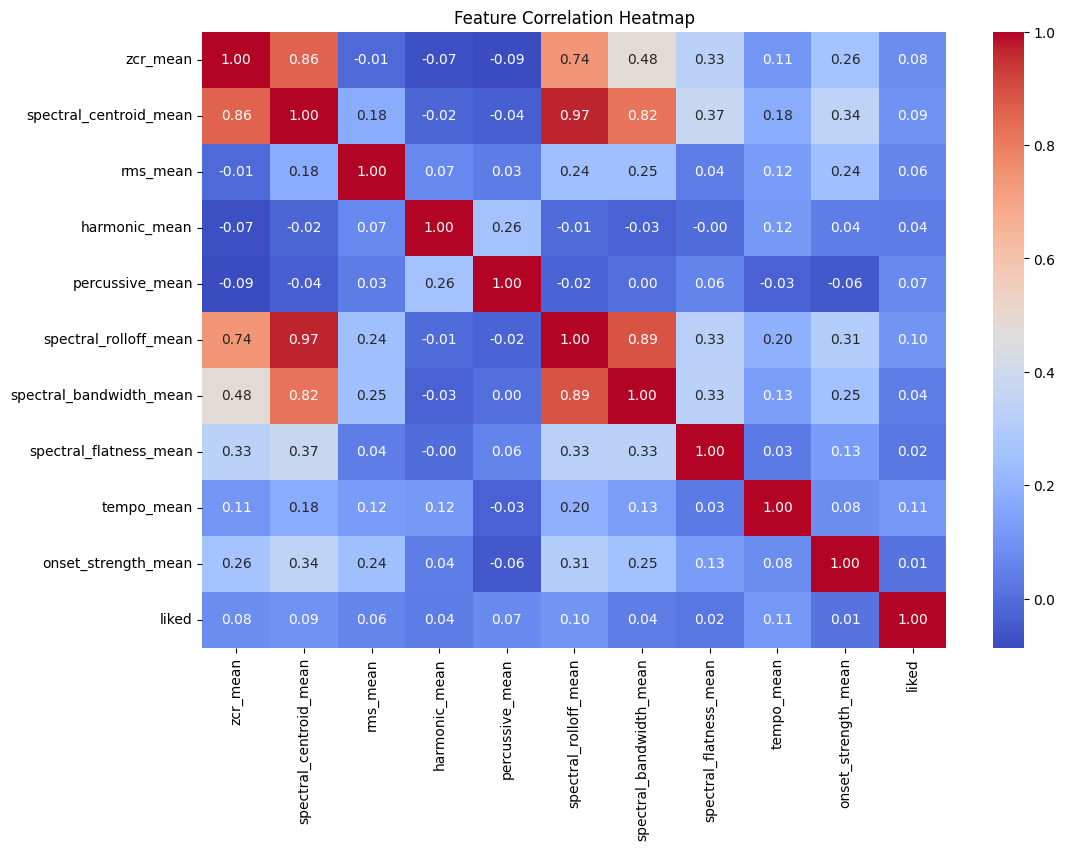

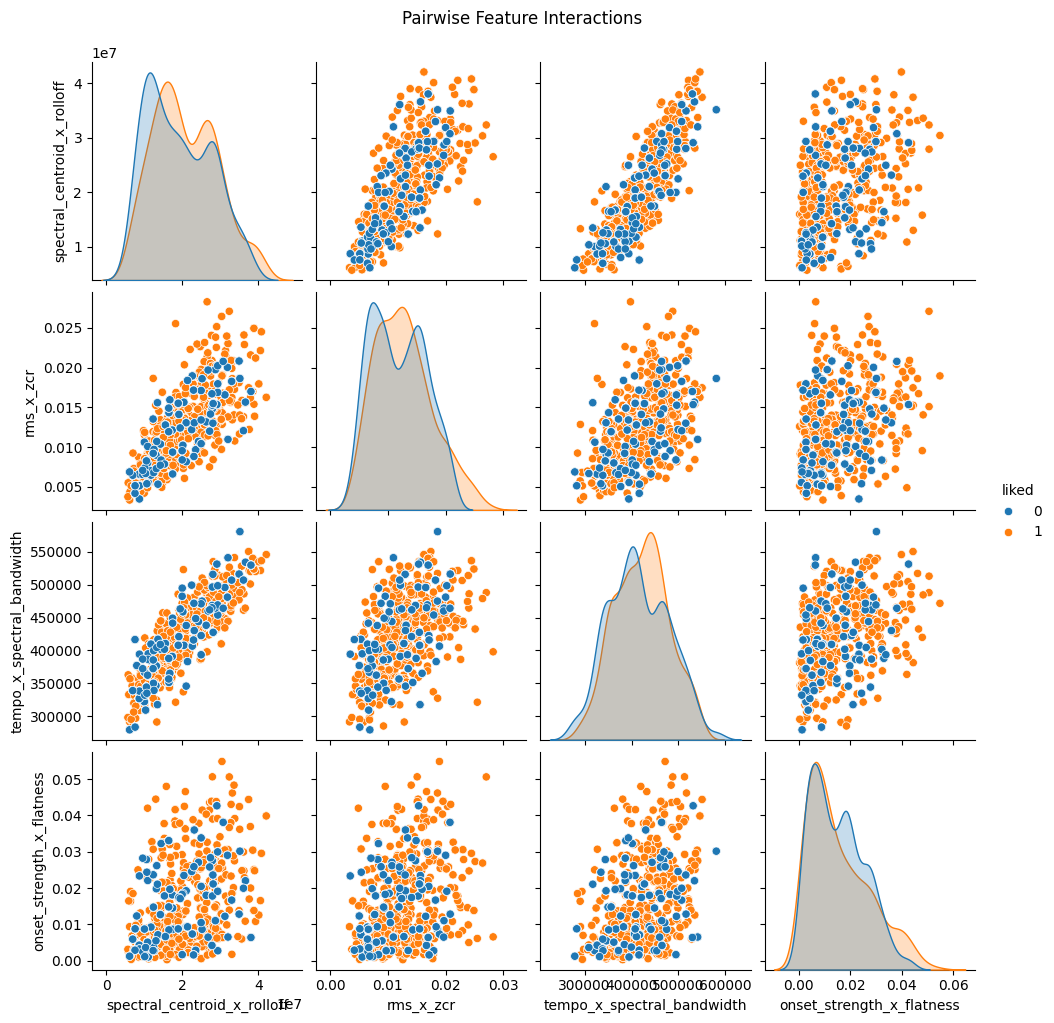

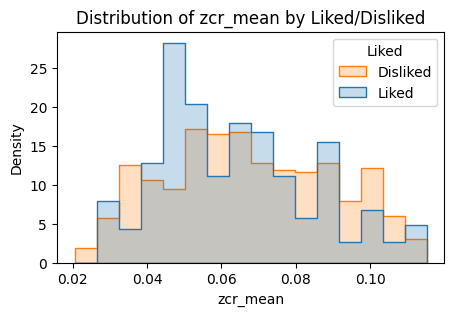

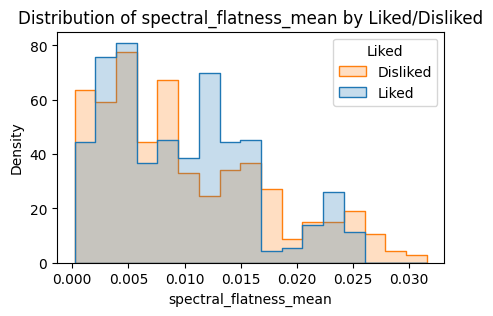

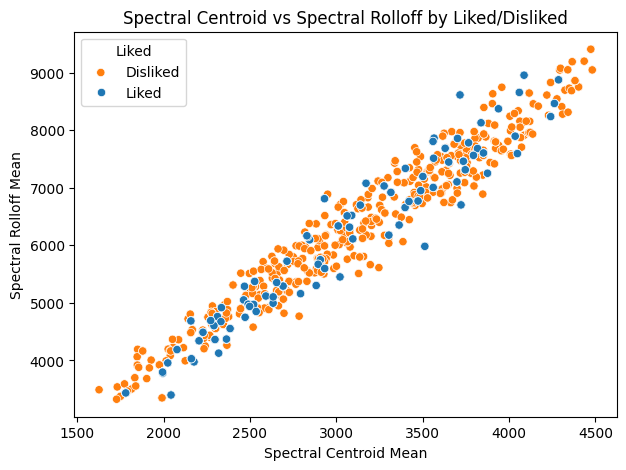

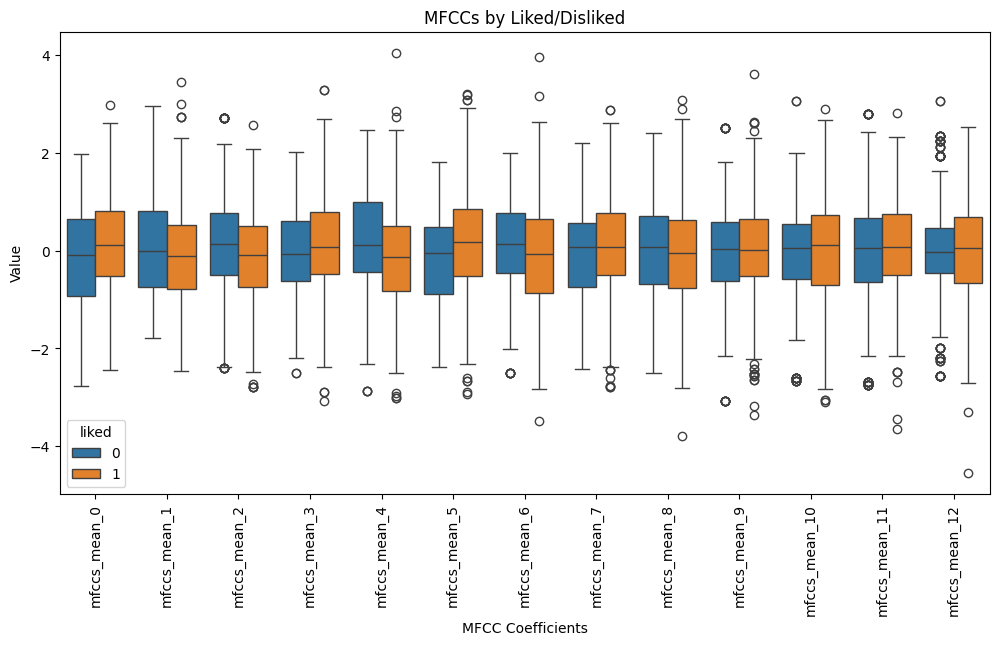

/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/3998615037.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['liked'] = y_balanced_numeric


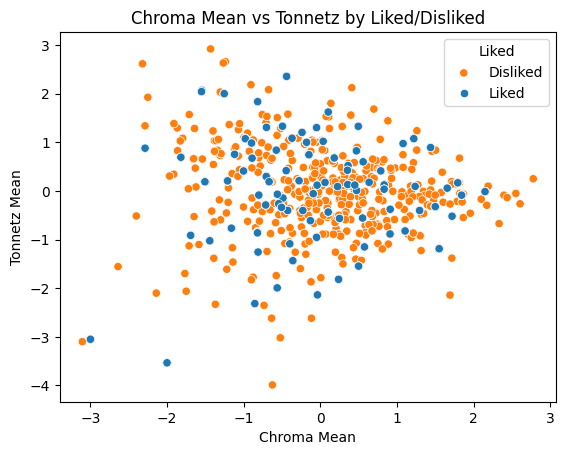

/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/3998615037.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['liked'] = y_balanced_numeric


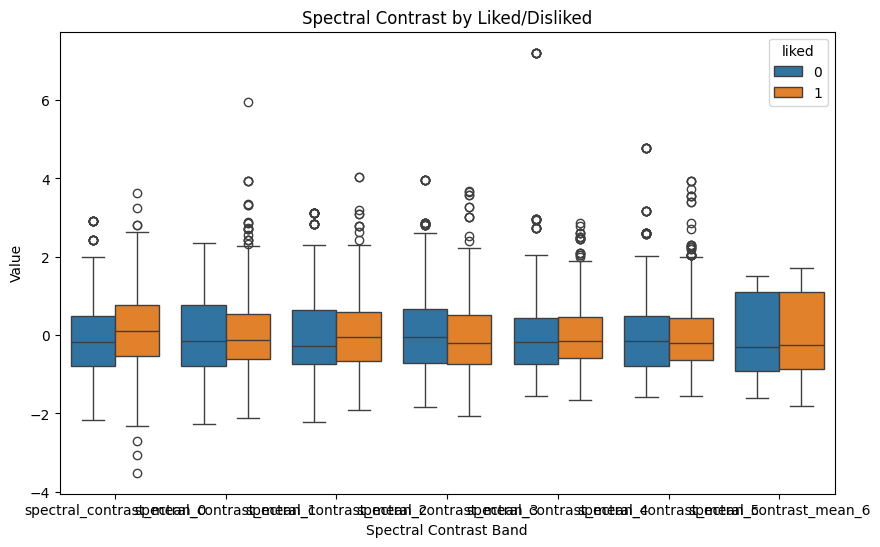

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assume X_static_df, X_time_series_df_scaled, y_balanced_numeric are already defined

# Plot pairwise interactions of selected static features
def plot_pairwise_interactions(features):
    sns.pairplot(X_static_df[features + ['liked']], hue='liked', diag_kind='kde')
    plt.suptitle('Pairwise Feature Interactions', y=1.02)
    plt.show()

# List of static features to analyze
static_features = ['zcr_mean', 'spectral_centroid_mean', 'rms_mean', 'spectral_rolloff_mean', 
                   'spectral_bandwidth_mean', 'spectral_flatness_mean', 'tempo_mean', 'onset_strength_mean']
plot_pairwise_interactions(static_features)

# PCA visualization of combined features
def plot_pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.6)
    plt.title('PCA of Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Liked', labels=['Disliked', 'Liked'])
    plt.show()

# Combine time-series and static features for PCA and t-SNE
combined_features = np.hstack([X_time_series_df_scaled, X_static_df.drop('liked', axis=1)])
plot_pca(combined_features, y_balanced_numeric)

# t-SNE visualization of combined features
def plot_tsne(X, y, perplexity=30, n_iter=300):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='coolwarm', alpha=0.6)
    plt.title('t-SNE of Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Liked', labels=['Disliked', 'Liked'])
    plt.show()

plot_tsne(combined_features, y_balanced_numeric)

# Correlation heatmap of static features
def plot_correlation_heatmap(df, title='Feature Correlation Heatmap'):
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

plot_correlation_heatmap(X_static_df)

# Feature engineering: interaction terms
X_static_df['spectral_centroid_x_rolloff'] = X_static_df['spectral_centroid_mean'] * X_static_df['spectral_rolloff_mean']
X_static_df['rms_x_zcr'] = X_static_df['rms_mean'] * X_static_df['zcr_mean']
X_static_df['tempo_x_spectral_bandwidth'] = X_static_df['tempo_mean'] * X_static_df['spectral_bandwidth_mean']
X_static_df['onset_strength_x_flatness'] = X_static_df['onset_strength_mean'] * X_static_df['spectral_flatness_mean']

# Pairwise interactions of engineered features
interaction_features = ['spectral_centroid_x_rolloff', 'rms_x_zcr', 'tempo_x_spectral_bandwidth', 'onset_strength_x_flatness']
plot_pairwise_interactions(interaction_features)

# Plot histogram for a static feature
def plot_static_histogram(feature_name):
    if feature_name in X_static_df.columns:
        plt.figure(figsize=(5, 3))
        sns.histplot(data=X_static_df, x=feature_name, hue='liked', element='step', stat='density', common_norm=False)
        plt.title(f'Distribution of {feature_name} by Liked/Disliked')
        plt.xlabel(feature_name)
        plt.ylabel('Density')
        plt.legend(title='Liked', labels=['Disliked', 'Liked'])
        plt.show()
    else:
        print(f"Feature '{feature_name}' not found in X_static_df.")

plot_static_histogram('zcr_mean')
plot_static_histogram('spectral_flatness_mean')

# Scatterplot of spectral centroid vs spectral rolloff
def plot_spectral_centroid_vs_rolloff():
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=X_static_df, x='spectral_centroid_mean', y='spectral_rolloff_mean', hue='liked')
    plt.title('Spectral Centroid vs Spectral Rolloff by Liked/Disliked')
    plt.xlabel('Spectral Centroid Mean')
    plt.ylabel('Spectral Rolloff Mean')
    plt.legend(title='Liked', labels=['Disliked', 'Liked'])
    plt.show()

plot_spectral_centroid_vs_rolloff()

# Boxplot of MFCCs by liked/disliked
def plot_mfccs_boxplot():
    plt.figure(figsize=(12, 6))
    mfcc_cols = [f'mfccs_mean_{i}' for i in range(13)]
    data = pd.DataFrame(X_time_series_df_scaled.iloc[:, :len(mfcc_cols)])
    data['liked'] = y_balanced_numeric
    melted_data = pd.melt(data, id_vars='liked', var_name='MFCC Coefficients', value_name='Value')
    sns.boxplot(x='MFCC Coefficients', y='Value', hue='liked', data=melted_data)
    plt.title('MFCCs by Liked/Disliked')
    plt.xticks(rotation=90)
    plt.show()

plot_mfccs_boxplot()

# Scatterplot of Chroma Mean vs Tonnetz
def plot_chroma_vs_tonnetz():
    chroma_cols = [f'chroma_mean_{i}' for i in range(12)]
    tonnetz_cols = [f'tonnetz_mean_{i}' for i in range(6)]
    data = X_time_series_df_scaled[tonnetz_cols + chroma_cols]
    data['liked'] = y_balanced_numeric
    sns.scatterplot(data=data, x=chroma_cols[0], y=tonnetz_cols[0], hue='liked')
    plt.title('Chroma Mean vs Tonnetz by Liked/Disliked')
    plt.xlabel('Chroma Mean')
    plt.ylabel('Tonnetz Mean')
    plt.legend(title='Liked', labels=['Disliked', 'Liked'])
    plt.show()

plot_chroma_vs_tonnetz()

# Boxplot of Spectral Contrast by liked/disliked
def plot_spectral_contrast():
    plt.figure(figsize=(10, 6))
    spectral_contrast_cols = [f'spectral_contrast_mean_{i}' for i in range(7)]
    data = X_time_series_df_scaled[spectral_contrast_cols]
    data['liked'] = y_balanced_numeric
    melted_data = pd.melt(data, id_vars='liked', var_name='Spectral Contrast Band', value_name='Value')
    sns.boxplot(x='Spectral Contrast Band', y='Value', hue='liked', data=melted_data)
    plt.title('Spectral Contrast by Liked/Disliked')
    plt.show()

plot_spectral_contrast()

# Initial correlation heatmap of static features
corr_matrix = plot_correlation_heatmap(X_static_df, title='Initial Feature Correlation Heatmap')


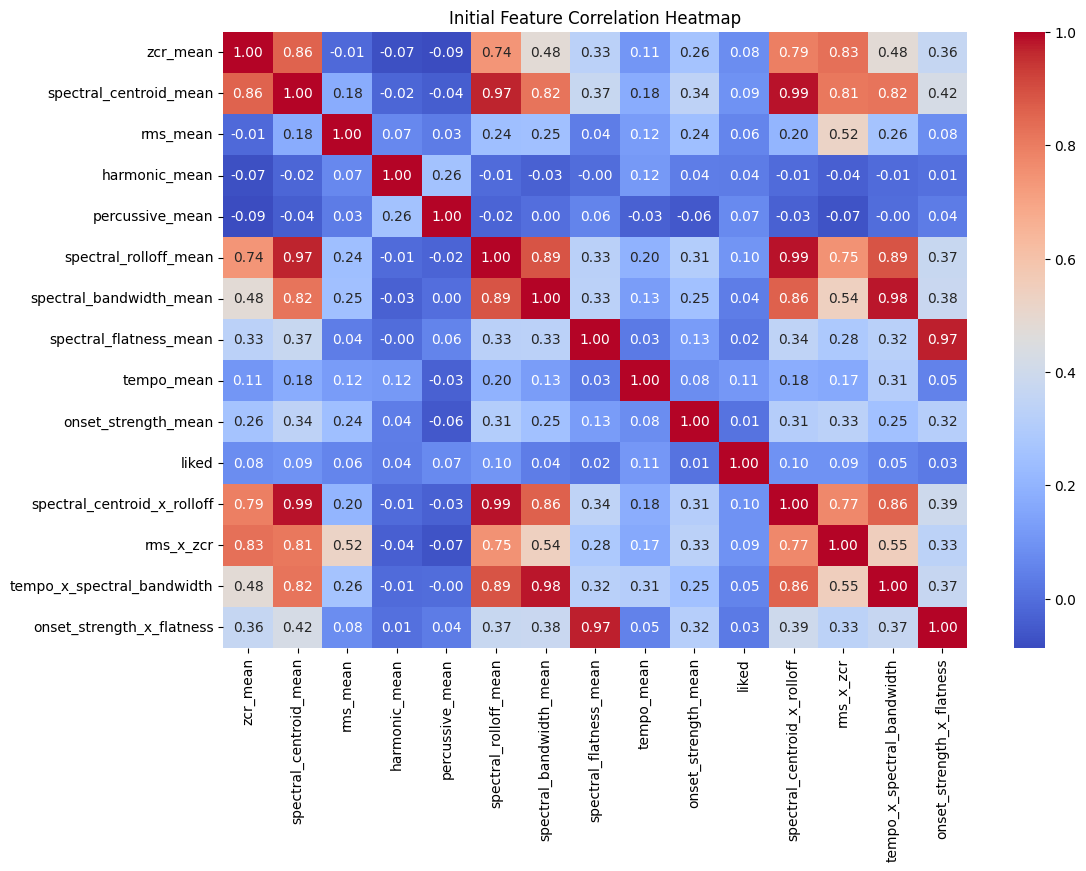

## Train the Model

In [21]:
def preprocess_feature(feature, method):
    if method == 'log1p':
        return np.log1p(feature)
    elif method == 'normalize':
        scaler = MinMaxScaler()
        return scaler.fit_transform(feature.reshape(-1, 1)).flatten()
    elif method == 'standardize':
        scaler = StandardScaler()
        return scaler.fit_transform(feature.reshape(-1, 1)).flatten()
    return feature

def separate_and_process_features(entry, pca_components=None):
    # Access the key and the corresponding feature dictionary
    hash_key = list(entry.keys())[0]
    features = entry[hash_key]  # Access the first element of the tuple which is the features dictionary
    
    # Define the preprocessing methods for each feature
    preprocessing_methods = {
        'mfccs_mean': 'standardize',
        'chroma_mean': 'normalize',
        'spectral_contrast_mean': 'normalize',
        'tonnetz_mean': 'normalize',
        'zcr_mean': None,  # No preprocessing for this feature
        'spectral_centroid_mean': 'standardize',
        'rms_mean': 'log1p',
        'harmonic_mean': 'standardize',
        'percussive_mean': 'standardize',
        #'spectral_rolloff_mean': 'log1p', removed because highly correlated
        #'spectral_bandwidth_mean': 'standardize', removed because highly correlated
        'spectral_flatness_mean': 'normalize',
        'tempo_mean': None,  # No preprocessing for this feature
        'onset_strength_mean': 'normalize'
    }
    
    # Prepare lists for processed time-series and static features
    time_series_features_list = []
    static_features_list = []
    
    # Feature sets
    time_series_keys = ['mfccs_mean', 'chroma_mean', 'spectral_contrast_mean', 'tonnetz_mean']
    static_keys = ['zcr_mean', 'spectral_centroid_mean', 'rms_mean', 'harmonic_mean',
                   'percussive_mean',
                   'spectral_flatness_mean', 'tempo_mean', 'onset_strength_mean']
    
    # Process time-series features
    for key in time_series_keys:
        feature = np.array(features[key])
        method = preprocessing_methods[key]
        processed_feature = preprocess_feature(feature, method)
        time_series_features_list.append(processed_feature)
    
    # Process static features
    for key in static_keys:
        feature = np.array(features[key]).reshape(-1, 1)
        method = preprocessing_methods[key]
        processed_feature = preprocess_feature(feature, method)
        static_features_list.append(processed_feature.flatten())
    
    # Concatenate processed time-series features
    time_series_features = np.concatenate(time_series_features_list)
    
    # Apply PCA (optional) to time-series features
    if pca_components:
        pca = PCA(n_components=pca_components)
        time_series_features = pca.fit_transform(time_series_features.reshape(1, -1)).flatten()
    
    # Concatenate processed static features
    static_features = np.concatenate(static_features_list)
    
    return time_series_features, static_features


In [22]:
print(y_balanced[:2])
print(X_static_df[:1])

print(X_balanced[:1])

[{'77987d4d51c187f64ebfd61818dc7d85': 'liked'}, {'cec62e3ff573c9936b560bfde842e8f4': 'liked'}]
   zcr_mean  spectral_centroid_mean  rms_mean  harmonic_mean  percussive_mean  \
0   0.06963              2922.19471  0.224866      -0.000004         -0.00005   

   spectral_rolloff_mean  spectral_bandwidth_mean  spectral_flatness_mean  \
0            5763.493665              3089.023569                0.014823   

   tempo_mean  onset_strength_mean  liked  spectral_centroid_x_rolloff  \
0  129.199219             1.208958      1                 1.684205e+07   

   rms_x_zcr  tempo_x_spectral_bandwidth  onset_strength_x_flatness  
0   0.015657               399099.431852                    0.01792  
[{'77987d4d51c187f64ebfd61818dc7d85': {'mfccs_mean': [-177.2037353515625, 121.65619659423828, -27.70580291748047, 47.30412292480469, -1.2183011770248413, 17.45047378540039, -11.139482498168945, 8.58388614654541, -5.363067150115967, -3.3852100372314453, -4.5780181884765625, -2.8449654579162598, -1.

In [23]:
def remove_highly_correlated_features(X_balanced, y_balanced, threshold=0.9):
    combined_data = []
    
    # Prepare data with only key: scalar (numerical) pairs
    for data in X_balanced:
        key = list(data.keys())[0]
        scalar_data = {k: v for k, v in data[key].items() if np.isscalar(v)}  # Extract only scalar (numeric) data
        df = pd.DataFrame([scalar_data])
        if not df.empty:
            combined_data.append(df)
    
    if not combined_data:
        raise ValueError("No scalar data available after filtering. Please check your input data.")

    combined_df = pd.concat(combined_data, ignore_index=True)

    # Ensure we're only working with numeric columns
    numeric_df = combined_df.select_dtypes(include=[np.number])

    corr_matrix = numeric_df.corr().abs()
    print(f"Correlation matrix:\n{corr_matrix}")
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Columns to drop due to high correlation: {to_drop}")

    X_balanced_new = []
    for data in X_balanced:
        key = list(data.keys())[0]
        features = data[key]
        
        # Retain all original features, but drop highly correlated scalar ones
        reduced_data = {k: v for k, v in features.items() if k not in to_drop}
        reduced_data_dict = {key: reduced_data}
        X_balanced_new.append(reduced_data_dict)

    return X_balanced_new, y_balanced

In [24]:
print(X_balanced[:1])
print(y_balanced[:1])

[{'77987d4d51c187f64ebfd61818dc7d85': {'mfccs_mean': [-177.2037353515625, 121.65619659423828, -27.70580291748047, 47.30412292480469, -1.2183011770248413, 17.45047378540039, -11.139482498168945, 8.58388614654541, -5.363067150115967, -3.3852100372314453, -4.5780181884765625, -2.8449654579162598, -1.682321310043335], 'chroma_mean': [0.4997071325778961, 0.4737038016319275, 0.4809979200363159, 0.4613935351371765, 0.4505871534347534, 0.4587819576263428, 0.5472944974899292, 0.8144602179527283, 0.6534591913223267, 0.46650829911231995, 0.45064008235931396, 0.47333288192749023], 'spectral_contrast_mean': [20.757722679634256, 10.088754958892832, 16.595765170044572, 17.288996803150468, 15.517178328754587, 17.683084505748404, 34.478041426578585], 'zcr_mean': 0.06962988394606065, 'spectral_centroid_mean': 2922.1947099081062, 'rms_mean': 0.22486573457717896, 'harmonic_mean': -3.7362449347710935e-06, 'percussive_mean': -5.010830136598088e-05, 'spectral_rolloff_mean': 5763.493665096308, 'tonnetz_mean':

In [25]:
X_balanced_new, y_balanced_new = remove_highly_correlated_features(X_balanced, y_balanced, threshold=0.9)

Correlation matrix:
                         zcr_mean  spectral_centroid_mean  rms_mean  \
zcr_mean                 1.000000                0.858227  0.012945   
spectral_centroid_mean   0.858227                1.000000  0.176544   
rms_mean                 0.012945                0.176544  1.000000   
harmonic_mean            0.073790                0.020883  0.066686   
percussive_mean          0.086428                0.040714  0.033953   
spectral_rolloff_mean    0.739246                0.968964  0.244448   
spectral_bandwidth_mean  0.479662                0.818869  0.246185   
spectral_flatness_mean   0.329971                0.372178  0.039121   
tempo_mean               0.105840                0.175616  0.121765   
onset_strength_mean      0.260049                0.340087  0.242863   

                         harmonic_mean  percussive_mean  \
zcr_mean                      0.073790         0.086428   
spectral_centroid_mean        0.020883         0.040714   
rms_mean             

In [26]:
# print(X_balanced_new[:1])

In [27]:
X_time_series = []
X_static = []
labels = []  # List of labels, matching the structure of `y`

for feature_dict in X_balanced_new:
    for file_hash, features in feature_dict.items():
        time_series_features, static_features = separate_and_process_features({file_hash: features})
        X_time_series.append(time_series_features)
        X_static.append(static_features)
        # Find the corresponding label using the file_hash in `y`
        label = next((label_dict[file_hash] for label_dict in y_balanced_new if file_hash in label_dict), None)
        labels.append(label)

In [28]:

# Convert lists to numpy arrays
X_time_series = np.array(X_time_series)
X_static = np.array(X_static)
labels = np.array(labels)

In [29]:
print(y_balanced_new[:1])

[{'77987d4d51c187f64ebfd61818dc7d85': 'liked'}]


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
import numpy as np

# Function for cross-validation
def cross_validate_model(model_func, X_time_series, X_static, y, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_roc_aucs = []

    for train_index, val_index in kfold.split(X_time_series):
        X_ts_train, X_ts_val = X_time_series[train_index], X_time_series[val_index]
        X_static_train, X_static_val = X_static[train_index], X_static[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Get model from model_func
        model = model_func()

        # Early stopping callback to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model
        model.fit(
            [X_ts_train, X_static_train], y_train,
            epochs=100, batch_size=32,
            validation_data=([X_ts_val, X_static_val], y_val),
            callbacks=[early_stopping],
            verbose=0  # Suppress output for readability
        )

        # Evaluate the model
        preds = model.predict([X_ts_val, X_static_val])
        preds_binary = (preds > 0.5).astype(int)
        accuracy = accuracy_score(y_val, preds_binary)
        roc_auc = roc_auc_score(y_val, preds)

        fold_accuracies.append(accuracy)
        fold_roc_aucs.append(roc_auc)

    return np.mean(fold_accuracies), np.mean(fold_roc_aucs)

In [31]:
print(X_time_series[:1])

[[-2.81718517e+00  2.01831780e+00 -3.98333996e-01  8.15313873e-01
   3.02292864e-02  3.32286897e-01 -1.30293744e-01  1.88827014e-01
  -3.68323236e-02 -4.83093122e-03 -2.41303646e-02  3.91013438e-03
   2.27215194e-02  1.34992073e-01  6.35294295e-02  8.35752068e-02
   2.96982183e-02  0.00000000e+00  2.25210520e-02  2.65772198e-01
   1.00000000e+00  5.57535189e-01  4.37546695e-02  1.45459859e-04
   6.25100638e-02  4.37444848e-01  0.00000000e+00  2.66797892e-01
   2.95221504e-01  2.22574095e-01  3.11379735e-01  1.00000000e+00
   0.00000000e+00  1.00000000e+00  7.51361295e-01  8.97696201e-01
   1.99613441e-01  1.48468176e-01]]


In [32]:
num_segments = 4
features_per_segment = X_time_series.shape[1] // num_segments

# Adjust features_per_segment to use 9 features per segment
X_time_series_truncated = X_time_series[:, :num_segments * features_per_segment]  # Truncate to 36 features
X_time_series_reshaped = X_time_series_truncated.reshape((X_time_series.shape[0], num_segments, features_per_segment))

print("Reshaped X_time_series:", X_time_series_reshaped.shape)


Reshaped X_time_series: (1244, 4, 9)


In [33]:

print(f"Length of X_time_series_reshaped: {len(X_time_series_reshaped)}")
print(f"Length of X_static: {len(X_static)}")


Length of X_time_series_reshaped: 1244
Length of X_static: 1244


In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# Train-test split
X_ts_train, X_ts_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_time_series_reshaped, X_static, labels, test_size=0.2, random_state=42
)

# Define the shapes for input
time_series_shape = (X_time_series_reshaped.shape[1], X_time_series_reshaped.shape[2])
static_shape = (X_static.shape[1],)

import numpy as np

# Ensure X_ts_train, X_static_train, X_ts_test, X_static_test are numpy arrays of type float32
X_ts_train = np.array(X_ts_train, dtype=np.float32)
X_ts_test = np.array(X_ts_test, dtype=np.float32)
X_static_train = np.array(X_static_train, dtype=np.float32)
X_static_test = np.array(X_static_test, dtype=np.float32)

# Check and convert y_train and y_test to numeric values if they are categorical strings
if y_train.dtype.kind in {'U', 'S'}:  # U and S indicate unicode and string types
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(y_train).astype(np.float32)  # Convert to float32
    y_test = le.transform(y_test).astype(np.float32)  # Convert to float32


print(y_train[:3])



[1. 0. 0.]


In [43]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf

from tensorflow.keras import layers, models, Input
import tensorflow as tf

def create_combined_model(time_series_shape, static_shape):
    # Time-Series Model
    time_series_input = Input(shape=time_series_shape, name='time_series_input')
    x = layers.Conv1D(filters=32, kernel_size=3, padding='same')(time_series_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(filters=128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Adding Residual Connection
    residual = layers.Conv1D(filters=128, kernel_size=1, padding='same')(time_series_input)
    x = layers.add([x, residual])
    x = layers.LeakyReLU()(x)
    
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.LayerNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x = layers.LayerNormalization()(x)

    # Extended Attention Mechanism
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    attention = layers.LayerNormalization()(attention)
    x = layers.GlobalAveragePooling1D()(attention)

    time_series_output = layers.Dense(32, activation='relu')(x)

    # Static Features Model
    static_input = Input(shape=static_shape, name='static_input')
    y = layers.Dense(128)(static_input)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(64)(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(32)(y)
    static_output = layers.LeakyReLU()(y)

    # Combine Time-Series and Static Features
    combined = layers.concatenate([time_series_output, static_output])
    combined = layers.Dense(128)(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.LeakyReLU()(combined)
    combined = layers.Dropout(0.5)(combined)
    combined_output = layers.Dense(1, activation='sigmoid')(combined)

    model = models.Model(inputs=[time_series_input, static_input], outputs=combined_output)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001, weight_decay=1e-5), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model


In [44]:
print(X_ts_train[:1])
print(X_static_train[:1])
print(y_train[:1])

[[[-2.8805544   1.8884283  -0.16651994  0.6869056  -0.3952012
    0.54055285 -0.14670661  0.27559298 -0.05527181]
  [ 0.2233776  -0.03672823  0.16408421 -0.09795943  0.44841903
    0.02309883  0.          0.0316236   0.5079129 ]
  [ 0.1006114   0.0128401   0.32650855  0.16889434  0.57332104
    0.29136768  1.          0.16615522  0.        ]
  [ 0.05259923  0.1025947   0.09092622  0.07944965  1.
    1.          0.33077964  0.16145392  0.43842146]]]
[[8.8705868e-02 0.0000000e+00 2.3900503e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.2604802e+02 0.0000000e+00]]
[1.]


In [46]:
# Train and evaluate the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

combined_model = create_combined_model(time_series_shape, static_shape)

history = combined_model.fit(
    [X_ts_train, X_static_train], y_train,
    epochs=64, batch_size=8,
    validation_data=([X_ts_test, X_static_test], y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_preds = combined_model.predict([X_ts_test, X_static_test])

# Convert predictions to binary labels
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate accuracy and ROC AUC score
test_accuracy = accuracy_score(y_test, test_preds_binary)
test_roc_auc = roc_auc_score(y_test, test_preds)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')

# Convert predictions to percentage likelihoods
test_preds_percent = test_preds * 100

# Optionally print out some examples
for i in range(5):  # Show the first 5 predictions
    print(f"Song {i+1}: Predicted likelihood of liking: {test_preds_percent[i][0]:.2f}%")


Epoch 1/64
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5244 - loss: 0.8842 - val_accuracy: 0.4779 - val_loss: 0.7075
Epoch 2/64
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5137 - loss: 0.8236 - val_accuracy: 0.5382 - val_loss: 0.6909
Epoch 3/64
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5329 - loss: 0.8935 - val_accuracy: 0.5462 - val_loss: 0.6755
Epoch 4/64
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5517 - loss: 0.8062 - val_accuracy: 0.6064 - val_loss: 0.6534
Epoch 5/64
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5845 - loss: 0.7558 - val_accuracy: 0.6586 - val_loss: 0.6375
Epoch 6/64
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5712 - loss: 0.7722 - val_accuracy: 0.6787 - val_loss: 0.6235
Epoch 7/64
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6003 - loss: 0.7505 - val_accuracy: 0.6827 - val_loss: 0.6131
Epoch 8/64
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5981 - loss: 0.7500 - val_accuracy: 0.

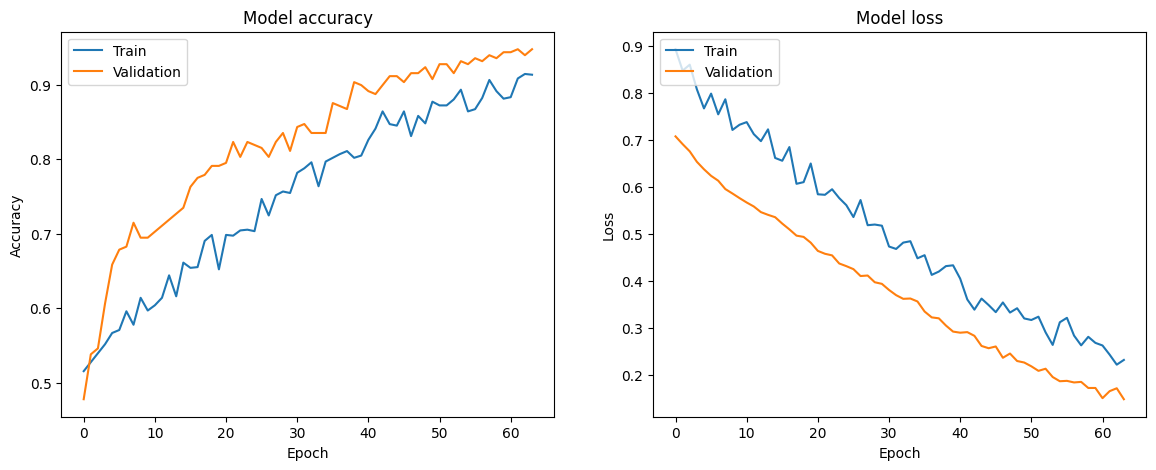

In [47]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [48]:
import logging
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
from mutagen import File
import warnings
import xml.etree.ElementTree as ET
from urllib.parse import unquote
from datetime import datetime
from xml.dom import minidom

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Suppress warnings from third-party libraries
warnings.filterwarnings("ignore", category=UserWarning, module='librosa')
warnings.filterwarnings("ignore", category=FutureWarning, module='librosa')

# Existing functions to parse XML and process it
def parse_dict(element):
    result = {}
    iterator = iter(element)
    for child in iterator:
        if child.tag == 'key':
            key = child.text
            try:
                value = next(iterator)
                if value.tag == 'integer':
                    result[key] = int(value.text) if '.' not in value.text else float(value.text)
                elif value.tag == 'string':
                    result[key] = value.text
                elif value.tag == 'true':
                    result[key] = True
                elif value.tag == 'false':
                    result[key] = False
                elif value.tag == 'dict':
                    result[key] = parse_dict(value)
                elif value.tag == 'array':
                    result[key] = parse_array(value)
            except StopIteration:
                break
    return result

def parse_array(element):
    result = []
    for child in element:
        if child.tag == 'dict':
            result.append(parse_dict(child))
        elif child.tag == 'array':
            result.append(parse_array(child))
        elif child.tag == 'integer':
            result.append(int(child.text))
        elif child.tag == 'string':
            result.append(child.text)
    return result

def process_input(input_object):
    playlists = []

    for playlist_data in input_object.get("Playlists", []):
        playlist = {
            "Name": playlist_data.get("Name"),
            "Description": playlist_data.get("Description"),
            "Playlist ID": playlist_data.get("Playlist ID"),
            "Playlist Persistent ID": playlist_data.get("Playlist Persistent ID"),
            "Playlist Items": []
        }

        for playlist_item in playlist_data.get("Playlist Items", []):
            track_id = playlist_item.get("Track ID")
            if str(int(track_id)) in input_object.get("Tracks", {}):
                track_data = input_object["Tracks"][str(int(track_id))]
                playlist_item.update(track_data)
                playlist["Playlist Items"].append(playlist_item)

        playlists.append(playlist)

    return playlists

# New combined parse function
def parse_and_extract_xml(file_path, start_index=0):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Convert the XML structure to a dictionary using the existing parse_dict function
    itunes_library = parse_dict(root)
    # Process the dictionary to extract playlists and tracks using the existing process_input function
    playlists = process_input(itunes_library)
    
    # Initialize the song paths and json_data
    song_paths = []
    json_data = {
        "Playlist Name": "Imported Playlist",
        "Playlist Items": []
    }
    
    # Extract track details and paths
    for playlist in playlists:
        for track in playlist['Playlist Items']:
            location = track.get('Location')
            if location:
                # Decode the URL-encoded path and remove 'file://'
                song_path = unquote(location.replace('file://', ''))
                song_paths.append(song_path)
                
                # Add track details to json_data
                json_data['Playlist Items'].append(track)

    # Return the paths starting from the specified index and the constructed json_data
    return song_paths, json_data

def filter_json_data_by_paths(play_list_name, json_data, song_paths):
    song_paths_set = set(song_paths)
    
    filtered_json_data = {
        "Playlist Name": play_list_name,
        "Playlist Items": []
    }

    print(json_data["Playlist Items"])
    
    for item in json_data["Playlist Items"]:
        if 'Location' in item and item['Location'] in song_paths_set:
            filtered_json_data["Playlist Items"].append(item)
    
    return filtered_json_data

def create_xml_playlist(json_data, output_file):
    plist = ET.Element("plist")
    plist.set("version", "1.0")

    dict_node = ET.SubElement(plist, "dict")

    # Add static keys and values
    keys_values = {
        "Major Version": 1,
        "Minor Version": 1,
        "Application Version": "1.3.4.56",
        "Features": 5,
        "Show Content Ratings": True
    }

    for key, value in keys_values.items():
        key_node = ET.SubElement(dict_node, "key")
        key_node.text = key

        if isinstance(value, bool):
            value_node = ET.SubElement(dict_node, "true" if value else "false")
        elif isinstance(value, int):
            value_node = ET.SubElement(dict_node, "integer")
            value_node.text = str(value)
        elif isinstance(value, str):
            value_node = ET.SubElement(dict_node, "string")
            value_node.text = value

    # Add tracks
    tracks_node = ET.SubElement(dict_node, "key")
    tracks_node.text = "Tracks"
    tracks_dict_node = ET.SubElement(dict_node, "dict")

    print(json_data)
    for item in json_data["Playlist Items"]:
        track_id = item["Track ID"]
        key_node = ET.SubElement(tracks_dict_node, "key")
        key_node.text = str(track_id)
        track_dict_node = ET.SubElement(tracks_dict_node, "dict")

        for key, value in item.items():
            if key == "Track ID":
                continue

            key_node = ET.SubElement(track_dict_node, "key")
            key_node.text = key

            if isinstance(value, bool):
                value_node = ET.SubElement(track_dict_node, "true" if value else "false")
            elif isinstance(value, int):
                value_node = ET.SubElement(track_dict_node, "integer")
                value_node.text = str(value)
            elif isinstance(value, str):
                value_node = ET.SubElement(track_dict_node, "string")
                value_node.text = value
            elif isinstance(value, datetime):
                value_node = ET.SubElement(track_dict_node, "date")
                value_node.text = value.strftime("%Y-%m-%dT%H:%M:%SZ")

    # Add playlists
    playlists = ET.SubElement(dict_node, "key")
    playlists.text = "Playlists"
    playlists_array = ET.SubElement(dict_node, "array")
    playlist_dict = ET.SubElement(playlists_array, "dict")

    playlist_name = ET.SubElement(playlist_dict, "key")
    playlist_name.text = "Name"
    playlist_name_value = ET.SubElement(playlist_dict, "string")
    playlist_name_value.text = json_data["Playlist Name"]

    all_items = ET.SubElement(playlist_dict, "key")
    all_items.text = "All Items"
    all_items_value = ET.SubElement(playlist_dict, "true")

    playlist_items = ET.SubElement(playlist_dict, "key")
    playlist_items.text = "Playlist Items"
    playlist_items_array = ET.SubElement(playlist_dict, "array")

    for item in json_data["Playlist Items"]:
        track_id = str(item["Track ID"])
        playlist_item_dict = ET.SubElement(playlist_items_array, "dict")
        track_id_key = ET.SubElement(playlist_item_dict, "key")
        track_id_key.text = "Track ID"
        track_id_value = ET.SubElement(playlist_item_dict, "integer")
        track_id_value.text = track_id

    # Convert the XML tree to a string
    xml_string = ET.tostring(plist, encoding="utf-8", method="xml")
    dom = minidom.parseString(xml_string)
    pretty_xml = dom.toprettyxml(indent="    ")

    # Write the pretty XML string to the output file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(pretty_xml)

In [49]:
import logging
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
from mutagen import File
import warnings

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Suppress warnings from third-party libraries
warnings.filterwarnings("ignore", category=UserWarning, module='librosa')
warnings.filterwarnings("ignore", category=FutureWarning, module='librosa')

def extract_metadata(file_path):
    """
    Extracts metadata from the audio file.
    
    Args:
        file_path (str): Path to the audio file.
    
    Returns:
        dict: A dictionary containing metadata (title, artist, album, etc.)
    """
    metadata = {
        'Title': 'Unknown',
        'Artist': 'Unknown',
        'Album': 'Unknown',
        'File Path': file_path
    }
    
    try:
        audio_file = File(file_path)
        if audio_file:
            metadata['Title'] = audio_file.tags.get('TIT2', 'Unknown')
            metadata['Artist'] = audio_file.tags.get('TPE1', 'Unknown')
            metadata['Album'] = audio_file.tags.get('TALB', 'Unknown')
    except Exception as e:
        logging.warning(f"Could not extract metadata for {file_path}: {e}")
    
    return metadata

def process_new_songs(xml_file_path, features_cache, model, num_segments=4, max_tracks=None):
    # Use the new parse_and_extract_xml function
    song_paths, json_data = parse_and_extract_xml(xml_file_path)

    print(song_paths[:2])
    if max_tracks is not None:
        song_paths = song_paths[:max_tracks]
    
    results = []
    
    logging.info(f"Starting processing of {len(song_paths)} tracks.")
    
    liked_songs = []
    disliked_songs = []
    
    for song_path in tqdm(song_paths, desc="Processing new songs", unit="song"):
        if os.path.exists(song_path):
            metadata = extract_metadata(song_path)
            file_hash = generate_hash(song_path)
            
            features = extract_features(song_path, check_cache=False)
            if features is not None:
                features_cache[file_hash] = features
            
            if features is not None:
                time_series_features, static_features = separate_and_process_features({file_hash: features})
                features_per_segment = time_series_features.shape[0] // num_segments
                time_series_truncated = time_series_features[:num_segments * features_per_segment]
                time_series_reshaped = time_series_truncated.reshape((1, num_segments, features_per_segment))
                static_features = np.array(static_features).reshape(1, -1)
                
                if time_series_reshaped.shape != (1, num_segments, features_per_segment):
                    logging.warning(f"Skipping {song_path}: Unexpected time-series shape {time_series_reshaped.shape}.")
                    continue
                if static_features.shape[0] != 1:
                    logging.warning(f"Skipping {song_path}: Unexpected static features shape {static_features.shape}.")
                    continue
                
                try:
                    prediction = model.predict([time_series_reshaped, static_features])[0][0]
                    prediction_percentage = prediction * 100
                    metadata['Prediction'] = f"{prediction_percentage:.2f}%"
                    results.append(metadata)
                    logging.info(f"{song_path}: {prediction_percentage:.2f}%")
                    
                    if prediction_percentage > 49:
                        liked_songs.append(song_path)
                    else:
                        disliked_songs.append(song_path)
                        
                except ValueError as ve:
                    logging.error(f"Error encountered while processing {song_path}: {ve}. Skipping song.")
                except Exception as e:
                    logging.error(f"Prediction error for {song_path}: {e}. Skipping song.")
        else:
            logging.warning(f"File not found: {song_path}")
    
    logging.info("Processing completed.")
    
    # Convert results to a DataFrame for better visualization
    df_results = pd.DataFrame(results)
    
    return df_results, json_data

In [ ]:
# Example usage:
predictions_df, json_data = process_new_songs('./data/to_process.xml', features_cache, combined_model)

2024-09-05 13:56:50 - INFO - Starting processing of 1408 tracks.


['/Users/beenerdy/Music/Lexicon/Uploaded/Sirius 2017(Disco Demolition Remix) [Audio]-The Alan Parsons Project .mp3', '/Users/beenerdy/Music/Lexicon/Uploaded/Are We Here-AudioJack.mp3']


Processing new songs:   0%|                       | 0/1408 [00:00<?, ?song/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 13:56:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sirius 2017(Disco Demolition Remix) [Audio]-The Alan Parsons Project .mp3: 90.07%
Processing new songs:   0%|             | 1/1408 [00:07<2:51:54,  7.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 13:57:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Are We Here-AudioJack.mp3: 98.81%
Processing new songs:   0%|             | 2/1408 [00:15<3:00:07,  7.69s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 13:57:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bedouin Dance (DJ Tool)-Aunn & Ywon Recha.aiff: 99.32%
Processing new songs:   0%|             | 3/1408 [00:23<3:00:50,  7.72s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 13:57:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ava Asante, Mollono.Bass - Turn A Light On (Original Mix)-Ava Asante, Mollono.Bass - Turn A Light On (Original Mix).mp3: 72.10%
Processing new songs:   0%|             | 4/1408 [00:30<2:59:48,  7.68s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 13:57:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ray-Avoure.mp3: 93.65%
Processing new songs:   0%|             | 5/1408 [00:39<3:08:54,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


2024-09-05 13:57:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/No Way to Lose (Slow Hearts Remix)-Awka & Edu Schwartz.aiff: 95.29%
Processing new songs:   0%|             | 6/1408 [00:47<3:08:48,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 13:57:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Eyes Of My Mind-Axel Boman.mp3: 69.37%
Processing new songs:   0%|             | 7/1408 [00:56<3:12:47,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 13:57:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Retro Camel-Axel Rey.mp3: 95.90%
Processing new songs:   1%|             | 8/1408 [01:04<3:10:21,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 13:58:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sola Snur (Original Mix)-Ayo.aiff: 8.47%
Processing new songs:   1%|             | 9/1408 [01:12<3:11:51,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 13:58:11 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sunflower Fields (Original Mix)-Bachir Salloum.aiff: 3.91%
Processing new songs:   1%|            | 10/1408 [01:20<3:10:42,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 13:58:19 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Segunda-Bām̐dara ft Karmaa.mp3: 90.12%
Processing new songs:   1%|            | 11/1408 [01:29<3:12:33,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 13:58:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Comino-Barbour.mp3: 99.33%
Processing new songs:   1%|            | 12/1408 [01:37<3:12:16,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 13:58:36 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sense-Baril.mp3: 79.19%
Processing new songs:   1%|            | 13/1408 [01:45<3:11:26,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 13:58:44 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bart Skils - Midnight Moving (2000 And One's 1984 Electro Synth Pop Mix)-Bart Skils - Midnight Moving (2000 And One's 1984 Electro Synth Pop Mix).mp3: 20.26%
Processing new songs:   1%|            | 14/1408 [01:54<3:14:47,  8.38s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 13:58:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nabia (Original Mix)-Be Svendsen.mp3: 80.40%
Processing new songs:   1%|▏           | 15/1408 [02:02<3:17:09,  8.49s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 13:59:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Voice Of Tohe (Original Mix)-Be Svendsen.mp3: 27.44%
Processing new songs:   1%|▏           | 16/1408 [02:11<3:18:30,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 13:59:11 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Falling-Be Svendsen.mp3: 97.03%
Processing new songs:   1%|▏           | 17/1408 [02:20<3:21:37,  8.70s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 13:59:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Elephant On Ebay (Original Mix)-Bebetta & Cioz.mp3: 97.89%
Processing new songs:   1%|▏           | 18/1408 [02:29<3:20:54,  8.67s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 13:59:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/SanFran Disco (Original mix)-Beckers & Sandrino.mp3: 33.51%
Processing new songs:   1%|▏           | 19/1408 [02:37<3:20:46,  8.67s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 13:59:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Heaven Scent (Dabeat & Kamilo Sanclemente Bootleg) myfreemp3.vip-Bedrock.mp3: 2.38%
Processing new songs:   1%|▏           | 20/1408 [02:46<3:20:26,  8.66s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 13:59:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Saaya (Original Mix)-Beije.mp3: 94.89%
Processing new songs:   1%|▏           | 21/1408 [02:55<3:20:09,  8.66s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 13:59:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Perpetual Groove-Being.mp3: 85.71%
Processing new songs:   2%|▏           | 22/1408 [03:03<3:17:34,  8.55s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:00:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Amadeus-Belocca.mp3: 97.24%
Processing new songs:   2%|▏           | 23/1408 [03:12<3:17:43,  8.57s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:00:11 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Beautiful Instant - Beatamines Remix-Benn Finn, Beatamines.mp3: 84.46%
Processing new songs:   2%|▏           | 24/1408 [03:20<3:18:16,  8.60s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:00:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Celeste (Original Mix)-Bicep.mp3: 14.14%
Processing new songs:   2%|▏           | 25/1408 [03:29<3:16:58,  8.55s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:00:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ethiopia _ The Lower Ground-Bill Laswell.mp3: 72.93%
Processing new songs:   2%|▏           | 26/1408 [03:38<3:20:52,  8.72s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:00:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lunar-Billy Esteban.mp3: 47.05%
Processing new songs:   2%|▏           | 27/1408 [03:47<3:23:37,  8.85s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:00:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Grind (Original Mix)-Billy Kenny.mp3: 97.84%
Processing new songs:   2%|▏           | 28/1408 [03:56<3:22:36,  8.81s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:00:55 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dust (Extended Mix)-Bjorn Gogge.aiff: 2.31%
Processing new songs:   2%|▏           | 29/1408 [04:04<3:19:04,  8.66s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:01:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Águilas del Monte (feat Martin-Black Fader.mp3: 97.92%
Processing new songs:   2%|▎           | 30/1408 [04:12<3:16:17,  8.55s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:01:11 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Into Bloom (Derun Remix)-Bloem.aiff: 88.71%
Processing new songs:   2%|▎           | 31/1408 [04:21<3:14:59,  8.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:01:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Eyes on Fire-Blue Foundation.mp3: 98.39%
Processing new songs:   2%|▎           | 32/1408 [04:29<3:13:23,  8.43s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:01:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sunset by Your Side (Original Mix)-Bob the Groove.mp3: 66.81%
Processing new songs:   2%|▎           | 33/1408 [04:37<3:13:14,  8.43s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:01:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/La Nuit Sans Fin (Alvaro Suarez Remix)-Bodaishin.mp3: 28.47%
Processing new songs:   2%|▎           | 34/1408 [04:46<3:13:30,  8.45s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:01:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Zid Lmel (F-1-Boddhi Satva & Maalem Hammam.mp3: 97.84%
Processing new songs:   2%|▎           | 35/1408 [04:54<3:14:15,  8.49s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2024-09-05 14:01:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Someone (Jody Wisternoff & James Grant Extended Mix)-boerd.aiff: 90.47%
Processing new songs:   3%|▎           | 36/1408 [05:03<3:13:08,  8.45s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:02:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Break Yo Self-Bolam.mp3: 99.41%
Processing new songs:   3%|▎           | 37/1408 [05:11<3:12:11,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:02:11 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dance With Me (Original Mix)-Bona Fide, M.O.S..mp3: 52.44%
Processing new songs:   3%|▎           | 38/1408 [05:20<3:13:17,  8.47s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:02:19 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Puppetry Original Mix-BONDI.mp3: 54.47%
Processing new songs:   3%|▎           | 39/1408 [05:28<3:14:41,  8.53s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:02:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Heartbreak-Bonobo & Totally Enormous Extinct Dinosaurs.mp3: 97.96%
Processing new songs:   3%|▎           | 40/1408 [05:37<3:13:30,  8.49s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2024-09-05 14:02:36 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Days feat. Bengle-Bontan.aiff: 98.82%
Processing new songs:   3%|▎           | 41/1408 [05:45<3:11:37,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:02:44 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Regenerate (Henri Bergmann Remix)-Booka Shade.mp3: 89.13%
Processing new songs:   3%|▎           | 42/1408 [05:53<3:11:39,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:02:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Polar Lights - John Monkman Remix Extended-Booka Shade.mp3: 99.32%
Processing new songs:   3%|▎           | 43/1408 [06:02<3:14:14,  8.54s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:03:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bleeding Heart (Original Mix)-Boris Brejcha.mp3: 78.64%
Processing new songs:   3%|▍           | 44/1408 [06:10<3:10:59,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:03:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Darkest Night-Boris Brejcha.mp3: 99.36%
Processing new songs:   3%|▍           | 45/1408 [06:19<3:09:32,  8.34s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:03:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Gravity (feat. Laura Korinth)-Boris Brejcha.mp3: 94.98%
Processing new songs:   3%|▍           | 46/1408 [06:26<3:06:20,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:03:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Riding High (Original Mix)-Bosq.aiff: 98.76%
Processing new songs:   3%|▍           | 47/1408 [06:35<3:05:18,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:03:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Far Dream (Original Mix)-Brandon Scarbrough.aiff: 96.55%
Processing new songs:   3%|▍           | 48/1408 [06:43<3:05:06,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:03:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hija De Las Estrellas-Brian Cid.mp3: 97.49%
Processing new songs:   3%|▍           | 49/1408 [06:52<3:09:52,  8.38s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:03:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Jubilee-Brian Cid.mp3: 94.31%
Processing new songs:   4%|▍           | 50/1408 [07:00<3:13:04,  8.53s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:04:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Point Of No Return-Brian Cid.mp3: 95.04%
Processing new songs:   4%|▍           | 51/1408 [07:10<3:16:58,  8.71s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:04:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Peafowl Karaoke-Britta Arnold.aiff: 12.75%
Processing new songs:   4%|▍           | 52/1408 [07:18<3:11:50,  8.49s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:04:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/U See Me-Britta Arnold.mp3: 39.43%
Processing new songs:   4%|▍           | 53/1408 [07:26<3:13:45,  8.58s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:04:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Smalltown boy (12 extended)-Bronski beat.mp3: 99.05%
Processing new songs:   4%|▍           | 54/1408 [07:35<3:12:04,  8.51s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:04:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Home-BTS.mp3: 0.98%
Processing new songs:   4%|▍           | 55/1408 [07:44<3:14:42,  8.63s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:04:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Eleven (Original Mix)-Budakid.aiff: 2.47%
Processing new songs:   4%|▍           | 56/1408 [07:52<3:11:40,  8.51s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 14:04:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Black Circle - ANTON%F remix-Cadillac Express, Enheduanna, ANTON%F.mp3: 92.65%
Processing new songs:   4%|▍           | 57/1408 [08:00<3:10:56,  8.48s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:04:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Brighter Days (Dajae- Underground Mix '93)-Cajmere, Dajaé.mp3: 99.39%
Processing new songs:   4%|▍           | 58/1408 [08:08<3:08:13,  8.37s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:05:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Desire (Original Mix)-Caly Jandro.aiff: 2.07%
Processing new songs:   4%|▌           | 59/1408 [08:17<3:07:01,  8.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:05:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Luna - Original Mix-CamelPhat.mp3: 85.77%
Processing new songs:   4%|▌           | 60/1408 [08:24<3:04:08,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:05:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rabbit Hole-CamelPhat & Jem Cooke.mp3: 91.94%
Processing new songs:   4%|▌           | 61/1408 [08:33<3:03:53,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:05:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Breathe {Ft. Jem Cooke}-CamelPhat x Christoph.mp3: 98.59%
Processing new songs:   4%|▌           | 62/1408 [08:41<3:04:54,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:05:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hypercolour-CamelPhat, Yannis & Foals.mp3: 97.95%
Processing new songs:   4%|▌           | 63/1408 [08:49<3:05:14,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:05:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bungee Jump (Original Mix)-Captain Hook & Astrix.mp3: 97.32%
Processing new songs:   5%|▌           | 64/1408 [08:58<3:05:49,  8.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:05:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Captain My Captain (feat. Gari Golden) (Rodriguez Jr. Remix)-Cari Golden, Pan-Pot feat. Cari Golden.mp3: 74.47%
Processing new songs:   5%|▌           | 65/1408 [09:06<3:04:59,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:06:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Anemone-Carsten Halm.aiff: 66.46%
Processing new songs:   5%|▌           | 66/1408 [09:14<3:04:32,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:06:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rift-Casis.mp3: 7.05%
Processing new songs:   5%|▌           | 67/1408 [09:22<3:02:35,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:06:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rift - Erdi Irmak's Extended Reinterpretation-Casis, Erdi Irmak.mp3: 91.52%
Processing new songs:   5%|▌           | 68/1408 [09:30<3:02:15,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:06:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lafayette (Huntbass Edit)-Cassian.mp3: 98.54%
Processing new songs:   5%|▌           | 69/1408 [09:38<3:00:56,  8.11s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:06:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Living Proof-Cat Power.m4a: 81.84%
Processing new songs:   5%|▌           | 70/1408 [09:46<2:59:58,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:06:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ayu (Original Mix)-Catz 'n Dogz.mp3: 98.06%
Processing new songs:   5%|▌           | 71/1408 [09:54<3:00:40,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:06:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Gnawa (Sabo Remix)-Chaim.aiff: 7.39%
Processing new songs:   5%|▌           | 72/1408 [10:03<3:00:47,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:07:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Amelhia (Original Mix)-Chambord.mp3: 77.91%
Processing new songs:   5%|▌           | 73/1408 [10:11<3:01:36,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:07:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Wonderland (Maga Remix)-Chambord.mp3: 11.91%
Processing new songs:   5%|▋           | 74/1408 [10:19<3:01:43,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:07:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Light-Chaum.mp3: 71.55%
Processing new songs:   5%|▋           | 75/1408 [10:27<3:02:03,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:07:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Freshwater (Extended Mix)-Che-Yung.aiff: 98.85%
Processing new songs:   5%|▋           | 76/1408 [10:36<3:02:19,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:07:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Before (Extended Mix)-Che-Yung.aiff: 98.71%
Processing new songs:   5%|▋           | 77/1408 [10:44<3:02:49,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:07:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Heal (Extended Mix)-Che-Yung.aiff: 16.86%
Processing new songs:   6%|▋           | 78/1408 [10:52<3:02:32,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:07:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Purple Rain-Chew Fu feat. Steve Clisby.mp3: 99.32%
Processing new songs:   6%|▋           | 79/1408 [11:00<3:00:41,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:07:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Chez Damier - Can You Feel It (New York Dub) DANCEDJ.CLUB-Chez Damier - Can You Feel It (New York Dub) DANCEDJ.CLUB.mp3: 78.98%
Processing new songs:   6%|▋           | 80/1408 [11:08<3:00:19,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:08:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Chicks Luv Us - In Love With You (Original Mix).aiff: 85.00%
Processing new songs:   6%|▋           | 81/1408 [11:16<2:59:31,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:08:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Snake Eyes-CHIP WICKHAM & TON RISCO & PHIL WILKINSON & DAVID SALVADOR & ANTONIO ALVAREZ PAX.mp3: 6.09%
Processing new songs:   6%|▋           | 82/1408 [11:24<3:00:28,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:08:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Child (Original Mix)-Chris Domingo, Mariner, Mariner + Domingo.mp3: 98.65%
Processing new songs:   6%|▋           | 83/1408 [11:33<3:00:19,  8.17s/song]Note: Illegal Audio-MPEG-Header 0xffdbb264 at offset 5987598.
Note: Trying to resync...
Note: Skipped 627 bytes in input.
[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x55e70e9c at offset 6249554.
Note: Trying to resync...
Note: Skipped 104 bytes in input.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:08:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Wicked Game (Tony Loreto & Jacko TJ Inc Vocal)-Chris Isaak.mp3: 98.69%
Processing new songs:   6%|▋           | 84/1408 [11:41<3:00:36,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:08:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/I Remember-Chris Lake.mp3: 97.99%
Processing new songs:   6%|▋           | 85/1408 [11:50<3:04:05,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:08:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dance with Me (Original Mix)-Chris Lake, Royce, Walker.mp3: 99.62%
Processing new songs:   6%|▋           | 86/1408 [11:58<3:03:08,  8.31s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:08:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Love Song (Original Mix)-Christian Lepah, VICTHOR.mp3: 99.21%
Processing new songs:   6%|▋           | 87/1408 [12:06<3:02:18,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:09:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Haul (feat. Mohna)-Christian Löffler.mp3: 42.38%
Processing new songs:   6%|▊           | 88/1408 [12:15<3:03:47,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:09:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/A Thousand Years-Christina Perri.mp3: 98.08%
Processing new songs:   6%|▊           | 89/1408 [12:23<3:07:03,  8.51s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 14:09:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sisters Of The Deep (Original Mix)-Christopher Ivor.aiff: 86.19%
Processing new songs:   6%|▊           | 90/1408 [12:32<3:05:24,  8.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-09-05 14:09:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Setup-Christopher Schwarzwälder.mp3: 68.64%
Processing new songs:   6%|▊           | 91/1408 [12:40<3:02:52,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:09:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Out the Window (Original Mix)-Christopher Schwarzwalder, Iannis Ritter.mp3: 72.91%
Processing new songs:   7%|▊           | 92/1408 [12:48<3:02:07,  8.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:09:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Sun-Chus & Ceballos, Dennis Cruz.mp3: 98.47%
Processing new songs:   7%|▊           | 93/1408 [12:56<3:01:14,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:09:55 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rain-Cioz.aiff: 90.40%
Processing new songs:   7%|▊           | 94/1408 [13:04<3:00:14,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:10:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Maceo-Cipy.mp3: 2.54%
Processing new songs:   7%|▊           | 95/1408 [13:13<3:00:21,  8.24s/song]Note: Illegal Audio-MPEG-Header 0x4c595249 at offset 14920889.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:10:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mokba (Original Mix)-Cirez D.mp3: 62.09%
Processing new songs:   7%|▊           | 96/1408 [13:21<2:59:13,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 14:10:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/DARE U (Original Mix)-CIREZ D.mp3: 2.65%
Processing new songs:   7%|▊           | 97/1408 [13:29<3:00:58,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 14:10:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/In The Reds (Original Mix)-Cirez D.mp3: 15.54%
Processing new songs:   7%|▊           | 98/1408 [13:37<2:59:21,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:10:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/THE GLITCH (Original Mix)-CIREZ D.mp3: 23.19%
Processing new songs:   7%|▊           | 99/1408 [13:46<3:01:06,  8.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:10:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Valborg (Original Mix) (2)-Cirez D.mp3: 98.97%
Processing new songs:   7%|▊          | 100/1408 [13:54<2:59:55,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:10:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Raid (Original Mix)-Cirez D.mp3: 63.75%
Processing new songs:   7%|▊          | 101/1408 [14:02<2:59:05,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:11:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/On Off (Original Mix)-Cirez D .mp3: 89.86%
Processing new songs:   7%|▊          | 102/1408 [14:10<2:58:10,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:11:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Tomorrow-Cirez D & Acki Kokotos.mp3: 98.80%
Processing new songs:   7%|▊          | 103/1408 [14:18<2:57:34,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:11:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Daylight (FNX Omar Remix)-CJ Jeff.mp3: 79.37%
Processing new songs:   7%|▊          | 104/1408 [14:27<2:58:02,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 14:11:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Heartbeat feat. Nathan Nicholson (Original Mix)-Claptone.mp3: 84.16%
Processing new songs:   7%|▊          | 105/1408 [14:35<2:58:14,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:11:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/No Eyes (Doctor Dru Remix) [feat. Jaw]-Claptone.mp3: 76.18%
Processing new songs:   8%|▊          | 106/1408 [14:43<2:57:49,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:11:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/No Eyes (feat. Jaw)-Claptone.mp3: 76.87%
Processing new songs:   8%|▊          | 107/1408 [14:51<2:57:30,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:11:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ain't a Bad Thing (feat. JONES)-Claptone.mp3: 34.14%
Processing new songs:   8%|▊          | 108/1408 [14:59<2:56:50,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:11:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dear Life-Claptone.mp3: 97.20%
Processing new songs:   8%|▊          | 109/1408 [15:07<2:56:16,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:12:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/000 (Ladies & Gentlemen)-Claptone.mp3: 99.25%
Processing new songs:   8%|▊          | 110/1408 [15:16<2:59:00,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:12:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Birdsong (Eagles & Butterflies Remix)-Claptone, Zola Blood.aiff: 99.19%
Processing new songs:   8%|▊          | 111/1408 [15:24<2:58:42,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:12:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Shapes-Clarence Brandon.mp3: 98.90%
Processing new songs:   8%|▉          | 112/1408 [15:32<2:56:45,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:12:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sunbeam (Extended Mix)-Clarian.aiff: 78.05%
Processing new songs:   8%|▉          | 113/1408 [15:40<2:55:25,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:12:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Tuareg (Andrea Cassino Remix)-Claudio Cornejo (AR).mp3: 96.11%
Processing new songs:   8%|▉          | 114/1408 [15:49<2:58:26,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:12:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Equal Responsibility-Climbers.mp3: 96.30%
Processing new songs:   8%|▉          | 115/1408 [15:57<2:57:35,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:12:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/PAAX (Tulum) Feat Megan Morrison - Amanares [Kindisch]-Closing Sounds.mp3: 84.58%
Processing new songs:   8%|▉          | 116/1408 [16:05<2:56:21,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:13:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nefelibata (Original Mix)-Cocho.mp3: 95.50%
Processing new songs:   8%|▉          | 117/1408 [16:13<2:55:08,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:13:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Aguja De La Virgen (Original Mix)-Cocho.mp3: 63.82%
Processing new songs:   8%|▉          | 118/1408 [16:21<2:55:03,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:13:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bliss (Original Mix)-Coeo.mp3: 97.97%
Processing new songs:   8%|▉          | 119/1408 [16:29<2:55:54,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:13:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/First Contact -Cojoc .mp3: 0.85%
Processing new songs:   9%|▉          | 120/1408 [16:38<2:56:40,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:13:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Obnoxious Desire (Original Mix)-Colyn, Innellea.mp3: 97.69%
Processing new songs:   9%|▉          | 121/1408 [16:46<2:56:58,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:13:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Court of the Strange King-Commoner.aiff: 1.27%
Processing new songs:   9%|▉          | 122/1408 [16:54<2:55:17,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:13:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Albei (Original Mix)-Condriac, Emann.mp3: 66.44%
Processing new songs:   9%|▉          | 123/1408 [17:02<2:55:16,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:14:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Korua (Estray Remix)-Contenance & Miles Away.mp3: 28.86%
Processing new songs:   9%|▉          | 124/1408 [17:10<2:54:52,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:14:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Orion (Original Mix)-Cornucopia.aiff: 72.96%
Processing new songs:   9%|▉          | 125/1408 [17:19<2:55:15,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:14:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/One True Light (Original Mix)-Crazy P.mp3: 95.65%
Processing new songs:   9%|▉          | 126/1408 [17:27<2:55:36,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:14:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hugs 'n Kisses (Coqui Selection Remix)-Criss Source.mp3: 97.93%
Processing new songs:   9%|▉          | 127/1408 [17:35<2:56:04,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:14:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Birds in Space-Cristi Cons.mp3: 6.12%
Processing new songs:   9%|█          | 128/1408 [17:44<2:57:45,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:14:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Creatures of the Night-Cristian Viviano, Nat Mor.mp3: 99.58%
Processing new songs:   9%|█          | 129/1408 [17:52<2:59:52,  8.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:14:52 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Maceo Plex - Can't Leave You-CRM082.mp3: 97.76%
Processing new songs:   9%|█          | 130/1408 [18:01<2:59:13,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 14:15:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/In a world I've grown-Crowstick.aiff: 29.20%
Processing new songs:   9%|█          | 131/1408 [18:09<2:56:54,  8.31s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:15:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Roadkill (Grimm Remix)-Crowstick.aiff: 99.29%
Processing new songs:   9%|█          | 132/1408 [18:17<2:55:04,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:15:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Smokes with Crow-Crowstick.aiff: 99.62%
Processing new songs:   9%|█          | 133/1408 [18:25<2:54:59,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:15:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Journey into Delirium-Crowstick.aiff: 96.95%
Processing new songs:  10%|█          | 134/1408 [18:33<2:53:46,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:15:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/It's almost evening (Sam Smith Remix)-Crowstick.aiff: 96.12%
Processing new songs:  10%|█          | 135/1408 [18:41<2:53:46,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:15:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/In a world I've grown (James Blake Remix)-Crowstick.aiff: 94.63%
Processing new songs:  10%|█          | 136/1408 [18:49<2:52:21,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:15:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/I Must (Outro)-Crowstick.aiff: 80.07%
Processing new songs:  10%|█          | 137/1408 [18:58<2:52:37,  8.15s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-09-05 14:15:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Lambert Reinterpretation-Crussen & Lambert.m4a: 35.77%
Processing new songs:  10%|█          | 138/1408 [19:06<2:54:51,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:16:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Den Minsta Av Segrar (Crussen Rework)-Crussen, 1900.mp3: 73.01%
Processing new songs:  10%|█          | 139/1408 [19:14<2:54:10,  8.24s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:16:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Fire in the Smoke of a Changing Life-Curses.m4a: 95.03%
Processing new songs:  10%|█          | 140/1408 [19:23<2:56:56,  8.37s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:16:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Meander (Original Mix)-D-Nox, K.A.L.I.L..mp3: 94.80%
Processing new songs:  10%|█          | 141/1408 [19:31<2:56:47,  8.37s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:16:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ze Box-D'Julz.mp3: 67.82%
Processing new songs:  10%|█          | 142/1408 [19:40<2:57:33,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:16:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Koto (feat. Sagara)-Da Iguana, Sagara.mp3: 33.70%
Processing new songs:  10%|█          | 143/1408 [19:48<2:54:52,  8.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:16:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Chamaniac-Damon Jee.aiff: 76.00%
Processing new songs:  10%|█▏         | 144/1408 [19:57<2:56:46,  8.39s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:16:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Kronos (Wild Mix) -Damon Jee, Darlyn Vlys.mp3: 95.58%
Processing new songs:  10%|█▏         | 145/1408 [20:06<3:02:43,  8.68s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:17:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nouvelle Future - Oliver Schories Remix-Dan Caster, Björn Störig.mp3: 97.17%
Processing new songs:  10%|█▏         | 146/1408 [20:14<2:59:54,  8.55s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:17:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Grandfather-Dan Lambert.m4a: 31.89%
Processing new songs:  10%|█▏         | 147/1408 [20:22<2:58:21,  8.49s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:17:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Premiere_ Khen & Guy Mantzur Ft Kamila - Children With No Name (Original Mix)-Dancing Astronaut.mp3: 80.87%
Processing new songs:  11%|█▏         | 148/1408 [20:31<3:00:49,  8.61s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:17:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ouahe (Original)-Dandara.aiff: 87.35%
Processing new songs:  11%|█▏         | 149/1408 [20:40<2:59:31,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:17:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Drifting Away (Original Mix)-Dani Pana.mp3: 98.67%
Processing new songs:  11%|█▏         | 150/1408 [20:48<2:57:40,  8.47s/song][src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x4c595249 at offset 6153320.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:17:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Förlåt att jag aldrig sagt förlåt-Daniel Adams-Ray.mp3: 99.21%
Processing new songs:  11%|█▏         | 151/1408 [20:56<2:56:23,  8.42s/song][src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:17:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lilla Lady-Daniel Adams-Ray.mp3: 98.58%
Processing new songs:  11%|█▏         | 152/1408 [21:05<2:55:35,  8.39s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:18:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Svart-Daniel Adams-Ray.mp3: 97.98%
Processing new songs:  11%|█▏         | 153/1408 [21:13<2:55:04,  8.37s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:18:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Misery (Nu and Pauli vs Acid Remix)-Daniel Bortz.mp3: 97.94%
Processing new songs:  11%|█▏         | 154/1408 [21:22<2:59:09,  8.57s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:18:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Outta Space (Daniel Jaeger Remix)-Daniel Neuland.aiff: 3.96%
Processing new songs:  11%|█▏         | 155/1408 [21:30<2:56:28,  8.45s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:18:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Tierra (feat. Misha Mullov-Abbado, Rainer Scheurenbrand, Matthew Barley, Damian Benedetti & Yoel Brightman)-Danit.m4a: 94.69%
Processing new songs:  11%|█▏         | 156/1408 [21:39<2:56:15,  8.45s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:18:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Poseidon (Original Mix)-Danito & Athina.aiff: 84.41%
Processing new songs:  11%|█▏         | 157/1408 [21:47<2:55:32,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:18:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sizzling-Daphni Feat. Paradise.mp3: 99.08%
Processing new songs:  11%|█▏         | 158/1408 [21:55<2:53:59,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:18:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Day of Remembrance (Original Mix)-Darin Epsilon.aiff: 94.34%
Processing new songs:  11%|█▏         | 159/1408 [22:03<2:53:19,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:19:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Applebum (Original Mix)-Darius Syrossian.mp3: 80.03%
Processing new songs:  11%|█▎         | 160/1408 [22:13<2:58:19,  8.57s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:19:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Going Deeper feat. DeMarin (Original Mix)-Darko De Jan, Diass.mp3: 97.43%
Processing new songs:  11%|█▎         | 161/1408 [22:21<2:55:21,  8.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:19:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Arrival (Modular Project Remix)-Darlyn Vlys.mp3: 99.12%
Processing new songs:  12%|█▎         | 162/1408 [22:30<2:57:23,  8.54s/song]Note: Illegal Audio-MPEG-Header 0x4c595249 at offset 19035563.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:19:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Meine-Daso.mp3: 66.68%
Processing new songs:  12%|█▎         | 163/1408 [22:38<2:55:34,  8.46s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 14:19:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Stealing Amber (Original Mix)-Dave Seaman.aiff: 97.26%
Processing new songs:  12%|█▎         | 164/1408 [22:46<2:53:00,  8.34s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:19:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rodales (Damon Jee Light Remix)-Dave Seaman.aiff: 92.02%
Processing new songs:  12%|█▎         | 165/1408 [22:54<2:52:09,  8.31s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:19:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Bay 6-DAVI.mp3: 97.02%
Processing new songs:  12%|█▎         | 166/1408 [23:02<2:50:35,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:20:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Boarding Call (Hraach Remix)-DAVI.aiff: 61.22%
Processing new songs:  12%|█▎         | 167/1408 [23:11<2:53:16,  8.38s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:20:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lie Machine-DAVI.mp3: 95.82%
Processing new songs:  12%|█▎         | 168/1408 [23:21<3:04:25,  8.92s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:20:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Illusion-DAVI.mp3: 4.97%
Processing new songs:  12%|█▎         | 169/1408 [23:30<3:05:51,  9.00s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:20:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Two Suns In The Sky - Original Mix-DAVI.mp3: 69.01%
Processing new songs:  12%|█▎         | 170/1408 [23:39<3:03:46,  8.91s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:20:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Stargazer-Davi.aiff: 96.04%
Processing new songs:  12%|█▎         | 171/1408 [23:47<2:58:47,  8.67s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:20:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Stranger Things-David Hasert.mp3: 97.94%
Processing new songs:  12%|█▎         | 172/1408 [23:55<2:56:20,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:20:55 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Feelings-David Keller.mp3: 98.22%
Processing new songs:  12%|█▎         | 173/1408 [24:04<2:55:56,  8.55s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:21:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Something I Will Remember-Davide Ferrario.aiff: 99.30%
Processing new songs:  12%|█▎         | 174/1408 [24:12<2:53:55,  8.46s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:21:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/A Dolphin's Tale - Chambord Discovery Remix-DBRA, Chambord.mp3: 84.29%
Processing new songs:  12%|█▎         | 175/1408 [24:21<2:54:59,  8.52s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:21:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/La Piragua (Rodrigo Gallardo Remix) -De Pikles.mp3: 94.28%
Processing new songs:  12%|█▍         | 176/1408 [24:29<2:53:17,  8.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:21:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Luxuria - Ov-deadmau5.mp3: 99.21%
Processing new songs:  13%|█▍         | 177/1408 [24:37<2:52:31,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:21:36 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Chakra (Original Mix) -Dee Montero.mp3: 98.45%
Processing new songs:  13%|█▍         | 178/1408 [24:46<2:50:29,  8.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:21:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/What Is Love?-Deee-Lite.mp3: 90.70%
Processing new songs:  13%|█▍         | 179/1408 [24:54<2:49:59,  8.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:21:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Destination-Deeparture.aiff: 33.88%
Processing new songs:  13%|█▍         | 180/1408 [25:02<2:50:25,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:22:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ignition (Extended Mix)-Deeparture.mp3: 76.84%
Processing new songs:  13%|█▍         | 181/1408 [25:10<2:50:14,  8.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:22:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Parachute (Extended Mix)-Deeparture, UOAK, Rubenson.mp3: 98.04%
Processing new songs:  13%|█▍         | 182/1408 [25:19<2:49:36,  8.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:22:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Deep in the Valley (Original Mix)-Deepness.mp3: 97.65%
Processing new songs:  13%|█▍         | 183/1408 [25:27<2:49:00,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:22:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Camelphat & Elderbrook ‘Cola’-Defected Records.mp3: 98.60%
Processing new songs:  13%|█▍         | 184/1408 [25:35<2:48:20,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:22:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/E Go Betta (O'Flynn Re-Edit)-Dele Sosimi.mp3: 98.36%
Processing new songs:  13%|█▍         | 185/1408 [25:43<2:47:30,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:22:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Power to the People (Original Mix)-Demuir & Greco (NYC).mp3: 99.56%
Processing new songs:  13%|█▍         | 186/1408 [25:52<2:48:25,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:22:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/High-Dennis Cruz.mp3: 32.84%
Processing new songs:  13%|█▍         | 187/1408 [26:00<2:48:19,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:22:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Monkey Business-Dennis Cruz.aiff: 72.11%
Processing new songs:  13%|█▍         | 188/1408 [26:08<2:47:48,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:23:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bad Behaviour (Original Mix)-Dennis Cruz.mp3: 82.06%
Processing new songs:  13%|█▍         | 189/1408 [26:16<2:46:22,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:23:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/To Burn (feat. Leo Wood)-Dennis Cruz, Leo Wood.mp3: 94.46%
Processing new songs:  13%|█▍         | 190/1408 [26:24<2:45:03,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2024-09-05 14:23:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Electric Friends (Original Mix)-Der Dritte Raum.mp3: 63.06%
Processing new songs:  14%|█▍         | 191/1408 [26:33<2:47:00,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:23:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Blind the Sun (Original Mix)-Derun.mp3: 96.34%
Processing new songs:  14%|█▌         | 192/1408 [26:41<2:47:52,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:23:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Wandering Sadhu-Desert Dwellers.mp3: 98.33%
Processing new songs:  14%|█▌         | 193/1408 [26:49<2:47:34,  8.28s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:23:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Longing for Home-.m4a: 97.81%
Processing new songs:  14%|█▌         | 194/1408 [26:58<2:49:18,  8.37s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:23:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Don't Call - Guy Gerber Rework-Desire, Guy Gerber.mp3: 34.94%
Processing new songs:  14%|█▌         | 195/1408 [27:06<2:46:05,  8.22s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:24:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Experimental (Marvin & Guy Remix) -DeVante.mp3: 47.08%
Processing new songs:  14%|█▌         | 196/1408 [27:15<2:50:02,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:24:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dust (Original Mix)-Dialoque.mp3: 98.86%
Processing new songs:  14%|█▌         | 197/1408 [27:23<2:48:59,  8.37s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:24:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Frei-Die Unsichtbaren.m4a: 98.03%
Processing new songs:  14%|█▌         | 198/1408 [27:31<2:48:32,  8.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:24:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Where I'm From-Digable Planets.mp3: 96.26%
Processing new songs:  14%|█▌         | 199/1408 [27:39<2:46:21,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:24:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/On My Mind (Extended)-Diplo, SIDEPIECE.mp3: 83.09%
Processing new songs:  14%|█▌         | 200/1408 [27:47<2:45:12,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:24:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cape of Doering (Original Mix)-Dirty Doering.aiff: 11.54%
Processing new songs:  14%|█▌         | 201/1408 [27:55<2:44:44,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:24:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/I Can't Get Enough (Original Mix)-Dirty Doering.aiff: 25.31%
Processing new songs:  14%|█▌         | 202/1408 [28:03<2:41:50,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 14:25:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/If I Could I Would-Dirty Doering.mp3: 3.89%
Processing new songs:  14%|█▌         | 203/1408 [28:11<2:41:25,  8.04s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:25:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Human Love - Death On The Balcony Remix)-Dirty Vegas, Death on the Balcony.mp3: 99.33%
Processing new songs:  14%|█▌         | 204/1408 [28:20<2:42:48,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:25:19 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Where You Come From-Disclosure.mp3: 99.52%
Processing new songs:  15%|█▌         | 205/1408 [28:28<2:44:00,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:25:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ultimatum ft. Faoumata Diawara-Disclosure.mp3: 98.03%
Processing new songs:  15%|█▌         | 206/1408 [28:36<2:43:16,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:25:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ecstasy (Audio)-Disclosure .mp3: 92.15%
Processing new songs:  15%|█▌         | 207/1408 [28:44<2:41:12,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:25:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Changes - Radio Mix-Discotron.mp3: 47.86%
Processing new songs:  15%|█▋         | 208/1408 [28:52<2:40:57,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 14:25:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Vaqueros (Original Mix)-Distic.mp3: 1.99%
Processing new songs:  15%|█▋         | 209/1408 [29:00<2:41:04,  8.06s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:25:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Broken Scenario (Original Mix) -Ditian.mp3: 99.48%
Processing new songs:  15%|█▋         | 210/1408 [29:08<2:41:33,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:26:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ederlezi (Extended)-Dj Dark & MD Dj.mp3: 97.76%
Processing new songs:  15%|█▋         | 211/1408 [29:16<2:39:38,  8.00s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:26:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Don't Know Malendro-DJ Gregory.mp3: 93.94%
Processing new songs:  15%|█▋         | 212/1408 [29:24<2:42:24,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:26:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Urfa`nin Etrafi Dumanli Daglar (Jota Karloza Remix)-DJ Khaikhan.mp3: 98.88%
Processing new songs:  15%|█▋         | 213/1408 [29:33<2:44:08,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:26:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Future-DJ Le Roi.mp3: 96.35%
Processing new songs:  15%|█▋         | 214/1408 [29:41<2:42:47,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 14:26:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Solaris (Original Mix)-DJOKO.mp3: 99.42%
Processing new songs:  15%|█▋         | 215/1408 [29:49<2:41:44,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:26:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Counteraction-Dmitry Molosh.mp3: 99.45%
Processing new songs:  15%|█▋         | 216/1408 [29:57<2:42:28,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:26:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Tihkal (Hernan Cattaneo & Marcelo Vasami Remix)-DNCN, Freddy Be, Savi Leon.mp3: 98.93%
Processing new songs:  15%|█▋         | 217/1408 [30:05<2:43:04,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:27:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Jamir (Original Mix)-Dokho.mp3: 98.76%
Processing new songs:  15%|█▋         | 218/1408 [30:13<2:41:58,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:27:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Beryl (Original Mix)-Dole & Kom.aiff: 10.24%
Processing new songs:  16%|█▋         | 219/1408 [30:22<2:42:43,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:27:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Quetschkommode (Mollono.Bass Remix)-Dole & Kom.mp3: 98.70%
Processing new songs:  16%|█▋         | 220/1408 [30:31<2:46:20,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:27:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Grandma-Dole & Kom.mp3: 97.69%
Processing new songs:  16%|█▋         | 221/1408 [30:39<2:44:08,  8.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 14:27:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Take It (Extended Mix)-Dom Dolla.mp3: 96.14%
Processing new songs:  16%|█▋         | 222/1408 [30:46<2:40:22,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:27:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Flouren (Original Mix)-DOMA.mp3: 95.18%
Processing new songs:  16%|█▋         | 223/1408 [30:55<2:41:05,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:27:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Eintagsfliege (Donato Dozzy Remix)-Dominik Eulberg.aiff: 56.29%
Processing new songs:  16%|█▊         | 224/1408 [31:03<2:40:26,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:28:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dream Machine (Original Mix)-Dominik Eulberg, Essay.mp3: 95.71%
Processing new songs:  16%|█▊         | 225/1408 [31:11<2:39:26,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2024-09-05 14:28:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/I Feel Love (Edit) -Donna Summer .mp3: 78.05%
Processing new songs:  16%|█▊         | 226/1408 [31:19<2:41:31,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:28:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Infinite Land (Original Mix)-Dorian Craft.aiff: 1.30%
Processing new songs:  16%|█▊         | 227/1408 [31:27<2:40:07,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:28:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Irrbloss-Dorisburg.mp3: 92.66%
Processing new songs:  16%|█▊         | 228/1408 [31:35<2:39:36,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 14:28:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Serpentin-Dorisburg;Efraim Kent.mp3: 95.95%
Processing new songs:  16%|█▊         | 229/1408 [31:43<2:40:16,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:28:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ripgroove-Double 99.mp3: 65.31%
Processing new songs:  16%|█▊         | 230/1408 [31:52<2:39:42,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:28:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Centred (Original Mix)-Double Touch.mp3: 96.95%
Processing new songs:  16%|█▊         | 231/1408 [32:00<2:40:54,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:28:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Wide Eyed (Hermanez Closer Distance Mix)-Double Touch & Reigan.mp3: 97.73%
Processing new songs:  16%|█▊         | 232/1408 [32:08<2:42:16,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:29:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Wide Eyed (Flowers on Monday Remix)-Double Touch & Reigan.mp3: 4.82%
Processing new songs:  17%|█▊         | 233/1408 [32:17<2:42:09,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:29:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Night Pellets of Lights (Original Mix)-Doyeq.aiff: 44.59%
Processing new songs:  17%|█▊         | 234/1408 [32:25<2:40:15,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 14:29:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hugs Around (Roy Rosenfeld Remix)-DSF.mp3: 91.81%
Processing new songs:  17%|█▊         | 235/1408 [32:32<2:37:55,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:29:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Once Again (Original Mix)-Durante.mp3: 95.91%
Processing new songs:  17%|█▊         | 236/1408 [32:40<2:37:08,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:29:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Boris Borisson's Trip To Morrisons-Dusky.mp3: 1.11%
Processing new songs:  17%|█▊         | 237/1408 [32:48<2:37:09,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:29:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Enter the Woods (Haen Rmx)-East Cafe.aiff: 24.68%
Processing new songs:  17%|█▊         | 238/1408 [32:56<2:36:40,  8.03s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:29:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Enter the Woods (Mik Kartl Rmx)-East Cafe.aiff: 98.97%
Processing new songs:  17%|█▊         | 239/1408 [33:05<2:38:59,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:30:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Vyana Vayu-East Forest.mp3: 94.30%
Processing new songs:  17%|█▊         | 240/1408 [33:13<2:36:52,  8.06s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:30:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Gratitude Sleep (Guided Meditation)-East Forest.mp3: 69.45%
Processing new songs:  17%|█▉         | 241/1408 [33:22<2:41:32,  8.31s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:30:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Perfect, Perfect-East Forest, Ram Dass.mp3: 98.57%
Processing new songs:  17%|█▉         | 242/1408 [33:30<2:39:42,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 14:30:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Souland-East Forest, Ram Dass, The Mynabirds.mp3: 2.28%
Processing new songs:  17%|█▉         | 243/1408 [33:38<2:37:56,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:30:36 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Happiest of all memorial days (Original Mix)-Echonomist, Jenia Tarsol, Acollective.aiff: 53.78%
Processing new songs:  17%|█▉         | 244/1408 [33:46<2:36:32,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:30:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Atom (Original Mix)-Eclept.mp3: 98.25%
Processing new songs:  17%|█▉         | 245/1408 [33:54<2:41:24,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:30:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/I Got (Something You Need) (Oliver $ Remix)-Ed Ed.mp3: 98.73%
Processing new songs:  17%|█▉         | 246/1408 [34:03<2:40:34,  8.29s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:31:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dissection (Original Mix)-EdOne.mp3: 1.76%
Processing new songs:  18%|█▉         | 247/1408 [34:12<2:43:48,  8.47s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:31:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Underworld (Tom Demac Remix)-Edu Imbernon & Duologue.aiff: 24.08%
Processing new songs:  18%|█▉         | 248/1408 [34:20<2:41:03,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:31:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Deep Breath (Original Mix)-Edu Schwartz.mp3: 24.19%
Processing new songs:  18%|█▉         | 249/1408 [34:28<2:39:46,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:31:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/I Fall (Maxi Degrassi Remix)-Eduardo McGregor.mp3: 87.81%
Processing new songs:  18%|█▉         | 250/1408 [34:36<2:38:01,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:31:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Time Is Now-EDX.mp3: 10.40%
Processing new songs:  18%|█▉         | 251/1408 [34:44<2:37:27,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-09-05 14:31:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lohn & Brot-Efdemin.mp3: 13.51%
Processing new songs:  18%|█▉         | 252/1408 [34:52<2:35:24,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:31:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Parallaxis - Traumprinz's Over 2 The End Version-efdemin, Traumprinz.mp3: 97.81%
Processing new songs:  18%|█▉         | 253/1408 [35:00<2:35:02,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:31:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Egokind - One Way Or Another-Egokind.mp3: 98.88%
Processing new songs:  18%|█▉         | 254/1408 [35:08<2:34:47,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:32:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ekstac-EJECA.mp3: 97.45%
Processing new songs:  18%|█▉         | 255/1408 [35:16<2:34:00,  8.01s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:32:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Camino De Flores-El Búho.mp3: 23.97%
Processing new songs:  18%|██         | 256/1408 [35:24<2:33:42,  8.01s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:32:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Unami (Original Mix)-El Buho.mp3: 86.80%
Processing new songs:  18%|██         | 257/1408 [35:32<2:36:23,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:32:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Fata Morgana-El Guincho.mp3: 99.36%
Processing new songs:  18%|██         | 258/1408 [35:41<2:43:19,  8.52s/song][src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:32:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Moscow After Autumn Rain (The Remixes) (Sendos Fuera Remix)-Elastic Sound.mp3: 99.42%
Processing new songs:  18%|██         | 259/1408 [35:50<2:41:11,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:32:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Fjords (Original Mix)-Eleonora, Bigasti.mp3: 97.35%
Processing new songs:  18%|██         | 260/1408 [35:58<2:41:34,  8.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2024-09-05 14:32:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cadenza-Elfenberg.mp3: 50.95%
Processing new songs:  19%|██         | 261/1408 [36:06<2:38:25,  8.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:33:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Alkebulan-Elfenberg.aiff: 99.25%
Processing new songs:  19%|██         | 262/1408 [36:14<2:36:19,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:33:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Kéyah-Elfenberg.mp3: 67.92%
Processing new songs:  19%|██         | 263/1408 [36:22<2:35:08,  8.13s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:33:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/In Mir Ist Die Liebe-Elfgrin & Mizz Bezz.m4a: 98.62%
Processing new songs:  19%|██         | 264/1408 [36:30<2:34:39,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:33:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ode to Life (Original Mix)-Ella Wild.mp3: 99.08%
Processing new songs:  19%|██         | 265/1408 [36:38<2:32:47,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:33:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cold Heart - PNAU Remix-Elton John, Dua Lipa, PNAU.mp3: 84.90%
Processing new songs:  19%|██         | 266/1408 [36:46<2:31:42,  7.97s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:33:44 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lost Hill Of Memories-Elvenking.mp3: 64.39%
Processing new songs:  19%|██         | 267/1408 [36:54<2:31:09,  7.95s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:33:52 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Personal Liberation (Original Mix)-Emanuel Satie, Nanghiti.aiff: 94.00%
Processing new songs:  19%|██         | 268/1408 [37:02<2:31:02,  7.95s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:34:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Alfa Zeta (Original Mix)-Emi Galvan.aiff: 97.02%
Processing new songs:  19%|██         | 269/1408 [37:10<2:31:33,  7.98s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:34:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Timeless-Emi Galvan.mp3: 88.32%
Processing new songs:  19%|██         | 270/1408 [37:18<2:31:21,  7.98s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


2024-09-05 14:34:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Loje Bome - Jonathan Kaspar Remix-Emmanuel Jal, Jonathan Kaspar.mp3: 77.44%
Processing new songs:  19%|██         | 271/1408 [37:26<2:32:09,  8.03s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:34:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ruby (ABGT300WD)-Enamour.mp3: 9.97%
Processing new songs:  19%|██▏        | 272/1408 [37:34<2:32:08,  8.04s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:34:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Say Hello (Extended Mix)-enamour & meliha.mp3: 95.09%
Processing new songs:  19%|██▏        | 273/1408 [37:42<2:31:44,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:34:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dragonfly feat. Hon Jao (Extended Mix)-Enamour, Hon Jao.aiff: 77.98%
Processing new songs:  19%|██▏        | 274/1408 [37:50<2:30:13,  7.95s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:34:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cafe del Mar-Energy 52.mp3: 92.35%
Processing new songs:  20%|██▏        | 275/1408 [37:58<2:30:43,  7.98s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:34:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Portal (Original Mix)-Enigmatic.aiff: 98.15%
Processing new songs:  20%|██▏        | 276/1408 [38:05<2:29:12,  7.91s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:35:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Within Two Worlds (Original Mix)-Enigmatic.aiff: 97.39%
Processing new songs:  20%|██▏        | 277/1408 [38:13<2:29:37,  7.94s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:35:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Land Of Hope-Enigmatic.mp3: 88.37%
Processing new songs:  20%|██▏        | 278/1408 [38:21<2:29:56,  7.96s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:35:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Azalea-Enigmatic.mp3: 94.76%
Processing new songs:  20%|██▏        | 279/1408 [38:29<2:29:39,  7.95s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:35:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Crystal Voices-Enigmatic.mp3: 79.34%
Processing new songs:  20%|██▏        | 280/1408 [38:37<2:29:25,  7.95s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:35:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Future Dust (Original Mix)-Enrico Sangiuliano.mp3: 49.79%
Processing new songs:  20%|██▏        | 281/1408 [38:46<2:32:29,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 14:35:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Moon Rocks-Enrico Sangiuliano.mp3: 91.64%
Processing new songs:  20%|██▏        | 282/1408 [38:54<2:32:30,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:35:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sometimes -Enzo Siffredi.mp3: 99.55%
Processing new songs:  20%|██▏        | 283/1408 [39:02<2:31:23,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:36:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dawn -Erdi Irmak.mp3: 4.76%
Processing new songs:  20%|██▏        | 284/1408 [39:10<2:30:51,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:36:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dawn (Salski Remix) -Erdi Irmak.mp3: 99.17%
Processing new songs:  20%|██▏        | 285/1408 [39:18<2:31:56,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:36:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dawn (V-Sag Remix) -Erdi Irmak.mp3: 96.15%
Processing new songs:  20%|██▏        | 286/1408 [39:26<2:32:52,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:36:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Awakening-Erdi Irmak.aiff: 91.59%
Processing new songs:  20%|██▏        | 287/1408 [39:35<2:33:18,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:36:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Far Apart-Erdi Irmak.mp3: 45.50%
Processing new songs:  20%|██▎        | 288/1408 [39:43<2:34:11,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:36:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Land Of Roots (Original Mix)-Erdi Irmak.aiff: 79.47%
Processing new songs:  21%|██▎        | 289/1408 [39:51<2:32:51,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:36:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hope (Rework)-Erdi Irmak.aiff: 25.02%
Processing new songs:  21%|██▎        | 290/1408 [39:59<2:33:14,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:36:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Generate (Kolsch Remix)-Eric Prydz.mp3: 89.80%
Processing new songs:  21%|██▎        | 291/1408 [40:08<2:36:12,  8.39s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:37:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Pjanoo - Club Mix-Eric Prydz.mp3: 85.04%
Processing new songs:  21%|██▎        | 292/1408 [40:17<2:36:12,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:37:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cocaine Blues (JKriv Extended Disco Bumps)-Escort.aiff: 96.69%
Processing new songs:  21%|██▎        | 293/1408 [40:25<2:36:29,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:37:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/All Through the Night-Escort.mp3: 98.92%
Processing new songs:  21%|██▎        | 294/1408 [40:33<2:35:01,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:37:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Polaris (Extended Mix)-Exstra.aiff: 58.34%
Processing new songs:  21%|██▎        | 295/1408 [40:42<2:35:38,  8.39s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:37:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dustpig (Original Mix)-Fabrication.mp3: 10.41%
Processing new songs:  21%|██▎        | 296/1408 [40:51<2:37:41,  8.51s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:37:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lullaby-Fake Mood.mp3: 92.73%
Processing new songs:  21%|██▎        | 297/1408 [40:59<2:34:39,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 14:37:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rise-Fakear.mp3: 95.71%
Processing new songs:  21%|██▎        | 298/1408 [41:07<2:34:25,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:38:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Revolveraffen-Falcito.mp3: 5.64%
Processing new songs:  21%|██▎        | 299/1408 [41:16<2:35:41,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 14:38:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Kiss of Kathleen Turner-Falco.mp3: 96.02%
Processing new songs:  21%|██▎        | 300/1408 [41:24<2:37:38,  8.54s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:38:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Me and My Entourage feat. NU, Raz Ohara, jO.K.e, Acid Pauli, Christopher Schwarzwalder, Iannis Ritter (Original Mix)-FEATHERED SUN.mp3: 64.32%
Processing new songs:  21%|██▎        | 301/1408 [41:33<2:37:36,  8.54s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 14:38:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bulbo-FEATHERED SUN, Christopher Schwarzwälder, Nu, Raz Ohara.mp3: 99.48%
Processing new songs:  21%|██▎        | 302/1408 [41:41<2:36:14,  8.48s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:38:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sorry Sorry-Femi Kuti.m4a: 95.40%
Processing new songs:  22%|██▎        | 303/1408 [41:50<2:37:30,  8.55s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:38:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Angel's-Ferhat Sonsoz.mp3: 82.02%
Processing new songs:  22%|██▍        | 304/1408 [41:59<2:40:33,  8.73s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:38:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ruin Feat. Atakan Girisgen (Original Mix)-Feri, Atakan Girisgen.mp3: 9.03%
Processing new songs:  22%|██▍        | 305/1408 [42:07<2:38:07,  8.60s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 14:39:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Flowers (Original Mix)-Fernando Ferreyra.mp3: 97.08%
Processing new songs:  22%|██▍        | 306/1408 [42:16<2:39:00,  8.66s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:39:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/In the Middle of the Night (Sebastian Haas Remix) [Superordinate Music] (192 kbps)-Fernando Olaya.mp3: 98.77%
Processing new songs:  22%|██▍        | 307/1408 [42:24<2:36:17,  8.52s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:39:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ka't (Original Mix), Beatfreak Recordings (192 kbps)-Fernando Olaya.mp3: 4.14%
Processing new songs:  22%|██▍        | 308/1408 [42:33<2:35:58,  8.51s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:39:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Harmed (Original Mix)-Fideles.mp3: 96.92%
Processing new songs:  22%|██▍        | 309/1408 [42:41<2:36:07,  8.52s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:39:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Fidem Community - Zero Five-Fidem Community.aiff: 96.66%
Processing new songs:  22%|██▍        | 310/1408 [42:50<2:34:26,  8.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:39:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rye & Eggs (Kamilo Sanclemente & Dabeat Remix)-Fingerprint.aiff: 90.42%
Processing new songs:  22%|██▍        | 311/1408 [42:58<2:34:04,  8.43s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:39:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Maker [Synapson Remix] [SM]-Fink.mp3: 87.80%
Processing new songs:  22%|██▍        | 312/1408 [43:06<2:33:54,  8.43s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:40:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Breath (Original Mix)-Fjaak.mp3: 77.17%
Processing new songs:  22%|██▍        | 313/1408 [43:14<2:30:17,  8.24s/song][src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x5f6be26c at offset 10929034.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:40:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Keep the Funk (Original Mix)-Fjaak.mp3: 99.16%
Processing new songs:  22%|██▍        | 314/1408 [43:23<2:35:13,  8.51s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:40:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/How’s That-FKA twigs.mp3: 97.15%
Processing new songs:  22%|██▍        | 315/1408 [43:32<2:37:50,  8.67s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:40:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hold It-Flamingo Pier.mp3: 20.19%
Processing new songs:  22%|██▍        | 316/1408 [43:41<2:35:42,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2024-09-05 14:40:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Need In Me-Flashmob.mp3: 46.43%
Processing new songs:  23%|██▍        | 317/1408 [43:49<2:35:15,  8.54s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:40:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Falaise-Floating Points.mp3: 7.10%
Processing new songs:  23%|██▍        | 318/1408 [43:58<2:34:55,  8.53s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-09-05 14:40:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/floating points -01_Ratio (Full Mix).mp3: 97.88%
Processing new songs:  23%|██▍        | 319/1408 [44:07<2:38:59,  8.76s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-09-05 14:41:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/My Boy Builds Coffins-Florence + the Machine.mp3: 0.58%
Processing new songs:  23%|██▌        | 320/1408 [44:15<2:36:03,  8.61s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:41:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/You've Got The Love - Jamie xx Rework-Florence + The Machine, The xx, Jamie xx.mp3: 83.42%
Processing new songs:  23%|██▌        | 321/1408 [44:24<2:35:16,  8.57s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:41:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Holdin On (Original Mix)-Flume.mp3: 9.20%
Processing new songs:  23%|██▌        | 322/1408 [44:32<2:33:34,  8.48s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:41:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ghomari-FNX feat. Said Rifai.mp3: 87.50%
Processing new songs:  23%|██▌        | 323/1408 [44:40<2:32:23,  8.43s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:41:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Late Night-Foals.mp3: 96.06%
Processing new songs:  23%|██▌        | 324/1408 [44:49<2:31:10,  8.37s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:41:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Eternal Truths (Halaros Has Missed You Remix)-Following Light, Ringberg.mp3: 4.21%
Processing new songs:  23%|██▌        | 325/1408 [44:57<2:32:09,  8.43s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:41:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Fruit&Sun (Weird Inside Remix)-ford..mp3: 7.18%
Processing new songs:  23%|██▌        | 326/1408 [45:05<2:31:26,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 14:42:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Atapo-Formel.aiff: 98.58%
Processing new songs:  23%|██▌        | 327/1408 [45:14<2:32:02,  8.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:42:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lefty's Bar (Brame & Hamo Remix)-Fouk.mp3: 97.23%
Processing new songs:  23%|██▌        | 328/1408 [45:22<2:31:54,  8.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:42:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/School-Four Tet.mp3: 99.57%
Processing new songs:  23%|██▌        | 329/1408 [45:31<2:31:05,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:42:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Shine (Johnny Fiasco Remix)-Fourfeet, Johnny Fiasco.mp3: 99.30%
Processing new songs:  23%|██▌        | 330/1408 [45:39<2:30:43,  8.39s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:42:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hiraeth-Fractal Architect.aiff: 98.77%
Processing new songs:  24%|██▌        | 331/1408 [45:47<2:30:04,  8.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


2024-09-05 14:42:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dream (Original Mix)-Frankey.mp3: 64.60%
Processing new songs:  24%|██▌        | 332/1408 [45:56<2:30:54,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:42:55 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Thermo Tactil-Fred Berthet.mp3: 1.54%
Processing new songs:  24%|██▌        | 333/1408 [46:04<2:30:55,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:43:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Chicago (Original Mix)-Fred Falke.mp3: 79.55%
Processing new songs:  24%|██▌        | 334/1408 [46:13<2:30:46,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:43:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Between the Buttons-French 79.mp3: 97.99%
Processing new songs:  24%|██▌        | 335/1408 [46:22<2:33:59,  8.61s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:43:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ruby Lee (Original Mix) [cahulmafia.ru]-Fritz Kalkbrenner.mp3: 89.31%
Processing new songs:  24%|██▋        | 336/1408 [46:30<2:31:07,  8.46s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:43:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Back Home-Fritz Kalkbrenner.mp3: 19.61%
Processing new songs:  24%|██▋        | 337/1408 [46:38<2:29:07,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:43:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Face To Face (Paul Hamilton Remix)-G Monk.mp3: 99.10%
Processing new songs:  24%|██▋        | 338/1408 [46:47<2:29:23,  8.38s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:43:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bites Per Minute (Original Mix)-Gab Rhome.aiff: 97.90%
Processing new songs:  24%|██▋        | 339/1408 [46:55<2:28:24,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:43:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Schnee (Original Mix)-Gabriel Ananda.mp3: 93.19%
Processing new songs:  24%|██▋        | 340/1408 [47:04<2:30:32,  8.46s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:44:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bodylost - Original Mix-Gaiser.mp3: 59.67%
Processing new songs:  24%|██▋        | 341/1408 [47:12<2:31:12,  8.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:44:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Tell Me - Ezequiel Arias Space Mix-Galestian.mp3: 14.96%
Processing new songs:  24%|██▋        | 342/1408 [47:21<2:35:23,  8.75s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:44:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Kairosmind (Original Mix)-Geju & Waxwood.mp3: 72.22%
Processing new songs:  24%|██▋        | 343/1408 [47:31<2:38:29,  8.93s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:44:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Outgrown (feat. Bonobo) (Sandunes Remix)-George Fitzgerald.mp3: 97.02%
Processing new songs:  24%|██▋        | 344/1408 [47:39<2:36:22,  8.82s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:44:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Freedom! '90-George Michael.mp3: 58.00%
Processing new songs:  25%|██▋        | 345/1408 [47:48<2:32:50,  8.63s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:44:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Let's Groove (Mele Mix)-George Morel.aiff: 98.92%
Processing new songs:  25%|██▋        | 346/1408 [47:56<2:29:54,  8.47s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:44:55 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dawn (Original Mix)-George X.mp3: 96.94%
Processing new songs:  25%|██▋        | 347/1408 [48:04<2:30:40,  8.52s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:45:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Surrender-Gerd Janson & Shan.mp3: 98.55%
Processing new songs:  25%|██▋        | 348/1408 [48:13<2:34:19,  8.74s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:45:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Aufstand (Original Mix)-Gesaffelstein.mp3: 84.92%
Processing new songs:  25%|██▋        | 349/1408 [48:22<2:35:34,  8.81s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:45:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Atmosphere-Gesaffelstein.mp3: 96.74%
Processing new songs:  25%|██▋        | 350/1408 [48:31<2:32:43,  8.66s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:45:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/It's Not Right (feat. Helen Tesfazghi)-Gianni Romano & Emanuele Esposito.aiff: 96.16%
Processing new songs:  25%|██▋        | 351/1408 [48:39<2:30:48,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:45:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Norrland-Gidge.mp3: 74.75%
Processing new songs:  25%|██▊        | 352/1408 [48:48<2:32:31,  8.67s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:45:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Noa (Original)-GIOKA.aiff: 95.47%
Processing new songs:  25%|██▊        | 353/1408 [48:56<2:31:03,  8.59s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:45:55 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Choose The Harmony (Original Mix)-Giorgia Angiuli.aiff: 96.91%
Processing new songs:  25%|██▊        | 354/1408 [49:04<2:27:13,  8.38s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 14:46:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/You Near Me (feat. Velveta) [Extended Mix]-Giovanny Aparicio.aiff: 78.20%
Processing new songs:  25%|██▊        | 355/1408 [49:13<2:26:16,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:46:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Om Namo (Original Mix)-Giovanny Aparicio.mp3: 31.64%
Processing new songs:  25%|██▊        | 356/1408 [49:21<2:26:14,  8.34s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:46:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Midnight Train to Georgia-Gladys Knight & The Pips.mp3: 97.06%
Processing new songs:  25%|██▊        | 357/1408 [49:29<2:23:44,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2024-09-05 14:46:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nancy (Original Mix)-Gluck (Arg).mp3: 78.58%
Processing new songs:  25%|██▊        | 358/1408 [49:37<2:21:11,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:46:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ego Suicide (Original Mix)-Gluck (Arg).mp3: 98.81%
Processing new songs:  25%|██▊        | 359/1408 [49:44<2:20:21,  8.03s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:46:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Wu Wei (Original Mix)-Gluck (Arg).mp3: 63.44%
Processing new songs:  26%|██▊        | 360/1408 [49:52<2:18:44,  7.94s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:46:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Gauntlet - Alex O'Rion Remix-GMJ, Matter, Alex O'Rion.mp3: 0.23%
Processing new songs:  26%|██▊        | 361/1408 [50:00<2:19:57,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:46:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Tensions (Original Mix)-GNTN, Artche.aiff: 82.39%
Processing new songs:  26%|██▊        | 362/1408 [50:08<2:19:15,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:47:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mirage (Original Mix)-Goldcap.mp3: 92.46%
Processing new songs:  26%|██▊        | 363/1408 [50:16<2:19:22,  8.00s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:47:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/All You Can Do - Original-Gorge.mp3: 97.56%
Processing new songs:  26%|██▊        | 364/1408 [50:24<2:18:35,  7.97s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 14:47:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Jala (Markus Homm Remix)-Gorge.mp3: 0.46%
Processing new songs:  26%|██▊        | 365/1408 [50:33<2:20:55,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:47:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Les Fleurs-Govinda (ARG).mp3: 59.06%
Processing new songs:  26%|██▊        | 366/1408 [50:41<2:21:31,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:47:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lonely & Cold (Original Mix)-Gramatik.mp3: 97.98%
Processing new songs:  26%|██▊        | 367/1408 [50:49<2:20:43,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:47:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/I'll Remember You-Grayson Hugh.mp3: 86.69%
Processing new songs:  26%|██▉        | 368/1408 [50:57<2:19:29,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:47:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Blessivini-Grazze & Davide Randazzo.aiff: 86.22%
Processing new songs:  26%|██▉        | 369/1408 [51:05<2:18:25,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:48:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lazer Beams-Green Velvet & Harvard Bass.mp3: 91.46%
Processing new songs:  26%|██▉        | 370/1408 [51:13<2:17:43,  7.96s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:48:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/A Thousand Nights-Gregor Tresher.mp3: 23.84%
Processing new songs:  26%|██▉        | 371/1408 [51:21<2:18:21,  8.01s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:48:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Alchemist (Original Mix)-Gregory S.aiff: 31.16%
Processing new songs:  26%|██▉        | 372/1408 [51:29<2:18:21,  8.01s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:48:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Life's Not a Contest-GRIFE.mp3: 79.64%
Processing new songs:  26%|██▉        | 373/1408 [51:37<2:18:12,  8.01s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:48:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/I Love Music-Grounded Oaks & Mr Lee.aiff: 94.34%
Processing new songs:  27%|██▉        | 374/1408 [51:45<2:16:52,  7.94s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:48:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Daemons & Clouds-Guhus.aiff: 12.85%
Processing new songs:  27%|██▉        | 375/1408 [51:53<2:17:34,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 14:48:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Infinity 2008-Guru Josh Project.mp3: 99.17%
Processing new songs:  27%|██▉        | 376/1408 [52:00<2:16:30,  7.94s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:49:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hope-Guti.mp3: 3.41%
Processing new songs:  27%|██▉        | 377/1408 [52:09<2:18:25,  8.06s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:49:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Secret Encounters (Original Mix) [Rumors] __ Premiere-Guy Gerber .mp3: 96.38%
Processing new songs:  27%|██▉        | 378/1408 [52:17<2:18:22,  8.06s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:49:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Day Of Light (Original Mix)-Guy J.mp3: 96.22%
Processing new songs:  27%|██▉        | 379/1408 [52:25<2:19:14,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:49:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Synthopia-Guy J.mp3: 99.03%
Processing new songs:  27%|██▉        | 380/1408 [52:33<2:18:39,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:49:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ancient Past (Original Mix)-Guy Maayan.mp3: 82.77%
Processing new songs:  27%|██▉        | 381/1408 [52:41<2:17:58,  8.06s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:49:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/POYSON (A Tom Moulton Mix)-Gwen McCrae.aiff: 96.87%
Processing new songs:  27%|██▉        | 382/1408 [52:49<2:17:37,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:49:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rickshaw-Haft.aiff: 97.88%
Processing new songs:  27%|██▉        | 383/1408 [52:57<2:18:06,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:49:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Medes-Haft.aiff: 93.88%
Processing new songs:  27%|███        | 384/1408 [53:05<2:17:26,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 14:50:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Unleashed Memories (Original Mix)-Haft.aiff: 98.52%
Processing new songs:  27%|███        | 385/1408 [53:14<2:18:39,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:50:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Klubbland-Håkan Hellström.mp3: 99.32%
Processing new songs:  27%|███        | 386/1408 [53:23<2:22:50,  8.39s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:50:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Messing Up-Hard Drive Library.mp3: 95.89%
Processing new songs:  27%|███        | 387/1408 [53:31<2:21:36,  8.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:50:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Hyades (Original Mix)-HardDisk (PE).mp3: 76.40%
Processing new songs:  28%|███        | 388/1408 [53:39<2:19:47,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:50:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Liberation (Youngr Bootleg)-Harold van Lennep.mp3: 65.89%
Processing new songs:  28%|███        | 389/1408 [53:47<2:17:25,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:50:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lovst-Harri Agnel.mp3: 5.01%
Processing new songs:  28%|███        | 390/1408 [53:54<2:16:14,  8.03s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:50:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Philipp Fein - Cogitatio (Sainte Vie Remix)-HatSound Music.mp3: 33.35%
Processing new songs:  28%|███        | 391/1408 [54:03<2:20:02,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:51:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bells of San Anselmo (Nick Warren & Nicolas Rada Remix)-Hawke.aiff: 0.67%
Processing new songs:  28%|███        | 392/1408 [54:11<2:17:57,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:51:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Whatever Realm (Original Mix)-Helsloot.mp3: 86.90%
Processing new songs:  28%|███        | 393/1408 [54:19<2:16:34,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:51:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/No Need To Hide feat. Marcel Young (Original Mix)-Helsloot, Quibus, Marcel Young.mp3: 94.11%
Processing new songs:  28%|███        | 394/1408 [54:27<2:15:03,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:51:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Omnibus (Original Mix)-Henrik Schwarz.aiff: 95.88%
Processing new songs:  28%|███        | 395/1408 [54:35<2:13:48,  7.92s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:51:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Drive Thru India-Hermanez.aiff: 96.50%
Processing new songs:  28%|███        | 396/1408 [54:42<2:13:28,  7.91s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:51:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Astron-Hernan Cattaneo & Soundexile.mp3: 37.63%
Processing new songs:  28%|███        | 397/1408 [54:50<2:13:47,  7.94s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:51:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Flair (Original Mix)-Hernan Cattaneo, Soundexile.mp3: 58.06%
Processing new songs:  28%|███        | 398/1408 [54:59<2:16:51,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 14:51:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mercury (Extended Mix)-HI-LO & Space 92.mp3: 56.14%
Processing new songs:  28%|███        | 399/1408 [55:07<2:15:16,  8.04s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:52:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Black Beauty (Original Mix)-Hidden Empire.mp3: 94.70%
Processing new songs:  28%|███▏       | 400/1408 [55:15<2:14:11,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:52:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Gone Too Long (Original Mix)-Him Self Her.mp3: 97.98%
Processing new songs:  28%|███▏       | 401/1408 [55:23<2:14:22,  8.01s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:52:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Peep Thong-His Majesty Andre.mp3: 92.89%
Processing new songs:  29%|███▏       | 402/1408 [55:30<2:12:19,  7.89s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2024-09-05 14:52:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/EOS (Original Mix)-HONS.mp3: 88.75%
Processing new songs:  29%|███▏       | 403/1408 [55:38<2:11:47,  7.87s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:52:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Froozen-Hosini.aiff: 99.20%
Processing new songs:  29%|███▏       | 404/1408 [55:46<2:12:28,  7.92s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:52:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/If You Forget Me-Hostox.mp3: 99.09%
Processing new songs:  29%|███▏       | 405/1408 [55:54<2:13:36,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:52:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Benediction-Hot Natured.mp3: 81.88%
Processing new songs:  29%|███▏       | 406/1408 [56:02<2:13:02,  7.97s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:53:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Reverse Skydiving - feat. Anabel Englund-Hot Natured.mp3: 98.51%
Processing new songs:  29%|███▏       | 407/1408 [56:10<2:13:18,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:53:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Isis (feat. The Egyptian Lover)-Hot Natured.mp3: 85.96%
Processing new songs:  29%|███▏       | 408/1408 [56:18<2:12:54,  7.97s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:53:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Una Mattina (Original Mix)-Hraach.mp3: 95.73%
Processing new songs:  29%|███▏       | 409/1408 [56:27<2:14:47,  8.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:53:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lullaby (Original Mix)-hraach & armen miran.mp3: 67.13%
Processing new songs:  29%|███▏       | 410/1408 [56:35<2:14:25,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-09-05 14:53:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mysterious Worlds (Fake Mood Remix)-Hraach, Armen Miran.mp3: 98.00%
Processing new songs:  29%|███▏       | 411/1408 [56:43<2:14:19,  8.08s/song]Note: Illegal Audio-MPEG-Header 0x00000000 at offset 11828156.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:53:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lille sote svanse-Hubbabubbaklubb.mp3: 40.07%
Processing new songs:  29%|███▏       | 412/1408 [56:51<2:13:04,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:53:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Everflow-Human Element.aiff: 89.84%
Processing new songs:  29%|███▏       | 413/1408 [56:59<2:12:39,  8.00s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:53:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Beads on the Wind (Instrumental) [feat. Theo Brama]-The Human Experience, Theo Brama.mp3: 96.65%
Processing new songs:  29%|███▏       | 414/1408 [57:07<2:12:13,  7.98s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:54:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/El Diablo (Adana Twins Remix)-Human Life & Anabel Englund.mp3: 98.50%
Processing new songs:  29%|███▏       | 415/1408 [57:15<2:14:34,  8.13s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:54:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cornucopia-.m4a: 95.26%
Processing new songs:  30%|███▎       | 416/1408 [57:24<2:16:28,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 14:54:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Great Gonger (Oirigina Mix)-Huminal, Paul Deetman.aiff: 17.41%
Processing new songs:  30%|███▎       | 417/1408 [57:33<2:22:32,  8.63s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:54:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Synesthesia (Staves Mix)126-Hunzed vs Staves - .mp3: 99.03%
Processing new songs:  30%|███▎       | 418/1408 [57:41<2:19:51,  8.48s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:54:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Some Kind Of Heaven (Claptone Remix)-hurts.mp3: 25.98%
Processing new songs:  30%|███▎       | 419/1408 [57:50<2:18:34,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:54:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Box Clever-Huxley.mp3: 90.79%
Processing new songs:  30%|███▎       | 420/1408 [57:58<2:16:37,  8.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:54:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Flora-HVMP.aiff: 7.62%
Processing new songs:  30%|███▎       | 421/1408 [58:06<2:16:06,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 14:55:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Jack-HVOB.mp3: 82.17%
Processing new songs:  30%|███▎       | 422/1408 [58:14<2:15:03,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:55:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Idea - Frankey & Sandrino Remix-Hyenah, Lazarusman, Frankey & Sandrino.mp3: 75.70%
Processing new songs:  30%|███▎       | 423/1408 [58:22<2:14:09,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:55:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Reknik (Original Mix)-Hyperloop.mp3: 93.31%
Processing new songs:  30%|███▎       | 424/1408 [58:30<2:13:13,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:55:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Maggie May-Hypnomusic.mp3: 98.90%
Processing new songs:  30%|███▎       | 425/1408 [58:38<2:11:00,  8.00s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:55:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Yellow Raincoats (Frank Wiedemann Remix - Club Version)-I Have A Tribe.mp3: 99.31%
Processing new songs:  30%|███▎       | 426/1408 [58:46<2:11:10,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:55:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Arabian Harmonya (Original Mix)-Ias Ferndale.mp3: 5.17%
Processing new songs:  30%|███▎       | 427/1408 [58:54<2:11:07,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2024-09-05 14:55:52 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Aksara (Original Mix)-Idham, f.a.f.a.u.mp3: 98.40%
Processing new songs:  30%|███▎       | 428/1408 [59:02<2:10:26,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 14:56:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ignition (Chus & Ceballos Remix)-Imanol Molina.aiff: 96.76%
Processing new songs:  30%|███▎       | 429/1408 [59:09<2:09:41,  7.95s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:56:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Reborn (Original Mix) [PREMIERE] [Melodic House & Techno] [Area Verde]-Indifferent Guy & ODYSSAY.mp3: 98.51%
Processing new songs:  31%|███▎       | 430/1408 [59:17<2:09:47,  7.96s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:56:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/NGC6826 Blinking Eye (Len Faki Hardspace Mix)-Inigo Kennedy.mp3: 80.01%
Processing new songs:  31%|███▎       | 431/1408 [59:26<2:10:48,  8.03s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:56:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Confronted Reality-Innellea.aiff: 95.92%
Processing new songs:  31%|███▍       | 432/1408 [59:34<2:11:34,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:56:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Big Fun-Inner City.mp3: 84.95%
Processing new songs:  31%|███▍       | 433/1408 [59:42<2:11:25,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:56:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dreamlike-Interactive Noise.mp3: 5.87%
Processing new songs:  31%|███▍       | 434/1408 [59:50<2:11:19,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:56:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/I Feel (Official Visualiser)-INURE.mp3: 99.03%
Processing new songs:  31%|███▍       | 435/1408 [59:59<2:13:51,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:56:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/De la Vida-Iorie, Arutani.mp3: 89.71%
Processing new songs:  31%|██▊      | 436/1408 [1:00:07<2:14:12,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:57:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Agit (Live at Sonar)-islandman.mp3: 1.22%
Processing new songs:  31%|██▊      | 437/1408 [1:00:15<2:12:10,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:57:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ikaru-islandman.mp3: 93.62%
Processing new songs:  31%|██▊      | 438/1408 [1:00:23<2:11:05,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:57:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Night Wind-islandman.mp3: 0.47%
Processing new songs:  31%|██▊      | 439/1408 [1:00:31<2:09:35,  8.02s/song]2024-09-05 14:57:22 - WARNING - File not found: /Users/octavianrotari/.Trash/Climax-Ivory (IT).aiff


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:57:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Glass Hydra-Ivory (IT).aiff: 97.30%
Processing new songs:  31%|██▊      | 441/1408 [1:00:39<1:39:16,  6.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


2024-09-05 14:57:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dreamers-Ivory (IT).aiff: 99.20%
Processing new songs:  31%|██▊      | 442/1408 [1:00:47<1:45:58,  6.58s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:57:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/DMD-Izma.aiff: 66.83%
Processing new songs:  31%|██▊      | 443/1408 [1:00:55<1:51:44,  6.95s/song]2024-09-05 14:57:45 - WARNING - File not found: /Users/octavianrotari/.Trash/(It Happens) Sometimes (OFFAIAH Club Mix)-Jack Back.aiff


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:57:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Freedom-Jacob (IL).mp3: 97.61%
Processing new songs:  32%|██▊      | 445/1408 [1:01:03<1:31:13,  5.68s/song]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 14:58:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Strings That Never Win-Jad & The.mp3: 98.96%
Processing new songs:  32%|██▊      | 446/1408 [1:01:11<1:39:37,  6.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:58:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Shemomechama (Original Mix)-Jakhira.mp3: 23.51%
Processing new songs:  32%|██▊      | 447/1408 [1:01:18<1:46:33,  6.65s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 14:58:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Shake It On-Jamiroquai.mp3: 98.63%
Processing new songs:  32%|██▊      | 448/1408 [1:01:26<1:51:27,  6.97s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 14:58:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Synth for the Devil-Jan Blomqvist.m4a: 83.74%
Processing new songs:  32%|██▊      | 449/1408 [1:01:35<1:57:02,  7.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:58:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Empty Floor-Jan Blomqvist.mp3: 73.15%
Processing new songs:  32%|██▉      | 450/1408 [1:01:43<2:00:42,  7.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 14:58:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/More-Jan Blomqvist, Elena Pitoulis.mp3: 7.10%
Processing new songs:  32%|██▉      | 451/1408 [1:01:51<2:01:49,  7.64s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 14:58:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Basar-Jan Dalvik.mp3: 95.86%
Processing new songs:  32%|██▉      | 452/1408 [1:01:59<2:03:03,  7.72s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 14:58:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bangkok Noir-Jan Mir.mp3: 91.54%
Processing new songs:  32%|██▉      | 453/1408 [1:02:07<2:04:41,  7.83s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:59:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nemo's Reprise (Kuriose Naturale Remix)-Jan Mir.aiff: 81.64%
Processing new songs:  32%|██▉      | 454/1408 [1:02:15<2:08:15,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 14:59:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Break The Stone (Original Mix)-Jan Oberlaender, Bartos.aiff: 14.07%
Processing new songs:  32%|██▉      | 455/1408 [1:02:23<2:08:09,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:59:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nuit Aknu-Janax Pacha.mp3: 65.49%
Processing new songs:  32%|██▉      | 456/1408 [1:02:32<2:08:34,  8.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-09-05 14:59:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Feeling Good (192 kbps)-Javi Colors & Dr. Alfred.mp3: 95.19%
Processing new songs:  32%|██▉      | 457/1408 [1:02:39<2:07:13,  8.03s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 14:59:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Human-Jay Lumen.mp3: 90.73%
Processing new songs:  33%|██▉      | 458/1408 [1:02:48<2:07:48,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 14:59:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sense of You-Jay West, Manuel Sahagun, Cody Chesnutt.mp3: 89.25%
Processing new songs:  33%|██▉      | 459/1408 [1:02:56<2:07:57,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 14:59:55 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Both of Us (Jayda G Sunset Bliss Mix)-Jayda G.mp3: 97.76%
Processing new songs:  33%|██▉      | 460/1408 [1:03:04<2:08:33,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:00:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Are U Down (Remix)-Jayda G.mp3: 98.41%
Processing new songs:  33%|██▉      | 461/1408 [1:03:12<2:08:44,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:00:11 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Blue Moon-Jean du Voyage, Djéla, Pierre Harmegnies.mp3: 82.89%
Processing new songs:  33%|██▉      | 462/1408 [1:03:20<2:07:22,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:00:19 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Isopanisad (Original Mix)-Jean Vayat.mp3: 0.59%
Processing new songs:  33%|██▉      | 463/1408 [1:03:28<2:07:45,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


2024-09-05 15:00:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Canaan (Original Mix)-Jean Vayat.mp3: 86.31%
Processing new songs:  33%|██▉      | 464/1408 [1:03:36<2:08:01,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-09-05 15:00:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Portal (Original Mix)-Jecksel.mp3: 90.93%
Processing new songs:  33%|██▉      | 465/1408 [1:03:44<2:07:14,  8.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:00:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Crossed-Jeremy Olander.mp3: 95.29%
Processing new songs:  33%|██▉      | 466/1408 [1:03:52<2:06:42,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:00:52 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Seige-Jeremy Olander.mp3: 64.07%
Processing new songs:  33%|██▉      | 467/1408 [1:04:01<2:07:42,  8.14s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


2024-09-05 15:01:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Billinghurst-Jeremy Olander.m4a: 96.50%
Processing new songs:  33%|██▉      | 468/1408 [1:04:09<2:07:21,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:01:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Depot (Original Mix)-Jeremy Olander.mp3: 8.81%
Processing new songs:  33%|██▉      | 469/1408 [1:04:17<2:06:43,  8.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:01:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rubicks (Original Mix)-Jeremy Olander.mp3: 97.69%
Processing new songs:  33%|███      | 470/1408 [1:04:25<2:07:05,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:01:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sada (Extended Mix)-JFR.aiff: 98.22%
Processing new songs:  33%|███      | 471/1408 [1:04:33<2:06:19,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:01:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Alright-Joe Red & Sp1Der.mp3: 71.07%
Processing new songs:  34%|███      | 472/1408 [1:04:42<2:08:34,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:01:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Exile 007 B2-Johannes Heil.mp3: 84.30%
Processing new songs:  34%|███      | 473/1408 [1:04:50<2:08:53,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:01:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cyprian-Johannes Klingebiel.aiff: 60.16%
Processing new songs:  34%|███      | 474/1408 [1:04:58<2:07:52,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:01:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Over The Hill-John Martyn.mp3: 99.35%
Processing new songs:  34%|███      | 475/1408 [1:05:06<2:08:08,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:02:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Belong To Me-Johnwaynes Feat. Stee Downes.mp3: 99.08%
Processing new songs:  34%|███      | 476/1408 [1:05:14<2:06:56,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2024-09-05 15:02:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Together (Tom Demac Remix)-Jon Gurd.mp3: 96.83%
Processing new songs:  34%|███      | 477/1408 [1:05:22<2:06:00,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:02:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Never-Joris Voorn.mp3: 8.53%
Processing new songs:  34%|███      | 478/1408 [1:05:30<2:05:01,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:02:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Life-Joris Voorn.mp3: 14.20%
Processing new songs:  34%|███      | 479/1408 [1:05:39<2:08:13,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 15:02:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Inner Sky (Stephan Jolk Remix)-Jos & Eli.aiff: 69.55%
Processing new songs:  34%|███      | 480/1408 [1:05:47<2:06:59,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:02:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Keep Movin' (Original Mix)-Josh Butler.mp3: 98.93%
Processing new songs:  34%|███      | 481/1408 [1:05:55<2:05:46,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:02:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Call You Back (Original Mix)-Josh Butler, Bontan.mp3: 3.52%
Processing new songs:  34%|███      | 482/1408 [1:06:03<2:05:35,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:03:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/My Humps-Joshwa, Lee Foss.mp3: 99.23%
Processing new songs:  34%|███      | 483/1408 [1:06:11<2:04:36,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:03:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Habibi (Dj Khaikhan Remix)-Jota Karloza.mp3: 91.09%
Processing new songs:  34%|███      | 484/1408 [1:06:20<2:05:51,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:03:19 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Morena-Joutro Mundo.mp3: 98.72%
Processing new songs:  34%|███      | 485/1408 [1:06:28<2:06:11,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:03:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Atmosphere - 2010 Remaster-Joy Division.mp3: 98.93%
Processing new songs:  35%|███      | 486/1408 [1:06:36<2:06:43,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:03:36 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ellipsis-Joy Orbison.mp3: 98.67%
Processing new songs:  35%|███      | 487/1408 [1:06:45<2:10:13,  8.48s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


2024-09-05 15:03:44 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rakoon Riddim (Superpendejos Remix)-JPattersson.aiff: 97.60%
Processing new songs:  35%|███      | 488/1408 [1:06:54<2:09:17,  8.43s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:03:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mantra-Juan Deminicis & Marcelo Dalessandro.aiff: 97.63%
Processing new songs:  35%|███▏     | 489/1408 [1:07:02<2:08:14,  8.37s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:04:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Synchronicity (Ejaz Ahamed Remix)-Juan Deminicis, Ejaz Ahamed.mp3: 96.45%
Processing new songs:  35%|███▏     | 490/1408 [1:07:11<2:10:59,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:04:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Love Can't Turn Around (House Mix)-Juan Di Lago, Alberto Gabilan, Kevin Silk.mp3: 98.44%
Processing new songs:  35%|███▏     | 491/1408 [1:07:19<2:10:18,  8.53s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:04:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cumbanchero (feat. Graham Mushnik) (Original Mix)-Juan Laya, Jorge Montiel, Graham Mushnik.mp3: 91.32%
Processing new songs:  35%|███▏     | 492/1408 [1:07:27<2:07:18,  8.34s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:04:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Brighter the Light (DJ Tennis Remix)-The Juan Maclean.mp3: 73.18%
Processing new songs:  35%|███▏     | 493/1408 [1:07:35<2:06:07,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:04:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rebirth (Original Mix)-Juan Sapia.mp3: 99.23%
Processing new songs:  35%|███▏     | 494/1408 [1:07:44<2:07:06,  8.34s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2024-09-05 15:04:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Enjoy the Road (Original Mix)-Julian Nates.aiff: 2.45%
Processing new songs:  35%|███▏     | 495/1408 [1:07:52<2:05:51,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:04:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mamdaye-Julien Chaptal.mp3: 99.54%
Processing new songs:  35%|███▏     | 496/1408 [1:08:00<2:04:56,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:05:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Keep Moving (Dave Lee Jungle Boogie Mix)-Jungle.aiff: 98.47%
Processing new songs:  35%|███▏     | 497/1408 [1:08:09<2:08:45,  8.48s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:05:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Keep Moving (The Blessed Madonna remix _ Edit)-Jungle.mp3: 98.57%
Processing new songs:  35%|███▏     | 498/1408 [1:08:17<2:06:47,  8.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 15:05:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rattlesnake Charme-Junior Akwety & Lost Desert.aiff: 98.49%
Processing new songs:  35%|███▏     | 499/1408 [1:08:26<2:07:57,  8.45s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:05:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Don't Go (Dusky Remix)-Justin Martin.mp3: 93.99%
Processing new songs:  36%|███▏     | 500/1408 [1:08:34<2:06:14,  8.34s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:05:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/So weit wie noch nie-Justus Köhncke.m4a: 84.53%
Processing new songs:  36%|███▏     | 501/1408 [1:08:42<2:07:12,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:05:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ai No (Extended Mix) -Kahwe.mp3: 97.67%
Processing new songs:  36%|███▏     | 502/1408 [1:08:51<2:06:58,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:05:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Independent Dancer-Kalabrese.mp3: 38.98%
Processing new songs:  36%|███▏     | 503/1408 [1:08:59<2:05:53,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:05:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Way down We Go-KALEO.mp3: 76.21%
Processing new songs:  36%|███▏     | 504/1408 [1:09:07<2:04:29,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:06:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The White City-Kamilo Sanclemente.mp3: 98.55%
Processing new songs:  36%|███▏     | 505/1408 [1:09:15<2:03:46,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:06:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Forgiven (Original Mix) [Plattenbank]-Kamilo Sanclemente & Giovanny Aparicio feat. Velveta .mp3: 97.60%
Processing new songs:  36%|███▏     | 506/1408 [1:09:24<2:04:19,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-09-05 15:06:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Atua - Mula Remix-Kaöb, Mula (FR).mp3: 81.55%
Processing new songs:  36%|███▏     | 507/1408 [1:09:32<2:03:24,  8.22s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:06:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Right On for Dubs-Karl Hungus.m4a: 54.76%
Processing new songs:  36%|███▏     | 508/1408 [1:09:40<2:03:24,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 15:06:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Oudeology (Original Mix)-Karmaa.mp3: 18.82%
Processing new songs:  36%|███▎     | 509/1408 [1:09:48<2:04:19,  8.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:06:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nepal-KAS_ST.mp3: 73.58%
Processing new songs:  36%|███▎     | 510/1408 [1:09:57<2:05:14,  8.37s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:06:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Edify (Hernan Cattaneo & Marcelo Vasami Remix)-Kasey Taylor & Karl Pilbrow.aiff: 46.83%
Processing new songs:  36%|███▎     | 511/1408 [1:10:05<2:04:52,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:07:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hi (Cid Inc. Remix)-Kasper Koman.aiff: 77.90%
Processing new songs:  36%|███▎     | 512/1408 [1:10:14<2:04:52,  8.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:07:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dazed (Extended Mix)-Kaz James & Nick Morgan.aiff: 92.84%
Processing new songs:  36%|███▎     | 513/1408 [1:10:22<2:04:45,  8.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:07:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/On You-Kazy Lambist.mp3: 7.88%
Processing new songs:  37%|███▎     | 514/1408 [1:10:30<2:03:27,  8.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:07:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/High Wire - D-Pulse Dub-The KDMS, D-Pulse.mp3: 2.85%
Processing new songs:  37%|███▎     | 515/1408 [1:10:38<2:03:22,  8.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:07:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/So Satisfied (Gifted Souls Remix)-Keith Nunnally, Gifted Souls.mp3: 88.29%
Processing new songs:  37%|███▎     | 516/1408 [1:10:47<2:02:42,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 15:07:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Call You Home (Faul & Wad Ad Remix)-Kelvin Jones.mp3: 91.19%
Processing new songs:  37%|███▎     | 517/1408 [1:10:55<2:01:02,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:07:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Stand By Me - Original Club Mix-Kenny Carpenter.mp3: 97.02%
Processing new songs:  37%|███▎     | 518/1408 [1:11:03<2:00:19,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:08:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Vibes (Original Mix)-Kenny Oliver.mp3: 86.77%
Processing new songs:  37%|███▎     | 519/1408 [1:11:11<2:00:07,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:08:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Herb (Harry Romero Remix)-Kenny Summit, J Paul Getto.mp3: 90.52%
Processing new songs:  37%|███▎     | 520/1408 [1:11:19<2:00:10,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:08:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nevada-Kerala Dust.mp3: 78.16%
Processing new songs:  37%|███▎     | 521/1408 [1:11:27<2:01:10,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 15:08:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/El Grito (Original Mix)-Kermesse.mp3: 97.24%
Processing new songs:  37%|███▎     | 522/1408 [1:11:35<2:00:53,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:08:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dragon Of Eden (Original Mix)-Kevin De Vries.mp3: 42.11%
Processing new songs:  37%|███▎     | 523/1408 [1:11:44<2:01:18,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:08:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/4 Ur Love (Original Mix)-Kevin McKay.mp3: 97.37%
Processing new songs:  37%|███▎     | 524/1408 [1:11:52<2:00:15,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:08:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Miss You-Kevin Mckay, Alex Gewer & Tasty Lopez.mp3: 72.10%
Processing new songs:  37%|███▎     | 525/1408 [1:12:00<1:59:05,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:08:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Greece 2000-Kevin McKay, Trilucid.mp3: 71.41%
Processing new songs:  37%|███▎     | 526/1408 [1:12:08<1:59:24,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:09:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Didi-Khaled.mp3: 95.66%
Processing new songs:  37%|███▎     | 527/1408 [1:12:16<1:58:02,  8.04s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:09:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Manginot (Original Mix)-Khen.aiff: 76.40%
Processing new songs:  38%|███▍     | 528/1408 [1:12:24<1:57:48,  8.03s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:09:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Out Of A Dream (Original Mix)-Khen.aiff: 94.01%
Processing new songs:  38%|███▍     | 529/1408 [1:12:32<1:57:32,  8.02s/song]2024-09-05 15:09:22 - WARNING - File not found: /Users/octavianrotari/.Trash/Himba (Original Mix)-Khubu.aiff


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:09:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ripsaw (Siege Remix)-Ki Creighton.mp3: 99.33%
Processing new songs:  38%|███▍     | 531/1408 [1:12:40<1:30:34,  6.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 15:09:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Survive (Original Mix)-Kidnap Kid.mp3: 98.18%
Processing new songs:  38%|███▍     | 532/1408 [1:12:49<1:39:42,  6.83s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:09:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Faded (feat. Kandace Springs) [Sandy Rivera Classic Mix]-Kings of Tomorrow.m4a: 97.45%
Processing new songs:  38%|███▍     | 533/1408 [1:12:57<1:45:18,  7.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:09:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Faded (Sandy Rivera Classic Mix)-kings of tomorrow.mp3: 96.58%
Processing new songs:  38%|███▍     | 534/1408 [1:13:05<1:48:24,  7.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:10:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Fall For You (Sandy Rivera's Classic Mix) - Moodymann Edit-Kings Of Tomorrow.mp3: 91.18%
Processing new songs:  38%|███▍     | 535/1408 [1:13:12<1:48:51,  7.48s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:10:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ilanga (Enoo Napa Travellerz Remix) [ClapCrate.me]-Kingsfiso, Mbuso Khoza.mp3: 97.54%
Processing new songs:  38%|███▍     | 536/1408 [1:13:21<1:52:15,  7.72s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-09-05 15:10:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Gidafi Na (Red Axes Edit)-Kino Todo, Tesfit Asgodom.mp3: 69.61%
Processing new songs:  38%|███▍     | 537/1408 [1:13:30<1:59:00,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:10:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Barfuss Auf Wolken-Klangkuenstler.mp3: 50.58%
Processing new songs:  38%|███▍     | 538/1408 [1:13:39<2:00:37,  8.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:10:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Emma's Liebe-Klangkuenstler.mp3: 35.28%
Processing new songs:  38%|███▍     | 539/1408 [1:13:47<1:59:17,  8.24s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:10:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Spiel mir das Lied vom Glück-Klangkuenstler & Shemian.m4a: 98.73%
Processing new songs:  38%|███▍     | 540/1408 [1:13:55<1:59:41,  8.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:10:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hostage (Sasha Remix Radio Edit)-Klangstof.aiff: 85.62%
Processing new songs:  38%|███▍     | 541/1408 [1:14:03<1:58:01,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:11:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Decisions-KlangTherapeuten, Dimmi, Feline.mp3: 99.06%
Processing new songs:  38%|███▍     | 542/1408 [1:14:11<1:57:54,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:11:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Floating-Klur.mp3: 86.27%
Processing new songs:  39%|███▍     | 543/1408 [1:14:19<1:56:29,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:11:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Beautiful (Original Mix)-Kokiyo.mp3: 92.97%
Processing new songs:  39%|███▍     | 544/1408 [1:14:27<1:57:23,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:11:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ulm-Kölsch, Dubfire.mp3: 84.79%
Processing new songs:  39%|███▍     | 545/1408 [1:14:36<1:57:43,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:11:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Algerian Resurrection (Original Mix)-Koni.mp3: 94.50%
Processing new songs:  39%|███▍     | 546/1408 [1:14:44<1:57:00,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-09-05 15:11:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Caddo (Original)-Kora (CA).mp3: 52.23%
Processing new songs:  39%|███▍     | 547/1408 [1:14:52<1:56:22,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:11:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Fragile-Kora (CA).mp3: 99.01%
Processing new songs:  39%|███▌     | 548/1408 [1:15:00<1:56:25,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:11:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Feel (Extended Mix)-Kormak.aiff: 90.86%
Processing new songs:  39%|███▌     | 549/1408 [1:15:08<1:55:15,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:12:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Love On The Line (Extended Mix)-Kormak.aiff: 98.99%
Processing new songs:  39%|███▌     | 550/1408 [1:15:16<1:55:24,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:12:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bb-Kornél Kovács.mp3: 99.21%
Processing new songs:  39%|███▌     | 551/1408 [1:15:24<1:55:27,  8.08s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:12:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Siwa-Kotelett & Zadak.m4a: 80.98%
Processing new songs:  39%|███▌     | 552/1408 [1:15:33<1:57:06,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:12:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Behind The Curtain (Original Mix)-Kotelett & Zadak.mp3: 98.23%
Processing new songs:  39%|███▌     | 553/1408 [1:15:41<1:57:43,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:12:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nectar (Original Mix)-Kotelett & Zadak.aiff: 8.88%
Processing new songs:  39%|███▌     | 554/1408 [1:15:49<1:57:28,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:12:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Stepper-KReature.mp3: 99.13%
Processing new songs:  39%|███▌     | 555/1408 [1:15:57<1:56:25,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:12:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Freedom (feat. Wolfgang)-Kungs.mp3: 96.39%
Processing new songs:  39%|███▌     | 556/1408 [1:16:05<1:55:49,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:13:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Antofagasta de la Sierra - El Búho Nocturnal Remix-Lagartijeando, El Búho.mp3: 94.41%
Processing new songs:  40%|███▌     | 557/1408 [1:16:14<1:56:37,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:13:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bakerman (Soul Clap Remix)-Laid Back.mp3: 51.67%
Processing new songs:  40%|███▌     | 558/1408 [1:16:22<1:56:42,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:13:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bright Eyes, Dirty Hair-Lake Powel.mp3: 78.40%
Processing new songs:  40%|███▌     | 559/1408 [1:16:30<1:57:10,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:13:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Blue Jeans (MK Dark Blue Dub)-Lana Del Rey.mp3: 98.16%
Processing new songs:  40%|███▌     | 560/1408 [1:16:39<1:58:48,  8.41s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:13:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Olar (Club Mix) -Langford.mp3: 9.77%
Processing new songs:  40%|███▌     | 561/1408 [1:16:48<2:02:43,  8.69s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:13:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Force-Laolu.mp3: 97.81%
Processing new songs:  40%|███▌     | 562/1408 [1:16:57<2:01:11,  8.59s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:13:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Avevibz (The Soul Brothers Remix)-Laroz Camel Rider.mp3: 99.05%
Processing new songs:  40%|███▌     | 563/1408 [1:17:05<1:59:56,  8.52s/song][src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:14:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Trinket (Trinket (Bad Passion-Last Waltz.mp3: 63.05%
Processing new songs:  40%|███▌     | 564/1408 [1:17:13<1:58:34,  8.43s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:14:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/One Nite in a Disco-Late Nite Tuff Guy.mp3: 53.55%
Processing new songs:  40%|███▌     | 565/1408 [1:17:22<1:58:06,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:14:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Birsk-Lauer.mp3: 84.24%
Processing new songs:  40%|███▌     | 566/1408 [1:17:30<1:56:48,  8.32s/song][src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 15:14:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Idea (Original Mix)-Lazarusman, Hyenah.mp3: 86.76%
Processing new songs:  40%|███▌     | 567/1408 [1:17:38<1:56:42,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:14:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Diving Bell (Original Mix)-Lee Burridge.aiff: 99.22%
Processing new songs:  40%|███▋     | 568/1408 [1:17:46<1:55:20,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:14:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Moogami (Original Mix)-Lee Burridge, Lost Desert.aiff: 96.35%
Processing new songs:  40%|███▋     | 569/1408 [1:17:54<1:55:25,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:14:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Gimme Gimme (Extended Club Mix)-Lee Cabrera & Kevin McKay feat. Bleech.aiff: 99.01%
Processing new songs:  40%|███▋     | 570/1408 [1:18:03<1:55:37,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 15:15:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Shake It-Lee Cabrera & Mike Vale .mp3: 44.55%
Processing new songs:  41%|███▋     | 571/1408 [1:18:11<1:55:01,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:15:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Semitones-Lee Jones.aiff: 79.69%
Processing new songs:  41%|███▋     | 572/1408 [1:18:19<1:54:21,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:15:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Empty World-Lee Jones.aiff: 63.19%
Processing new songs:  41%|███▋     | 573/1408 [1:18:28<1:55:46,  8.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:15:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sundance-Lee Jones.aiff: 98.71%
Processing new songs:  41%|███▋     | 574/1408 [1:18:36<1:55:11,  8.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:15:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Glacial-Lee Jones.aiff: 66.33%
Processing new songs:  41%|███▋     | 575/1408 [1:18:44<1:53:38,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:15:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hypoxia-Lee Jones.aiff: 2.53%
Processing new songs:  41%|███▋     | 576/1408 [1:18:52<1:52:21,  8.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:15:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Contraflow-Lee Jones.aiff: 5.05%
Processing new songs:  41%|███▋     | 577/1408 [1:19:00<1:52:25,  8.12s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 15:15:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/One Grain-Lee Jones.m4a: 67.81%
Processing new songs:  41%|███▋     | 578/1408 [1:19:08<1:53:46,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:16:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nothing Left to Say-Legato.aiff: 99.48%
Processing new songs:  41%|███▋     | 579/1408 [1:19:17<1:53:43,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:16:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Morning Station (Matan Caspi Remix) [Dreaming Awake]-Lemon Blue & Onyay Pheori.mp3: 4.25%
Processing new songs:  41%|███▋     | 580/1408 [1:19:25<1:55:54,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:16:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/A Tune For Jack-Lemon Jelly.mp3: 90.36%
Processing new songs:  41%|███▋     | 581/1408 [1:19:34<1:55:31,  8.38s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:16:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Pink Panther Theme (Original Mix)-lenny ibizarre.mp3: 25.80%
Processing new songs:  41%|███▋     | 582/1408 [1:19:42<1:53:16,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:16:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Disceaux (Original Mix)-Les Loups.mp3: 97.20%
Processing new songs:  41%|███▋     | 583/1408 [1:19:50<1:52:30,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:16:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Africa-Lexer.mp3: 96.51%
Processing new songs:  41%|███▋     | 584/1408 [1:19:58<1:53:19,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:16:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Time-Light of the World.mp3: 86.36%
Processing new songs:  42%|███▋     | 585/1408 [1:20:07<1:53:56,  8.31s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:17:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Out of The Blue (Tristan rmx)-Liquid Soul_Tristan.mp3: 91.78%
Processing new songs:  42%|███▋     | 586/1408 [1:20:15<1:53:25,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:17:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Valley (David Soto Remix)-Lisandro (AR).mp3: 3.65%
Processing new songs:  42%|███▊     | 587/1408 [1:20:23<1:53:23,  8.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:17:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Groovejet - Jerome Robins & Deko-Ze Vs Dolly Rockers Remix-Lissat & Voltaxx.mp3: 98.48%
Processing new songs:  42%|███▊     | 588/1408 [1:20:31<1:52:53,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:17:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/La Mer T'Appelle (Hot Oasis Remix)-Livia Andrei, Valentin Ilie.mp3: 98.46%
Processing new songs:  42%|███▊     | 589/1408 [1:20:40<1:55:44,  8.48s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:17:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ours (Hermanez Remix)-LØC.aiff: 78.16%
Processing new songs:  42%|███▊     | 590/1408 [1:20:49<1:55:53,  8.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:17:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ours (Original Mix)-LØC.aiff: 99.23%
Processing new songs:  42%|███▊     | 591/1408 [1:20:57<1:53:45,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:17:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Table Mountain (Emotional Tourist Remix)-LØC, Gabrielle Pollina.aiff: 76.31%
Processing new songs:  42%|███▊     | 592/1408 [1:21:05<1:52:24,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:18:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dark Days-Local Natives.mp3: 97.77%
Processing new songs:  42%|███▊     | 593/1408 [1:21:13<1:51:53,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


2024-09-05 15:18:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Azra (Rodrigo Gallardo Remix)-Lokal Affair.mp3: 74.55%
Processing new songs:  42%|███▊     | 594/1408 [1:21:21<1:51:18,  8.20s/song]Note: Illegal Audio-MPEG-Header 0xb3cf1c5c at offset 16078893.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-09-05 15:18:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Brunando (Original Mix)-Lorenzo Calvio.mp3: 98.41%
Processing new songs:  42%|███▊     | 595/1408 [1:21:30<1:54:00,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:18:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sirio (Echonomi-Lorenzo Calvio, Alan Banjo.mp3: 91.94%
Processing new songs:  42%|███▊     | 596/1408 [1:21:39<1:53:54,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:18:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ciao Fabo (Original Mix)-Los Cabra.aiff: 87.80%
Processing new songs:  42%|███▊     | 597/1408 [1:21:47<1:52:07,  8.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:18:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/A True Story (LosBikini Remix)-Los Lopez.mp3: 77.14%
Processing new songs:  42%|███▊     | 598/1408 [1:21:55<1:51:54,  8.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 15:18:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Half an Hour-Lost Desert.aiff: 35.27%
Processing new songs:  43%|███▊     | 599/1408 [1:22:03<1:50:58,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:19:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/No Strings Attached-Lost Desert, Bona Fide.mp3: 42.13%
Processing new songs:  43%|███▊     | 600/1408 [1:22:11<1:51:02,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:19:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Jinx (Volen Sentir Pure Magic Healing)-Lost Desert, Hermanez & Volen Sentir.mp3: 72.72%
Processing new songs:  43%|███▊     | 601/1408 [1:22:19<1:48:05,  8.04s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 15:19:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bloesem (Bone Fide Remix)-Lost Desert, Simon Vuarambon, Bona Fide.mp3: 17.79%
Processing new songs:  43%|███▊     | 602/1408 [1:22:27<1:49:23,  8.14s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 15:19:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/You'll Never Find Another Love Like Min-.m4a: 97.85%
Processing new songs:  43%|███▊     | 603/1408 [1:22:36<1:51:38,  8.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:19:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hoping (Herbert's High Dub)-Louie Austen.mp3: 97.95%
Processing new songs:  43%|███▊     | 604/1408 [1:22:44<1:49:31,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:19:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Let It Go (Vintage Culture Extended Remix) (192 kbps)-Louie Vega & The Martinez Brothers with Marc E. Bassy.mp3: 91.22%
Processing new songs:  43%|███▊     | 605/1408 [1:22:52<1:48:58,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:19:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Avlium-Lovebirds.mp3: 98.84%
Processing new songs:  43%|███▊     | 606/1408 [1:23:00<1:49:12,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:19:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/In the Shadows-Lovebirds.mp3: 99.17%
Processing new songs:  43%|███▉     | 607/1408 [1:23:08<1:48:50,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:20:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Seren (Original MIx)-loveway.mp3: 36.40%
Processing new songs:  43%|███▉     | 608/1408 [1:23:16<1:49:33,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:20:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/S.H.E-Luca Musto.mp3: 94.60%
Processing new songs:  43%|███▉     | 609/1408 [1:23:26<1:53:12,  8.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:20:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Axia (Original Mix)-Lucien (AR).mp3: 1.70%
Processing new songs:  43%|███▉     | 610/1408 [1:23:34<1:51:01,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:20:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lost Electrodes-Luis Daniel.mp3: 98.65%
Processing new songs:  43%|███▉     | 611/1408 [1:23:42<1:49:35,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:20:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cognition (Original Mix)-Luka Sambe.aiff: 98.43%
Processing new songs:  43%|███▉     | 612/1408 [1:23:50<1:48:24,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:20:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/What Would They Tells Us (Original Mix)-Luka Sambe.aiff: 99.04%
Processing new songs:  44%|███▉     | 613/1408 [1:23:58<1:48:44,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:20:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Pipa-Luman.mp3: 98.09%
Processing new songs:  44%|███▉     | 614/1408 [1:24:06<1:49:16,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:21:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/La disquette-Lumoon & Rob!n.mp3: 97.00%
Processing new songs:  44%|███▉     | 615/1408 [1:24:15<1:49:05,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:21:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Olappa-Lunar Plane.mp3: 43.69%
Processing new songs:  44%|███▉     | 616/1408 [1:24:24<1:52:59,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 15:21:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Operation Costs-Lusine.mp3: 72.83%
Processing new songs:  44%|███▉     | 617/1408 [1:24:32<1:52:00,  8.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:21:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/No Rest For The Wicked feat. A$AP Rocky (Original Mix)-Lykke Li.mp3: 97.50%
Processing new songs:  44%|███▉     | 618/1408 [1:24:40<1:50:28,  8.39s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2024-09-05 15:21:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Free Bird-Lynyrd Skynyrd.mp3: 8.13%
Processing new songs:  44%|███▉     | 619/1408 [1:24:48<1:49:30,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2024-09-05 15:21:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sight for Sore Eyes-M People.mp3: 0.61%
Processing new songs:  44%|███▉     | 620/1408 [1:24:57<1:49:11,  8.31s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 15:21:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Kama (Original Mix)-M.O.S..mp3: 98.17%
Processing new songs:  44%|███▉     | 621/1408 [1:25:05<1:48:37,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:22:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/La Sonnette-M.O.S..mp3: 5.18%
Processing new songs:  44%|███▉     | 622/1408 [1:25:13<1:47:36,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:22:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Tampa-M.O.S..mp3: 98.49%
Processing new songs:  44%|███▉     | 623/1408 [1:25:21<1:46:45,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:22:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Atlas - Extended Mix-M.O.S..mp3: 57.13%
Processing new songs:  44%|███▉     | 624/1408 [1:25:29<1:46:43,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 15:22:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Loma Linda-M.O.S..aiff: 88.55%
Processing new songs:  44%|███▉     | 625/1408 [1:25:37<1:45:54,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:22:36 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sai-M.O.S..aiff: 97.78%
Processing new songs:  44%|████     | 626/1408 [1:25:45<1:45:42,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2024-09-05 15:22:44 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Calella-M.O.S..mp3: 78.43%
Processing new songs:  45%|████     | 627/1408 [1:25:54<1:46:08,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:22:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/My Gulyali Na Zare-M.O.S..mp3: 96.81%
Processing new songs:  45%|████     | 628/1408 [1:26:02<1:46:40,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:23:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Musa Paradisa-Maajo.mp3: 99.47%
Processing new songs:  45%|████     | 629/1408 [1:26:10<1:44:59,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:23:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mutant Pulse (Original)-Maceo Plex.mp3: 85.11%
Processing new songs:  45%|████     | 630/1408 [1:26:18<1:45:21,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:23:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Motor Rotor (Original Mix)-Maceo Plex.mp3: 97.30%
Processing new songs:  45%|████     | 631/1408 [1:26:26<1:44:53,  8.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:23:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Solitary Daze-Maceo Plex & Gabriel Ananda.mp3: 3.67%
Processing new songs:  45%|████     | 632/1408 [1:26:34<1:45:29,  8.16s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:23:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Revision feat Giovanni - Original Mix-Maceo Plex, Program2, Giovanni.mp3: 99.47%
Processing new songs:  45%|████     | 633/1408 [1:26:42<1:45:14,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:23:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Tupim-Made In TLV.mp3: 93.59%
Processing new songs:  45%|████     | 634/1408 [1:26:51<1:46:07,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:23:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Delon (Jan Oberlaender Remix)-Madison and Gaudier.mp3: 9.28%
Processing new songs:  45%|████     | 635/1408 [1:27:00<1:49:31,  8.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:23:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/A Short Moment-Madloch, Subnode.mp3: 91.13%
Processing new songs:  45%|████     | 636/1408 [1:27:09<1:50:07,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-09-05 15:24:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Before Light (Original Mix)-Maga.aiff: 9.01%
Processing new songs:  45%|████     | 637/1408 [1:27:17<1:48:12,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:24:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Monogram-Maga & Nhii.mp3: 88.04%
Processing new songs:  45%|████     | 638/1408 [1:27:26<1:49:30,  8.53s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:24:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sirens of Space (Tim Engelhardt Remix)-Maga & Nhii.mp3: 97.79%
Processing new songs:  45%|████     | 639/1408 [1:27:34<1:49:11,  8.52s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:24:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lupercalia-Maga, Jose Noventa & Bora Uzer.aiff: 13.06%
Processing new songs:  45%|████     | 640/1408 [1:27:43<1:50:49,  8.66s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:24:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Elephantz (Original Mix)-Magdalena (DE).mp3: 97.65%
Processing new songs:  46%|████     | 641/1408 [1:27:52<1:52:01,  8.76s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:24:52 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ludwig Part-Magic Robot.mp3: 55.93%
Processing new songs:  46%|████     | 642/1408 [1:28:01<1:51:54,  8.77s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:25:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Run Dancehall-Main Phase.mp3: 96.61%
Processing new songs:  46%|████     | 643/1408 [1:28:10<1:52:37,  8.83s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:25:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Symphonic Fantasy-Makebo.aiff: 54.97%
Processing new songs:  46%|████     | 644/1408 [1:28:19<1:53:25,  8.91s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:25:19 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sentiment (Vinyl Only)-Makebo.mp3: 98.00%
Processing new songs:  46%|████     | 645/1408 [1:28:28<1:53:23,  8.92s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:25:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Unknown Beauty (Vinyl Only)-Makebo.mp3: 99.11%
Processing new songs:  46%|████▏    | 646/1408 [1:28:37<1:55:08,  9.07s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:25:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Growth Hormone-Makia Blue.m4a: 74.39%
Processing new songs:  46%|████▏    | 647/1408 [1:28:46<1:54:57,  9.06s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:25:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Agua (Original Mix)-Maklary.mp3: 92.47%
Processing new songs:  46%|████▏    | 648/1408 [1:28:55<1:52:02,  8.85s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-09-05 15:25:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Energy Flow (DJ Koze Miles&More Remix)-Mano Le Tough.aiff: 45.56%
Processing new songs:  46%|████▏    | 649/1408 [1:29:03<1:49:04,  8.62s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:26:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Deviate-Manuel Tur & DPlay.mp3: 89.02%
Processing new songs:  46%|████▏    | 650/1408 [1:29:11<1:46:20,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:26:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Anamorphosis (Original Mix)-Marc Depulse, Darin Epsilon.aiff: 96.76%
Processing new songs:  46%|████▏    | 651/1408 [1:29:19<1:46:21,  8.43s/song][src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 15:26:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Serious (The Final)-Marc O'Tool.mp3: 95.39%
Processing new songs:  46%|████▏    | 652/1408 [1:29:27<1:44:46,  8.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2024-09-05 15:26:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Libra (Original Mix)-Marcelo Paladini.mp3: 4.39%
Processing new songs:  46%|████▏    | 653/1408 [1:29:35<1:43:57,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:26:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Shades Of Blue (Original Mix)-Marcelo Vasami.aiff: 0.37%
Processing new songs:  46%|████▏    | 654/1408 [1:29:43<1:43:05,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:26:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sinergia (Holed of MoM Remix)-Marco Tegui.mp3: 72.95%
Processing new songs:  47%|████▏    | 655/1408 [1:29:52<1:43:13,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:26:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sweet Dreams-Marcus Layton.mp3: 72.65%
Processing new songs:  47%|████▏    | 656/1408 [1:30:00<1:41:56,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:26:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dschungelcamp-Marcus Meinhardt.mp3: 97.86%
Processing new songs:  47%|████▏    | 657/1408 [1:30:07<1:40:56,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:27:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Infinity (Original Mix)-Marek Hemmann.mp3: 99.22%
Processing new songs:  47%|████▏    | 658/1408 [1:30:16<1:41:46,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:27:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Pictures (HQ Audio)-Marek Hemmann.mp3: 1.79%
Processing new songs:  47%|████▏    | 659/1408 [1:30:24<1:42:23,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 15:27:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/A Rush Morning (Orsen Remix)-Mariano Mellino & Interaxxis.mp3: 99.64%
Processing new songs:  47%|████▏    | 660/1408 [1:30:32<1:42:05,  8.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:27:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cherry Blossom (Nobe Remix)-Maricha.aiff: 67.08%
Processing new songs:  47%|████▏    | 661/1408 [1:30:40<1:41:21,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:27:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cherry Blossom (Original Mix)-Maricha.aiff: 88.12%
Processing new songs:  47%|████▏    | 662/1408 [1:30:48<1:40:26,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:27:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Spring (Frahan Remix)-Maricha.aiff: 89.56%
Processing new songs:  47%|████▏    | 663/1408 [1:30:56<1:39:36,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:27:55 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Spring (Original Mix)-Maricha.aiff: 20.61%
Processing new songs:  47%|████▏    | 664/1408 [1:31:04<1:39:26,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:28:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Spirit Guide (Original Mix)-Mariner + Domingo.mp3: 98.55%
Processing new songs:  47%|████▎    | 665/1408 [1:31:12<1:39:20,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:28:11 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Kalm (Original Mix)-Mariner + Domingo.mp3: 29.26%
Processing new songs:  47%|████▎    | 666/1408 [1:31:20<1:39:41,  8.06s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:28:19 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hexed (Original Mix)-Mario Bianco.aiff: 92.71%
Processing new songs:  47%|████▎    | 667/1408 [1:31:28<1:39:37,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:28:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lollo (Original Mix)-Mario Bianco.aiff: 97.90%
Processing new songs:  47%|████▎    | 668/1408 [1:31:36<1:39:34,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 15:28:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Vinicunca (Original Mix)-Mario Bianco.aiff: 98.59%
Processing new songs:  48%|████▎    | 669/1408 [1:31:45<1:39:36,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:28:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/YÜZ (Original Mix)-Mario Bianco.aiff: 49.07%
Processing new songs:  48%|████▎    | 670/1408 [1:31:53<1:39:12,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:28:52 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Three Thoughts (Original Mix)-Mario Bianco, Polose.aiff: 92.90%
Processing new songs:  48%|████▎    | 671/1408 [1:32:01<1:39:22,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


2024-09-05 15:29:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ararat-Mark Alow.mp3: 57.94%
Processing new songs:  48%|████▎    | 672/1408 [1:32:09<1:40:48,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:29:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Astrophilia (Original)-Mark Alow.aiff: 12.19%
Processing new songs:  48%|████▎    | 673/1408 [1:32:17<1:40:04,  8.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:29:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Yugen (Original)-Mark Alow.aiff: 82.02%
Processing new songs:  48%|████▎    | 674/1408 [1:32:25<1:38:45,  8.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:29:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Here To Stay-Mark Funk.mp3: 94.85%
Processing new songs:  48%|████▎    | 675/1408 [1:32:34<1:40:39,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:29:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Man With The Red Face-Mark Knight & Funkagenda.mp3: 96.15%
Processing new songs:  48%|████▎    | 676/1408 [1:32:42<1:40:04,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 15:29:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Selecao feat. Shovell (Original Mix)-Mark Knight, Shovell.mp3: 99.07%
Processing new songs:  48%|████▎    | 677/1408 [1:32:50<1:39:10,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 15:29:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Flesh of the Vulture (Mariano Favre Remix)-Mars Monero & Rodskeez .mp3: 32.79%
Processing new songs:  48%|████▎    | 678/1408 [1:32:58<1:37:58,  8.05s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:29:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Corporate Clients 01 (Full Rhythm Version)-Martijn De Man.m4a: 13.28%
Processing new songs:  48%|████▎    | 679/1408 [1:33:06<1:37:02,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:30:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Organic Cold Brewed Hipster Funk-Martin Roth.mp3: 74.37%
Processing new songs:  48%|████▎    | 680/1408 [1:33:14<1:36:36,  7.96s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:30:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dance Ability (The Journey)-Marvin & Guy.mp3: 15.08%
Processing new songs:  48%|████▎    | 681/1408 [1:33:22<1:37:56,  8.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:30:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Theme From "Fire! Fire!" (Original Mix)-Marvin & Guy.mp3: 88.54%
Processing new songs:  48%|████▎    | 682/1408 [1:33:30<1:38:18,  8.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:30:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Train of Fantastic feat. Fantastic Twins (Original Mix)-Marvin & Guy.mp3: 97.92%
Processing new songs:  49%|████▎    | 683/1408 [1:33:39<1:39:43,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:30:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Etna (Black 8 Remix)-Masella.mp3: 10.07%
Processing new songs:  49%|████▎    | 684/1408 [1:33:47<1:39:16,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 15:30:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nyame-Mass Digital.aiff: 97.46%
Processing new songs:  49%|████▍    | 685/1408 [1:33:55<1:37:41,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:30:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Edge of My Shade (Original Mix)-Mass Digital, Felix Raphael.mp3: 46.77%
Processing new songs:  49%|████▍    | 686/1408 [1:34:03<1:37:33,  8.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:31:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Maybe-Massane.aiff: 99.10%
Processing new songs:  49%|████▍    | 687/1408 [1:34:11<1:36:23,  8.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:31:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Crossroads-Massane.aiff: 41.12%
Processing new songs:  49%|████▍    | 688/1408 [1:34:18<1:35:47,  7.98s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 15:31:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Droplet-Massane.aiff: 93.35%
Processing new songs:  49%|████▍    | 689/1408 [1:34:27<1:35:50,  8.00s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:31:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Arrieta (Original Mix)-Matanza, Dandara, Biomigrant.mp3: 73.65%
Processing new songs:  49%|████▍    | 690/1408 [1:34:35<1:37:54,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:31:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Fade In To You (Original Mix)-Mathame.mp3: 83.29%
Processing new songs:  49%|████▍    | 691/1408 [1:34:43<1:37:18,  8.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:31:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Swarm Storm-Mathame.mp3: 99.59%
Processing new songs:  49%|████▍    | 692/1408 [1:34:51<1:36:57,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 15:31:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Melodrama-Matias Delongaro.aiff: 55.91%
Processing new songs:  49%|████▍    | 693/1408 [1:35:00<1:38:27,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:31:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Last Mountain (Madmotormiquel & Fulltone Remix)-Matija & Richard Elcox.aiff: 27.23%
Processing new songs:  49%|████▍    | 694/1408 [1:35:08<1:38:20,  8.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 15:32:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sorrow (Original Mix)-Matt Lee (AR).mp3: 86.58%
Processing new songs:  49%|████▍    | 695/1408 [1:35:17<1:38:55,  8.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 15:32:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Marlena Loop-Mattei & Omich.mp3: 96.42%
Processing new songs:  49%|████▍    | 696/1408 [1:35:25<1:38:24,  8.29s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:32:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Los Tambores-Matteo.m4a: 98.90%
Processing new songs:  50%|████▍    | 697/1408 [1:35:33<1:39:20,  8.38s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:32:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hope (Original Mix)-Matthias Meyer, Ryan Davis.aiff: 98.95%
Processing new songs:  50%|████▍    | 698/1408 [1:35:42<1:39:03,  8.37s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2024-09-05 15:32:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cortex (Nico Szabo Remix)-Mauro Rodriguez.mp3: 37.73%
Processing new songs:  50%|████▍    | 699/1408 [1:35:51<1:40:21,  8.49s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:32:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Slow down (feat. Jorja Smith)-Maverick Sabre.mp3: 81.75%
Processing new songs:  50%|████▍    | 700/1408 [1:35:59<1:39:20,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:32:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Her Grace-Maverick Sabre feat. Chronixx.mp3: 99.18%
Processing new songs:  50%|████▍    | 701/1408 [1:36:07<1:39:16,  8.43s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:33:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sunstring-Max Liese.mp3: 99.49%
Processing new songs:  50%|████▍    | 702/1408 [1:36:15<1:38:17,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:33:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hope Dies Last (Original Mix)-Max Wexem.mp3: 97.84%
Processing new songs:  50%|████▍    | 703/1408 [1:36:24<1:39:26,  8.46s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 15:33:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Beyond Attractions-Maxi Degrassi.aiff: 86.49%
Processing new songs:  50%|████▌    | 704/1408 [1:36:32<1:37:58,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:33:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bells In The City - Original Mix-Maxi Degrassi.mp3: 98.93%
Processing new songs:  50%|████▌    | 705/1408 [1:36:40<1:37:35,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-09-05 15:33:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Medicine-Maxxi Soundsystem, Name One.mp3: 96.97%
Processing new songs:  50%|████▌    | 706/1408 [1:36:48<1:36:17,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2024-09-05 15:33:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Colours (Afrilounge Deep Space remix)-Maya Jane Coles.mp3: 60.53%
Processing new songs:  50%|████▌    | 707/1408 [1:36:57<1:37:58,  8.39s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:33:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Monochrome Feat. Cardamis-Maya Jane Coles.mp3: 7.30%
Processing new songs:  50%|████▌    | 708/1408 [1:37:06<1:37:30,  8.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:34:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/She Was Strange (Original)-Maya Jane Coles.mp3: 94.44%
Processing new songs:  50%|████▌    | 709/1408 [1:37:14<1:37:15,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:34:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Drink for Frank Colletii (Original Mix)-Mazze.mp3: 96.49%
Processing new songs:  50%|████▌    | 710/1408 [1:37:22<1:36:52,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:34:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sound, Music, Joy & Life-Mazze.aiff: 55.58%
Processing new songs:  50%|████▌    | 711/1408 [1:37:30<1:35:26,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:34:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/She's Never Been-Mazze.aiff: 98.20%
Processing new songs:  51%|████▌    | 712/1408 [1:37:39<1:37:27,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-09-05 15:34:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sound, Music, Joy & Life (Fluida Remix)-Mazze.aiff: 50.09%
Processing new songs:  51%|████▌    | 713/1408 [1:37:47<1:36:45,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 15:34:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Walking Boots-Me & Her & David Keno.mp3: 98.75%
Processing new songs:  51%|████▌    | 714/1408 [1:37:55<1:35:57,  8.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:34:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/All the Time (Original Mix)-Me & My Toothbrush.mp3: 96.99%
Processing new songs:  51%|████▌    | 715/1408 [1:38:03<1:34:31,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 15:35:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Smile For You-Mees Dierdorp.mp3: 99.39%
Processing new songs:  51%|████▌    | 716/1408 [1:38:11<1:33:37,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 15:35:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Elástico-Meeting Molly.mp3: 96.89%
Processing new songs:  51%|████▌    | 717/1408 [1:38:19<1:32:36,  8.04s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-09-05 15:35:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Whistler (Original Mix)-MEG (LB).mp3: 99.04%
Processing new songs:  51%|████▌    | 718/1408 [1:38:27<1:32:09,  8.01s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:35:26 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Harry Cutter-Melokind.mp3: 67.57%
Processing new songs:  51%|████▌    | 719/1408 [1:38:35<1:31:46,  7.99s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:35:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Smile (Original Mix)-Melokind.mp3: 99.35%
Processing new songs:  51%|████▌    | 720/1408 [1:38:43<1:31:32,  7.98s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 15:35:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Das Kind namens Rausch (Original Mix)-Melokind.mp3: 52.68%
Processing new songs:  51%|████▌    | 721/1408 [1:38:51<1:31:00,  7.95s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:35:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Quasar (Extended Mix)-Merkie.aiff: 6.17%
Processing new songs:  51%|████▌    | 722/1408 [1:38:59<1:31:59,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 15:35:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Distortion Manufacture (Original Mix)-Metodi Hristov.mp3: 95.69%
Processing new songs:  51%|████▌    | 723/1408 [1:39:07<1:32:26,  8.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2024-09-05 15:36:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Teen (Chris Ojeda Remix)-MI.LA.mp3: 88.57%
Processing new songs:  51%|████▋    | 724/1408 [1:39:16<1:32:57,  8.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:36:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ramses (Original Mix)-Micah The Violinist, Double Touch.mp3: 98.92%
Processing new songs:  51%|████▋    | 725/1408 [1:39:24<1:33:04,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:36:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Funk Flex (Original Mix)-Michael Bibi .mp3: 83.13%
Processing new songs:  52%|████▋    | 726/1408 [1:39:32<1:33:14,  8.20s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2024-09-05 15:36:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Soweto-Michael Brun & Shirazee.m4a: 97.93%
Processing new songs:  52%|████▋    | 727/1408 [1:39:40<1:32:48,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2024-09-05 15:36:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Nuit Des Temps (Original Mix)-Michael Ritter.mp3: 0.71%
Processing new songs:  52%|████▋    | 728/1408 [1:39:49<1:34:27,  8.34s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:36:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Luminance-The Micronaut.mp3: 2.46%
Processing new songs:  52%|████▋    | 729/1408 [1:39:58<1:37:19,  8.60s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:36:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Impuls (Original Mix)-Midas 104.aiff: 10.47%
Processing new songs:  52%|████▋    | 730/1408 [1:40:07<1:37:03,  8.59s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:37:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Final Credits-Midland.mp3: 96.56%
Processing new songs:  52%|████▋    | 731/1408 [1:40:16<1:40:04,  8.87s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 15:37:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Beam Me Up-Midnight Magic.mp3: 98.46%
Processing new songs:  52%|████▋    | 732/1408 [1:40:24<1:37:17,  8.64s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 15:37:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Midnight Mouse (Revised)-Mighty Mouse.mp3: 99.08%
Processing new songs:  52%|████▋    | 733/1408 [1:40:32<1:35:34,  8.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:37:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Time (Original Mix)-Mihai Popoviciu.mp3: 99.19%
Processing new songs:  52%|████▋    | 734/1408 [1:40:41<1:34:18,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:37:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Boom (Original Mix)-Mihalis Safras.mp3: 73.50%
Processing new songs:  52%|████▋    | 735/1408 [1:40:49<1:33:39,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:37:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Standing on the Line-Mika Olson.mp3: 96.21%
Processing new songs:  52%|████▋    | 736/1408 [1:40:57<1:34:03,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:37:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Leejo (Original Mix)-Mikah.aiff: 92.41%
Processing new songs:  52%|████▋    | 737/1408 [1:41:05<1:32:09,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:38:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Circles (Original Mix)-Mikah.aiff: 63.57%
Processing new songs:  52%|████▋    | 738/1408 [1:41:13<1:31:50,  8.22s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:38:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Liberty Walk-Miley Cyrus.mp3: 30.79%
Processing new songs:  52%|████▋    | 739/1408 [1:41:22<1:34:06,  8.44s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:38:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Everything is a Small Version of Something Big-Minds of Infinity.mp3: 75.68%
Processing new songs:  53%|████▋    | 740/1408 [1:41:30<1:32:45,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:38:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/DNA Activation Sequence-Minds of Infinity.mp3: 92.21%
Processing new songs:  53%|████▋    | 741/1408 [1:41:38<1:31:15,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2024-09-05 15:38:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Song Whos Name Shall Not Be Spoken-Minds of Infinity.mp3: 42.28%
Processing new songs:  53%|████▋    | 742/1408 [1:41:47<1:31:20,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:38:46 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Eyes of Infinity-Minds of Infinity.mp3: 57.53%
Processing new songs:  53%|████▋    | 743/1408 [1:41:55<1:30:55,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-09-05 15:38:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Path of Heart-Minds of Infinity.mp3: 92.68%
Processing new songs:  53%|████▊    | 744/1408 [1:42:03<1:30:44,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:39:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Gang Of Fools-Minimono.mp3: 98.58%
Processing new songs:  53%|████▊    | 745/1408 [1:42:11<1:30:46,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:39:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Wake Up Man (Original Mix)-Minnado.mp3: 94.81%
Processing new songs:  53%|████▊    | 746/1408 [1:42:20<1:31:18,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2024-09-05 15:39:19 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Barbecue on the Moon (Original Mix)-Mio & His Flute.aiff: 94.87%
Processing new songs:  53%|████▊    | 747/1408 [1:42:28<1:30:40,  8.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:39:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Summa Summarum-Mio & His Flute.aiff: 89.81%
Processing new songs:  53%|████▊    | 748/1408 [1:42:36<1:30:40,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:39:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Heading Nowhere (Original Mix)-Mio & His Flute.mp3: 79.34%
Processing new songs:  53%|████▊    | 749/1408 [1:42:44<1:30:54,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-05 15:39:44 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rambazamba-Mio & His Flute.aiff: 98.48%
Processing new songs:  53%|████▊    | 750/1408 [1:42:53<1:30:57,  8.29s/song]Note: Illegal Audio-MPEG-Header 0xcfffd914 at offset 18506856.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:39:52 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Akasha (Original Mix)-Miraculum.mp3: 91.34%
Processing new songs:  53%|████▊    | 751/1408 [1:43:02<1:32:47,  8.47s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:40:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Blue Agave (VieL Remix)-Miraval.aiff: 99.19%
Processing new songs:  53%|████▊    | 752/1408 [1:43:09<1:30:35,  8.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:40:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Vetiver (Original Mix)-Miraval.aiff: 90.19%
Processing new songs:  53%|████▊    | 753/1408 [1:43:17<1:28:41,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:40:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Father's Portrait (Original Mix)-Miraval.mp3: 64.00%
Processing new songs:  54%|████▊    | 754/1408 [1:43:25<1:27:43,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 15:40:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Violet Cloud (Original Mix)-Miraval.mp3: 98.84%
Processing new songs:  54%|████▊    | 755/1408 [1:43:33<1:27:06,  8.00s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:40:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Frank Sinatra-Miss Kittin & The Hacker.mp3: 60.71%
Processing new songs:  54%|████▊    | 756/1408 [1:43:41<1:27:29,  8.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:40:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/City Nights, City Lights (Sean & Dee Remix) __ Progressive House-Miss Monique.mp3: 98.91%
Processing new songs:  54%|████▊    | 757/1408 [1:43:50<1:28:58,  8.20s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:40:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cosmic Girl (Original Mix)-Miyagi.mp3: 82.46%
Processing new songs:  54%|████▊    | 758/1408 [1:43:58<1:27:35,  8.09s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 15:40:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Take me to your Paradise (Original Mix)-Miyagi.mp3: 57.26%
Processing new songs:  54%|████▊    | 759/1408 [1:44:06<1:28:51,  8.21s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:41:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Proudia (Mobitex Version) [feat. Profondita]-Mobitex.m4a: 81.03%
Processing new songs:  54%|████▊    | 760/1408 [1:44:15<1:31:49,  8.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:41:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Go (Moby's Trophy Remix)-Moby.mp3: 97.82%
Processing new songs:  54%|████▊    | 761/1408 [1:44:24<1:32:40,  8.59s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:41:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Go (Anfisa Letyago Remix)-Moby.mp3: 46.14%
Processing new songs:  54%|████▊    | 762/1408 [1:44:32<1:32:12,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:41:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ayva (Original Mix)-Modd.mp3: 91.93%
Processing new songs:  54%|████▉    | 763/1408 [1:44:41<1:32:13,  8.58s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:41:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Luminous (Original Mix)-Modd.mp3: 97.76%
Processing new songs:  54%|████▉    | 764/1408 [1:44:49<1:31:08,  8.49s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:41:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Laveel (Original Mix)-Modd.mp3: 90.08%
Processing new songs:  54%|████▉    | 765/1408 [1:44:58<1:31:21,  8.53s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:41:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mabi-Modd.aiff: 80.43%
Processing new songs:  54%|████▉    | 766/1408 [1:45:06<1:30:04,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:42:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Vent-Modd.aiff: 99.01%
Processing new songs:  54%|████▉    | 767/1408 [1:45:14<1:29:11,  8.35s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:42:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Voyage (ASOT 974) [Progressive Pick]-Mode Apart.mp3: 99.20%
Processing new songs:  55%|████▉    | 768/1408 [1:45:23<1:29:51,  8.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:42:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sometimes (Extended Mix)-MOGUAI & Raumakustik.mp3: 98.81%
Processing new songs:  55%|████▉    | 769/1408 [1:45:31<1:29:58,  8.45s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-09-05 15:42:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Legend (feat. Huun-Huur-Tu & The Bulgarian Voices Angelite)-MOM & Alvaro Suarez.mp3: 24.56%
Processing new songs:  55%|████▉    | 770/1408 [1:45:40<1:29:08,  8.38s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:42:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dodge - Victor Ruiz Remix-Monkey Safari.mp3: 93.79%
Processing new songs:  55%|████▉    | 771/1408 [1:45:48<1:30:09,  8.49s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:42:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mantra (Original Mix)-Monkey Safari.aiff: 99.27%
Processing new songs:  55%|████▉    | 772/1408 [1:45:57<1:30:42,  8.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:42:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Rearrange My Mind-Monolink.mp3: 84.96%
Processing new songs:  55%|████▉    | 773/1408 [1:46:06<1:31:05,  8.61s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 15:43:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Return to Oz (ARTBAT Remix)-Monolink.mp3: 30.43%
Processing new songs:  55%|████▉    | 774/1408 [1:46:14<1:29:48,  8.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:43:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Return to Oz-Monolink.mp3: 4.75%
Processing new songs:  55%|████▉    | 775/1408 [1:46:23<1:31:11,  8.64s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:43:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The End (Original)-Monolink & Acid Pauli.mp3: 67.83%
Processing new songs:  55%|████▉    | 776/1408 [1:46:31<1:30:15,  8.57s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:43:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Simba-Mòo & Jo.mp3: 62.54%
Processing new songs:  55%|████▉    | 777/1408 [1:46:40<1:30:12,  8.58s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:43:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Power (feat. Black Gatsby) [Mylo Remix]-Moon Boots.aiff: 65.93%
Processing new songs:  55%|████▉    | 778/1408 [1:46:48<1:28:19,  8.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 15:43:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Between the Suns (Extended Mix)-Moon Kyoo.aiff: 99.07%
Processing new songs:  55%|████▉    | 779/1408 [1:46:56<1:27:18,  8.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:43:56 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Reciprocity - Main Mix-Moon Rocket, Paula.mp3: 98.59%
Processing new songs:  55%|████▉    | 780/1408 [1:47:05<1:27:48,  8.39s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:44:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Deep Distance (Original Mix)-Moonclipse.mp3: 43.19%
Processing new songs:  55%|████▉    | 781/1408 [1:47:13<1:27:23,  8.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:44:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Salem-Moonwalk.mp3: 34.85%
Processing new songs:  56%|████▉    | 782/1408 [1:47:21<1:26:23,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 15:44:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Phoenix-Moonwalk.mp3: 86.58%
Processing new songs:  56%|█████    | 783/1408 [1:47:29<1:25:10,  8.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024-09-05 15:44:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Landscape (Original Mix) -Moonwalk.mp3: 7.74%
Processing new songs:  56%|█████    | 784/1408 [1:47:37<1:24:29,  8.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 15:44:36 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Us and Them (Original Mix)-Moonwalk.mp3: 95.07%
Processing new songs:  56%|█████    | 785/1408 [1:47:46<1:25:12,  8.21s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:44:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mosaic-Moonwalk.aiff: 26.04%
Processing new songs:  56%|█████    | 786/1408 [1:47:54<1:25:49,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-09-05 15:44:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Endless (Original Mix)-Moonwalk.mp3: 43.30%
Processing new songs:  56%|█████    | 787/1408 [1:48:02<1:25:43,  8.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:45:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dominion (Extended Mix)-Morgin Madison & Motives.mp3: 81.10%
Processing new songs:  56%|█████    | 788/1408 [1:48:10<1:25:06,  8.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:45:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Mantra (Paul Thomas & Fuenka Remix)-Morttagua.aiff: 91.17%
Processing new songs:  56%|█████    | 789/1408 [1:48:19<1:25:05,  8.25s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:45:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Disturbing Thoughts-Moses (IN).mp3: 97.96%
Processing new songs:  56%|█████    | 790/1408 [1:48:27<1:26:34,  8.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:45:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Brother On-Mousse T. feat. Boris Jennings.mp3: 14.78%
Processing new songs:  56%|█████    | 791/1408 [1:48:37<1:30:10,  8.77s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:45:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sammy Davis Jr-Movits!.mp3: 97.60%
Processing new songs:  56%|█████    | 792/1408 [1:48:48<1:35:41,  9.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:45:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Chicken Skin Suit (Original Mix)-MR BC.aiff: 98.83%
Processing new songs:  56%|█████    | 793/1408 [1:48:58<1:39:04,  9.67s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:46:01 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sene Kela (Mr Raoul K & Laolu Version)-Mr Raoul K, Laolu.mp3: 96.07%
Processing new songs:  56%|█████    | 794/1408 [1:49:10<1:45:51, 10.34s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 15:46:12 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Deals to Make-Mr. Bizz.aiff: 93.18%
Processing new songs:  56%|█████    | 795/1408 [1:49:22<1:49:30, 10.72s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:46:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Euphoria (Extended Mix)-Mr. Sosa.aiff: 97.97%
Processing new songs:  57%|█████    | 796/1408 [1:49:33<1:50:13, 10.81s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 15:46:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Learning To Fall (Powel's Schmusi Remix)-Mr. Tea.aiff: 93.80%
Processing new songs:  57%|█████    | 797/1408 [1:49:45<1:53:48, 11.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:46:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Când-Mrsch .mp3: 93.91%
Processing new songs:  57%|█████    | 798/1408 [1:49:56<1:55:32, 11.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-09-05 15:46:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Only Mine (Original Mix)-Mukk.aiff: 16.87%
Processing new songs:  57%|█████    | 799/1408 [1:50:08<1:55:03, 11.34s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:47:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Maldavica (Original Mix)-Mula (FR).mp3: 97.33%
Processing new songs:  57%|█████    | 800/1408 [1:50:19<1:54:59, 11.35s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:47:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Brick Talks (Sobek Remix)-.m4a: 98.67%
Processing new songs:  57%|█████    | 801/1408 [1:50:31<1:55:23, 11.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:47:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Smells Like Gasoline-Mungolian Jetset.mp3: 62.30%
Processing new songs:  57%|█████▏   | 802/1408 [1:50:42<1:55:17, 11.42s/song]Note: Illegal Audio-MPEG-Header 0x00008700 at offset 14496729.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 15:47:44 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Surf Smurf (Munk Version)-Munk & Rebolledo.mp3: 87.43%
Processing new songs:  57%|█████▏   | 803/1408 [1:50:53<1:54:24, 11.35s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:47:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mono Theory (Original Mix)-Murat Uncuoglu.mp3: 32.84%
Processing new songs:  57%|█████▏   | 804/1408 [1:51:06<1:57:45, 11.70s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:48:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Pawn Storm (Original Mix)-Musumeci.aiff: 95.62%
Processing new songs:  57%|█████▏   | 805/1408 [1:51:17<1:54:36, 11.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:48:19 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Babilonia (Original Mix)-Musumeci, Phunkadelica.mp3: 45.28%
Processing new songs:  57%|█████▏   | 806/1408 [1:51:28<1:53:41, 11.33s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:48:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Berlin, Du bist so wunderbar (Remix)-MVCA.m4a: 97.71%
Processing new songs:  57%|█████▏   | 807/1408 [1:51:39<1:54:14, 11.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 15:48:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Choose-Mz Sunday Luv, Christopher Schwarzwälder, Nu..mp3: 78.51%
Processing new songs:  57%|█████▏   | 808/1408 [1:51:50<1:52:41, 11.27s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:48:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Anthem-N-Joi.mp3: 99.20%
Processing new songs:  57%|█████▏   | 809/1408 [1:52:02<1:54:00, 11.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-05 15:49:04 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Alter Ego-N'to.mp3: 90.56%
Processing new songs:  58%|█████▏   | 810/1408 [1:52:14<1:54:38, 11.50s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:49:16 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Sand Dealer-N'to.mp3: 26.03%
Processing new songs:  58%|█████▏   | 811/1408 [1:52:25<1:55:20, 11.59s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 15:49:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Alone (Original Mix)-Nadav Vee, Tamir Regev.mp3: 83.36%
Processing new songs:  58%|█████▏   | 812/1408 [1:52:37<1:54:56, 11.57s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:49:39 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/ Optimus-Nail .mp3: 44.09%
Processing new songs:  58%|█████▏   | 813/1408 [1:52:49<1:54:41, 11.56s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 15:49:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Stone Flower (Original)-Namito.aiff: 87.78%
Processing new songs:  58%|█████▏   | 814/1408 [1:53:00<1:54:20, 11.55s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:50:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Kolla kolla-Nationalteatern.mp3: 99.38%
Processing new songs:  58%|█████▏   | 815/1408 [1:53:12<1:56:00, 11.74s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:50:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Howls of Triumph-Nebula.aiff: 37.38%
Processing new songs:  58%|█████▏   | 816/1408 [1:53:23<1:53:22, 11.49s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:50:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Empty Cages (feat. Gardens of Syringa)-Nebula.mp3: 2.62%
Processing new songs:  58%|█████▏   | 817/1408 [1:53:34<1:52:26, 11.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:50:36 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Last of Us-Nebula (AR).mp3: 42.74%
Processing new songs:  58%|█████▏   | 818/1408 [1:53:46<1:51:23, 11.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:50:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Candomble (Original Mix)-Nebula (AR).aiff: 96.17%
Processing new songs:  58%|█████▏   | 819/1408 [1:53:57<1:50:12, 11.23s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:50:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Macumba (NODO & Mule (ARG) Remix)-Nebula (AR).aiff: 98.49%
Processing new songs:  58%|█████▏   | 820/1408 [1:54:07<1:48:58, 11.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:51:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Dead Man Theme (long version)-Neil Young.mp3: 99.60%
Processing new songs:  58%|█████▏   | 821/1408 [1:54:18<1:48:26, 11.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:51:20 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Waterfall-Nesstor.aiff: 15.38%
Processing new songs:  58%|█████▎   | 822/1408 [1:54:29<1:46:29, 10.90s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:51:31 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hakone Tozan (Original Mix)-New Jackson.mp3: 65.45%
Processing new songs:  58%|█████▎   | 823/1408 [1:54:40<1:46:26, 10.92s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:51:42 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Perfect Plan - Original Mix-Nhan Solo.mp3: 71.86%
Processing new songs:  59%|█████▎   | 824/1408 [1:54:51<1:46:35, 10.95s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:51:52 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sapphire Penumbra (Original Mix)-Nhii, Sant (IR).aiff: 13.20%
Processing new songs:  59%|█████▎   | 825/1408 [1:55:02<1:45:45, 10.88s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:52:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mystical (Weird Sounding Dude Remix)-Nichols (UK).aiff: 38.63%
Processing new songs:  59%|█████▎   | 826/1408 [1:55:13<1:46:00, 10.93s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:52:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Man In The House (Original Mix)-Nick Maurer, Dan Caster.mp3: 93.27%
Processing new songs:  59%|█████▎   | 827/1408 [1:55:23<1:43:24, 10.68s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:52:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Savin' You (Marcelo Vasami Rework) [PAF073] __ Free Download-Nick Muir Feat. Craig Walker .mp3: 45.22%
Processing new songs:  59%|█████▎   | 828/1408 [1:55:34<1:43:40, 10.73s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:52:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Divenire (Original Mix)-Nick Muir, John Digweed, Eagles & Butterflies.mp3: 97.18%
Processing new songs:  59%|█████▎   | 829/1408 [1:55:44<1:44:04, 10.79s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:52:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hysteria-nick newman.mp3: 50.11%
Processing new songs:  59%|█████▎   | 830/1408 [1:55:56<1:45:37, 10.96s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 15:52:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Cleopatra in New York (Karuan '07 Remix)-Nickodemus featuring Carol C.mp3: 95.52%
Processing new songs:  59%|█████▎   | 831/1408 [1:56:07<1:45:14, 10.94s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:53:08 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Mystery of Life-Nickodemus, Andrea Monteiro.mp3: 45.41%
Processing new songs:  59%|█████▎   | 832/1408 [1:56:17<1:43:37, 10.79s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:53:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Higher Altitude-Nico Stojan, Timujin.aiff: 99.00%
Processing new songs:  59%|█████▎   | 833/1408 [1:56:28<1:42:16, 10.67s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 15:53:30 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Criançada (con Castello Branco)-Nicola Cruz.mp3: 99.00%
Processing new songs:  59%|█████▎   | 834/1408 [1:56:39<1:43:49, 10.85s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:53:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/La Cosecha-Nicola Cruz.mp3: 35.33%
Processing new songs:  59%|█████▎   | 835/1408 [1:56:50<1:43:48, 10.87s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:53:51 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/A Time for Us-Nicolas Jaar.mp3: 98.59%
Processing new songs:  59%|█████▎   | 836/1408 [1:57:01<1:43:39, 10.87s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:54:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Spring Breeze (Christian Monique Remix)-Nicolas Leonelli, Luciano Rego.mp3: 38.66%
Processing new songs:  59%|█████▎   | 837/1408 [1:57:12<1:45:15, 11.06s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:54:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Unbalanced (Original Mix)-Nicolas Rada.mp3: 93.46%
Processing new songs:  60%|█████▎   | 838/1408 [1:57:23<1:45:36, 11.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:54:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Calling Honolulu-Nicolas Rada.mp3: 98.78%
Processing new songs:  60%|█████▎   | 839/1408 [1:57:34<1:45:01, 11.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-09-05 15:54:37 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Caje (Original Mix)-Nicone.mp3: 23.40%
Processing new songs:  60%|█████▎   | 840/1408 [1:57:46<1:45:51, 11.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:54:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Need U-Niconé.mp3: 98.86%
Processing new songs:  60%|█████▍   | 841/1408 [1:57:57<1:46:43, 11.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:54:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/African Pirates-Nightmares on Wax.mp3: 95.90%
Processing new songs:  60%|█████▍   | 842/1408 [1:58:08<1:45:05, 11.14s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:55:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Flip Ya Lid-Nightmares On Wax.mp3: 84.03%
Processing new songs:  60%|█████▍   | 843/1408 [1:58:19<1:44:47, 11.13s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:55:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Finder (Radio Edit)-.m4a: 99.20%
Processing new songs:  60%|█████▍   | 844/1408 [1:58:30<1:43:29, 11.01s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:55:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Secrets feat. Sarah Chilanti (Original Mix)-Nishan Lee, Sarah Chilanti, NAHS.mp3: 33.66%
Processing new songs:  60%|█████▍   | 845/1408 [1:58:41<1:43:41, 11.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:55:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Falia-NMpi.mp3: 42.28%
Processing new songs:  60%|█████▍   | 846/1408 [1:58:53<1:44:27, 11.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:55:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Softly (Original Mix)-Nohan.aiff: 93.86%
Processing new songs:  60%|█████▍   | 847/1408 [1:59:03<1:43:48, 11.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:56:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/My Pinokalada-Nōpi.mp3: 95.62%
Processing new songs:  60%|█████▍   | 848/1408 [1:59:15<1:43:36, 11.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:56:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bila (Extended Mix)-Nopi.mp3: 79.94%
Processing new songs:  60%|█████▍   | 849/1408 [1:59:26<1:43:54, 11.15s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:56:28 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sinai-Nopi.mp3: 99.09%
Processing new songs:  60%|█████▍   | 850/1408 [1:59:37<1:43:15, 11.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:56:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Astral Depth (Original Mix)-Nopi (UA).aiff: 91.73%
Processing new songs:  60%|█████▍   | 851/1408 [1:59:47<1:41:40, 10.95s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:56:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/On the Beach (Original Mix)-Nora En Pure.mp3: 89.06%
Processing new songs:  61%|█████▍   | 852/1408 [1:59:58<1:41:07, 10.91s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:57:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Road to Nowhere-Nouvelle Vague.m4a: 53.31%
Processing new songs:  61%|█████▍   | 853/1408 [2:00:09<1:40:36, 10.88s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:57:11 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Growing-Nowhere People.aiff: 97.90%
Processing new songs:  61%|█████▍   | 854/1408 [2:00:20<1:40:59, 10.94s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:57:23 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lac de Soi-NTO, Anthony Favier.mp3: 24.41%
Processing new songs:  61%|█████▍   | 855/1408 [2:00:32<1:42:34, 11.13s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:57:34 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/La Sirena Negra-Nu.m4a: 75.28%
Processing new songs:  61%|█████▍   | 856/1408 [2:00:43<1:42:50, 11.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:57:45 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Palomita-NU.mp3: 96.80%
Processing new songs:  61%|█████▍   | 857/1408 [2:00:54<1:42:03, 11.11s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 15:57:57 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Man O To (Original Mix)-NU.mp3: 0.43%
Processing new songs:  61%|█████▍   | 858/1408 [2:01:06<1:43:49, 11.33s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:58:07 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Amor - Original-Nu.mp3: 11.16%
Processing new songs:  61%|█████▍   | 859/1408 [2:01:17<1:42:17, 11.18s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:58:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Places - Original-Nu, Julia Go.mp3: 60.05%
Processing new songs:  61%|█████▍   | 860/1408 [2:01:27<1:41:07, 11.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:58:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Make up Your Mind (Original Mix)-Nukreative.aiff: 96.05%
Processing new songs:  61%|█████▌   | 861/1408 [2:01:39<1:40:53, 11.07s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:58:40 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Out of the Shadows-Nukreative.aiff: 83.31%
Processing new songs:  61%|█████▌   | 862/1408 [2:01:50<1:40:30, 11.05s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:58:52 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Phase (Original Mix)-Nursultan Kun.mp3: 98.58%
Processing new songs:  61%|█████▌   | 863/1408 [2:02:01<1:41:00, 11.12s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 15:59:03 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/After Halcyon (Original Mix)-The Oddness.mp3: 99.05%
Processing new songs:  61%|█████▌   | 864/1408 [2:02:12<1:40:37, 11.10s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:59:14 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Hiccups-Off The Meds.mp3: 38.01%
Processing new songs:  61%|█████▌   | 865/1408 [2:02:23<1:39:54, 11.04s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 15:59:25 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Somewhere Special feat. Cat Connors (Club Mix)-OFFAIAH.aiff: 98.94%
Processing new songs:  62%|█████▌   | 866/1408 [2:02:34<1:40:07, 11.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-09-05 15:59:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Skyscrapers-OK Go.mp3: 59.18%
Processing new songs:  62%|█████▌   | 867/1408 [2:02:47<1:44:33, 11.60s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 15:59:48 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Final Grades (Original Mix)-Okain.mp3: 98.90%
Processing new songs:  62%|█████▌   | 868/1408 [2:02:57<1:42:04, 11.34s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 16:00:00 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Reilstreet-Ole Biege & Martin Waslewski.m4a: 8.58%
Processing new songs:  62%|█████▌   | 869/1408 [2:03:09<1:42:33, 11.42s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:00:11 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Timelapse (Walrus)-Oliver Coates.mp3: 37.79%
Processing new songs:  62%|█████▌   | 870/1408 [2:03:20<1:40:47, 11.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 16:00:22 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Iyewaye-Oliver Koletzki.mp3: 99.17%
Processing new songs:  62%|█████▌   | 871/1408 [2:03:31<1:40:11, 11.19s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 16:00:33 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sequel (Hidden Empire Remix)-Oliver Koletzki & Aparde.mp3: 96.20%
Processing new songs:  62%|█████▌   | 872/1408 [2:03:42<1:38:48, 11.06s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:00:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Subati (Andhim's Electrica Cucar Remix) [Stil vor Talent]-Oliver Koletzki & Niko Schwind.mp3: 18.29%
Processing new songs:  62%|█████▌   | 873/1408 [2:03:52<1:37:48, 10.97s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 16:00:54 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Arrow And Bow (Marek Hemmann Remix)-Oliver Koletzki, Fran.aiff: 87.03%
Processing new songs:  62%|█████▌   | 874/1408 [2:04:03<1:36:39, 10.86s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 16:01:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Agitation (AFFKT Remix) - 5A - 6-Oliver Koletzki, Niko Schwind.mp3: 80.36%
Processing new songs:  62%|█████▌   | 875/1408 [2:04:14<1:35:50, 10.79s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


2024-09-05 16:01:15 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Exit-Oliver Schories.mp3: 95.92%
Processing new songs:  62%|█████▌   | 876/1408 [2:04:25<1:36:01, 10.83s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 16:01:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Daily Routines-Oliver Schories.mp3: 6.38%
Processing new songs:  62%|█████▌   | 877/1408 [2:04:36<1:38:01, 11.08s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:01:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Oil-Oliver Schories.mp3: 90.81%
Processing new songs:  62%|█████▌   | 878/1408 [2:04:48<1:38:20, 11.13s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 16:01:50 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Barbak (Original Mix) [Eleatics Records]-Olivier Giacomotto.mp3: 99.07%
Processing new songs:  62%|█████▌   | 879/1408 [2:05:00<1:40:38, 11.41s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:02:02 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/For There Are - Original-Omar El Gamal.mp3: 97.59%
Processing new songs:  62%|█████▋   | 880/1408 [2:05:12<1:42:01, 11.59s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 16:02:13 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Romancing The Stone (Original Mix)-Omar S.mp3: 98.38%
Processing new songs:  63%|█████▋   | 881/1408 [2:05:22<1:39:09, 11.29s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 16:02:24 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Versonnen (Original Mix)-Omens & Oracles.mp3: 99.16%
Processing new songs:  63%|█████▋   | 882/1408 [2:05:33<1:38:30, 11.24s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 16:02:35 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Flawless (Phunk Investigation Club Mix)-The Ones.mp3: 94.48%
Processing new songs:  63%|█████▋   | 883/1408 [2:05:44<1:37:44, 11.17s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 16:02:47 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Astral Realm (Extended Mix)-Öona Dahl, Giddyhead.mp3: 90.99%
Processing new songs:  63%|█████▋   | 884/1408 [2:05:56<1:38:51, 11.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-09-05 16:02:58 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Call of the Distance Planets-Ootkeen.aiff: 93.85%
Processing new songs:  63%|█████▋   | 885/1408 [2:06:07<1:38:29, 11.30s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:03:09 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Constellation of Thoughts-Ootkeen.aiff: 97.85%
Processing new songs:  63%|█████▋   | 886/1408 [2:06:18<1:37:57, 11.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 16:03:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Kan Jag Få Ett Vittne-Oskar Linnros.mp3: 47.29%
Processing new songs:  63%|█████▋   | 887/1408 [2:06:30<1:38:39, 11.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 16:03:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Ulla Och Åke-Oskar Linnros.mp3: 98.83%
Processing new songs:  63%|█████▋   | 888/1408 [2:06:41<1:37:44, 11.28s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 16:03:43 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Bby-Overmono.mp3: 30.46%
Processing new songs:  63%|█████▋   | 889/1408 [2:06:53<1:37:54, 11.32s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 16:03:55 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Huuy (Original Mix)-Paax.aiff: 95.06%
Processing new songs:  63%|█████▋   | 890/1408 [2:07:04<1:38:03, 11.36s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 16:04:06 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Spies at Night (Original Mix)-PAAX (Tulum).mp3: 15.24%
Processing new songs:  63%|█████▋   | 891/1408 [2:07:15<1:38:06, 11.39s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-09-05 16:04:18 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/A Miracle (Reprise)-Pablo Bolivar & Sensual Physics.mp3: 75.43%
Processing new songs:  63%|█████▋   | 892/1408 [2:07:27<1:38:03, 11.40s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-09-05 16:04:29 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Old Gods (Original Mix)-Paji.mp3: 94.41%
Processing new songs:  63%|█████▋   | 893/1408 [2:07:39<1:38:48, 11.51s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 16:04:41 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Black Horse Down-Pan Pot.mp3: 34.16%
Processing new songs:  63%|█████▋   | 894/1408 [2:07:50<1:37:43, 11.41s/song]/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_79359/458703655.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:04:53 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Funke-Pan-Pot.mp3: 57.74%
Processing new songs:  64%|█████▋   | 895/1408 [2:08:03<1:41:18, 11.85s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 16:05:05 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Deutsche Welle (Original Mix)-Pan-Pot.mp3: 99.57%
Processing new songs:  64%|█████▋   | 896/1408 [2:08:14<1:40:30, 11.78s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-09-05 16:05:17 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Sleepless (Stephan Bodzin Remix)-Pan-Pot, Stephan Bodzin.mp3: 96.33%
Processing new songs:  64%|█████▋   | 897/1408 [2:08:26<1:39:43, 11.71s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-09-05 16:05:27 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Stabalize-PARALLELLS.aiff: 98.14%
Processing new songs:  64%|█████▋   | 898/1408 [2:08:36<1:36:41, 11.38s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-09-05 16:05:38 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Lonely Boy (James Rod Cosmic Darkness Vocal Remix)-Parissior.mp3: 23.35%
Processing new songs:  64%|█████▋   | 899/1408 [2:08:47<1:35:31, 11.26s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:05:49 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Gin Tonic-Parov Stelar.mp3: 99.00%
Processing new songs:  64%|█████▊   | 900/1408 [2:08:58<1:33:19, 11.02s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:05:59 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/The Lonely Boy Who Wanted to Make Friends (Extended Mix)-Passenger 10.aiff: 95.76%
Processing new songs:  64%|█████▊   | 901/1408 [2:09:08<1:31:43, 10.85s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:06:10 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Glutes (Original Mix)-Patrice Baumel.mp3: 98.47%
Processing new songs:  64%|█████▊   | 902/1408 [2:09:19<1:30:30, 10.73s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-09-05 16:06:21 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/Number One (Instrumental) (Remastered)-Patrice Rushen.mp3: 93.50%
Processing new songs:  64%|█████▊   | 903/1408 [2:09:30<1:30:52, 10.80s/song]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-09-05 16:06:32 - INFO - /Users/beenerdy/Music/Lexicon/Uploaded/South Beach - Original Mix-Patryk Molinari.mp3: 5.81%
Processing new songs:  64%|█████▊   | 904/1408 [2:09:41<1:31:10, 10.85s/song]

In [ ]:
# Remove the '%' sign and convert the 'Prediction' column to a float
predictions_df['Prediction'] = predictions_df['Prediction'].str.rstrip('%').astype(float)

liked_songs = predictions_df[predictions_df['Prediction'] > 75]['File Path'].tolist()
semiliked_songs = predictions_df[predictions_df['Prediction'] <= 75 and redictions_df['Prediction'] > 50]['File Path'].tolist()
disliked_songs = predictions_df[predictions_df['Prediction'] <= 49]['File Path'].tolist()

In [ ]:
def parse_and_extract_xm_json_datal(file_path, start_index=0):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Convert the XML structure to a dictionary using the existing parse_dict function
    itunes_library = parse_dict(root)
    # Process the dictionary to extract playlists and tracks using the existing process_input function
    playlists = process_input(itunes_library)
    
    # Initialize the song paths and json_data
    song_paths = []
    json_data = {
        "Playlist Name": "Imported Playlist",
        "Playlist Items": []
    }
    
    # Extract track details and paths
    for playlist in playlists:
        for track in playlist['Playlist Items']:
            location = track.get('Location')
            if location:
                # Decode the URL-encoded path and remove 'file://'
                song_path = unquote(location.replace('file://', ''))
                song_paths.append(song_path)
                
                # Add track details to json_data
                json_data['Playlist Items'].append(track)

    # Return the paths starting from the specified index and the constructed json_data
    return json_data

In [ ]:
import urllib.parse

def filter_json_data_by_paths(play_list_name, json_data, song_paths):
    song_paths_set = set(song_paths)
    
    filtered_json_data = {
        "Playlist Name": play_list_name,
        "Playlist Items": []
    }
    
    for item in json_data["Playlist Items"]:
        if 'Location' in item:
            decoded_path = urllib.parse.unquote(item['Location']).replace("file://", "")
            # Extract only the file name (without the full path) for a looser match
            file_name = os.path.basename(decoded_path)

            # Check if any path in song_paths_set contains the file name
            if any(file_name in path for path in song_paths_set):

                filtered_json_data["Playlist Items"].append(item)
            else:
                print('Not found', file_name)
    
    return filtered_json_data

In [ ]:
json_data = parse_and_extract_xm_json_datal('./data/to_process.xml')        
# Filter JSON data into liked and disliked

print(len(json_data["Playlist Items"]), len(liked_songs), len(disliked_songs))


liked_json_data = filter_json_data_by_paths("Liked Prob", json_data, liked_songs)
semiliked_json_data = filter_json_data_by_paths("Semi-liked Prob", json_data, semiliked_songs)
disliked_json_data = filter_json_data_by_paths("Disiked Prob", json_data, disliked_songs)

print(len(liked_json_data["Playlist Items"]))
print(len(semiliked_json_data["Playlist Items"]))
print(len(disliked_json_data["Playlist Items"]))

In [ ]:

# Save the filtered playlists as XML files
create_xml_playlist(liked_json_data, 'liked_songs_playlist.xml')
create_xml_playlist(semiliked_json_data, 'semiliked_songs_playlist.xml')
create_xml_playlist(disliked_json_data, 'disliked_songs_playlist.xml')

In [ ]:
# Save the DataFrame to a CSV file
output_file_path = 'predictions_results_1.csv'
predictions_df.to_csv(output_file_path, index=False)

print(f"Results saved to {output_file_path}")
